# Sports memory data

## Parts of this notebook:
1. Characterize responses overall in terms of space/time.
2. Read in play-by-play data + win probability information from 'NBAplaybyplay.ipynb' output.
3. Read in our sports memory data and plot surprise and other attributes for play, game, and season memories.

In [379]:
import io
import time
import math
import requests
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.stats as sss
from copy import deepcopy
from datetime import date
from matplotlib import cm
from datetime import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.stats import pearsonr,ttest_ind,ttest_rel
plt.rcParams.update({'font.size': fs*2/3})
pd.set_option('display.max_rows',400)
fs,fsz,lw,msz=33,10,5,10 #presets

In [380]:
#characterize responses in terms of time and geolocation
nba3=['ATL','BKN','BOS','CHA','CHI','CLE','DAL','DEN','DET','GSW',
      'HOU','IND','LAC','LAL','MEM','MIA','MIL','MIN','NOP','NYK',
      'OKC','ORL','PHI','PHX','POR','SAC','SAS','TOR','UTA','WSH'] #quick 3-letter NBA codes
szns=18 #seasons for which we have PBP data
szn_f=2004 #first season
t_sec=4*12*60 #seconds in regulation game
#read in all dataframes from worksheet output
#plays
dfp=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Positive Play',header=1) #read in data
dfp=dfp[~dfp['Year'].isna()]
dfp=dfp[dfp['NCAAM/W/NBA/WNBA (1-4)']==3] #enforce NBA
dfn=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Negative Play',header=1)
dfn=dfn[~dfn['Year'].isna()]
dfn=dfn[dfn['NCAAM/W/NBA/WNBA (1-4)']==3]
#games
dfgp=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Positive Game',header=1)
dfgp=dfgp[~dfgp['Year'].isna()]
dfgp=dfgp[dfgp['NCAAM/W/NBA/WNBA (1-4)']==3]
print('# pos entries: %s' %len(dfgp))
dfgn=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Negative Game',header=1)
dfgn=dfgn[~dfgn['Year'].isna()]
dfgn=dfgn[dfgn['NCAAM/W/NBA/WNBA (1-4)']==3]
#season
dfsp=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Positive Seasonpseason',header=1) #read in data
dfsp=dfsp[~dfsp['Year'].isna()]
dfsp=dfsp[dfsp['NCAAM/W/NBA/WNBA (1-4)']==3]
dfsp=dfsp[dfsp['Cheering FOR this team (1) or AGAINST them (-1)']==1]
dfsn=pd.read_excel('Sports memory rubric.xlsx',sheet_name='Negative Seasonpseason',header=1)
dfsn=dfsn[~dfsn['Year'].isna()]
dfsn=dfsn[dfsn['NCAAM/W/NBA/WNBA (1-4)']==3]
dfsn=dfsn[dfsn['Cheering FOR this team (1) or AGAINST them (-1)']==1]

#basic data about odds and records
df_svr=pd.read_excel('Sports memory rubric.xlsx',sheet_name='SeasonsVsRecords',header=0) #read in data
df_ots=pd.read_excel('Sports memory rubric.xlsx',sheet_name='OddsThroughSeason',header=0)
df_svr=df_svr[:-len(nba3)] #cut off 2021-2022
df_ots=df_ots[:-len(nba3)]

# pos entries: 77


In [381]:
#find team indices for pos/neg play games
all_i=[]
npp,npn=len(dfp),len(dfn)
v_i_p,h_i_p,v_i_n,h_i_n=np.zeros((npp)),np.zeros((npp)),np.zeros((npn)),np.zeros((npn))
dfp=dfp.astype({'Month/date':'str'})
dfp=dfp.astype({'Study date':'str'})
dfn=dfn.astype({'Month/date':'str'})
dfn=dfn.astype({'Study date':'str'})
for ha in range(2):
    for i in range(npp):
        if ha==0:
            v_i_p[i]=nba3.index(dfp['Visiting team'][dfp.index[i]][:3])
        elif ha==1:
            h_i_p[i]=nba3.index(dfp['Home team'][dfp.index[i]][:3])
    for i in range(npn):
        if ha==0:
            v_i_n[i]=nba3.index(dfn['Visiting team'][dfn.index[i]][:3])
        elif ha==1:
            h_i_n[i]=nba3.index(dfn['Home team'][dfn.index[i]][:3])
dfp['home'],dfp['vis'],dfn['home'],dfn['vis']=h_i_p,v_i_p,h_i_n,v_i_n
all_i=np.hstack([h_i_p,v_i_p])
all_i=np.hstack([all_i,h_i_n])
all_i=np.hstack([all_i,v_i_n])

######NOTE THIS:
#dfgp=dfgp[:44] #do this until jacob can fill in the dates!!
dfgp=dfgp.astype({'Month/date':'str'})
dfgp=dfgp.astype({'Study date':'str'})
dfgn=dfgn.astype({'Month/date':'str'})
dfgn=dfgn.astype({'Study date':'str'})
ngp,ngn=len(dfgp),len(dfgn)
v_i_p,h_i_p,v_i_n,h_i_n=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngn)),np.zeros((ngn))
for ha in range(2):
    for i in range(ngp):
        if ha==0:
            v_i_p[i]=nba3.index(dfgp['Visiting team'][dfgp.index[i]][:3])
        elif ha==1:
            h_i_p[i]=nba3.index(dfgp['Home team'][dfgp.index[i]][:3])
    for i in range(ngn):
        if ha==0:
            v_i_n[i]=nba3.index(dfgn['Visiting team'][dfgn.index[i]][:3])
        elif ha==1:
            h_i_n[i]=nba3.index(dfgn['Home team'][dfgn.index[i]][:3])
dfgp['home'],dfgp['vis'],dfgn['home'],dfgn['vis']=h_i_p,v_i_p,h_i_n,v_i_n
all_i=np.hstack([all_i,h_i_p])
all_i=np.hstack([all_i,v_i_p])
all_i=np.hstack([all_i,h_i_n])
all_i=np.hstack([all_i,v_i_n])

nsp,nsn=len(dfsp),len(dfsn)
dfsp['Year'],dfsn['Year']=dfsp['Year'].astype(str),dfsn['Year'].astype(str)
dfsp=dfsp.astype({'Study date':'str'})
dfsn=dfsn.astype({'Study date':'str'})
h_i_p,h_i_n=np.zeros((nsp)),np.zeros((nsn))
for i in range(nsp):
    h_i_p[i]=nba3.index(dfsp['Team'][dfsp.index[i]][:3])
for i in range(nsn):
    h_i_n[i]=nba3.index(dfsn['Team'][dfsn.index[i]][:3])
dfsp['home'],dfsn['home']=h_i_p,h_i_n
all_i=np.hstack([all_i,h_i_p])
all_i=np.hstack([all_i,h_i_n])

[  3.  10.  30.   0.   3. 115.   3.  13.   1. 241.   2.   2.  20.  74.
   2.  32.  13.   1.   2.   2.  35.   1.   7.  20.  14.  22.  14.  32.
  16.   3.]


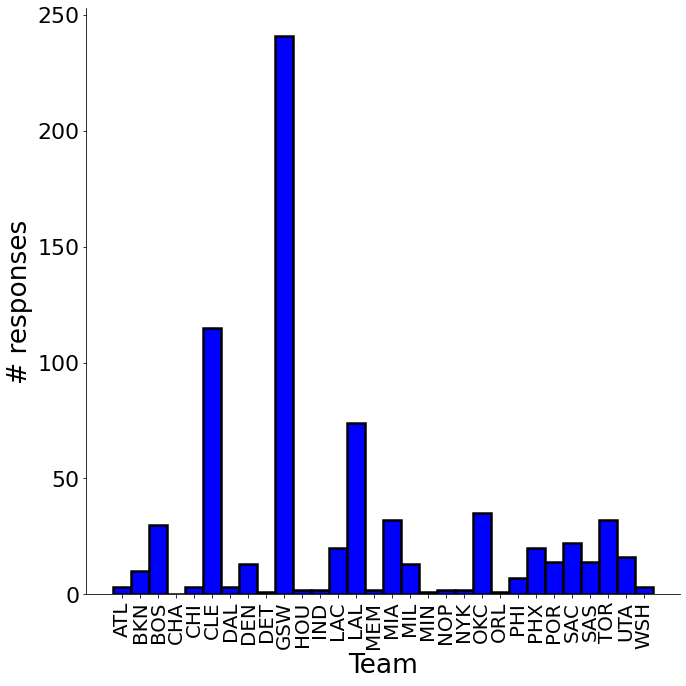

In [382]:
qq=np.linspace(-0.5,len(nba3)-0.5,len(nba3)+1)
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
histo=plt.hist(all_i,bins=qq,linewidth=lw/2,ec='black')
ax.set_ylabel('# responses',fontsize=fs*4/5)
ax.set_xlabel('Team',fontsize=fs*4/5)
ax.set_xticks(np.linspace(0,len(nba3)-1,len(nba3)))
ax.set_xticklabels(nba3,rotation=90,fontsize=fs*0.6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
f.tight_layout()
f.savefig('figs/response_across_teams.pdf', transparent=True)
print(histo[0])

33.7
84.3
3719673.311518167
1038427.1220274589


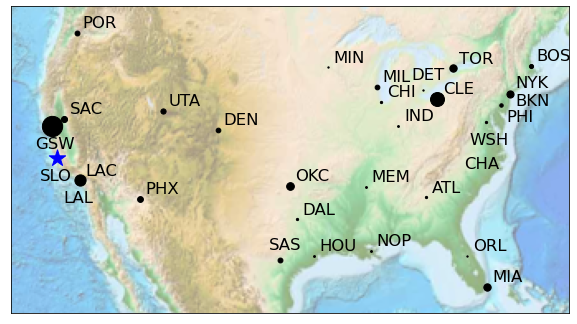

In [383]:
#https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html
dfgeo = pd.read_excel('Sports memory rubric.xlsx',sheet_name='Geolocation',header=0) #read in data

f = plt.figure(figsize=(fsz,fsz))
mstyle=1
if mstyle==1:
    m=Basemap(projection='aea', resolution=None,width=5E6, height=2.75E6,lat_0=37.5, lon_0=-97.5,)
    m.etopo(scale=0.5, alpha=0.5)
elif mstyle==2:
    m=Basemap(llcrnrlon=-120,llcrnrlat=23,urcrnrlon=-65,urcrnrlat=47,projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='coral',lake_color='aqua')
    m.drawcountries()
    m.drawstates()
    m.drawcoastlines()

for i in range(len(dfgeo)):
    tn,lat,lon=dfgeo['Team'][i],dfgeo['Latitude'][i],dfgeo['Longitude'][i]
    lat,lon=float(lat[:4]),float(lon[:4])
    x,y=m(-lon,lat)
    if i==0:
        print(lat)
        print(lon)
        print(x)
        print(y)
    fact=50000
    #plt.plot(x,y,'ok',markersize=msz)
    plt.scatter(x,y,c='k',s=histo[0][i]*1.7)
    if np.logical_or(np.logical_or(tn=='GSW',tn=='WSH'),tn=='LAL'):
        plt.text(x-fact*3,y-fact*4,tn,fontsize=fs/2)
    elif np.logical_or(tn=='SAS',tn=='DET'):
        plt.text(x-fact*2,y+fact*2,tn,fontsize=fs/2)
    elif tn=='PHI':
        plt.text(x+fact,y-fact*3,tn,fontsize=fs/2)
    elif tn=='BKN':
        plt.text(x+fact,y-fact*2,tn,fontsize=fs/2)
    else:
        plt.text(x+fact,y+fact,tn,fontsize=fs/2)

x,y=m(-120.7,35.3)
plt.scatter(x,y,c='b',marker='*',s=300)#add San Luis Obispo
plt.text(x-fact*3,y-fact*4,'SLO',fontsize=fs/2)
plt.show()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
f.tight_layout()
f.savefig('figs/geo_data.pdf', transparent=True)

['2004-2005', '2005-2006', '2006-2007', '2007-2008', '2008-2009', '2009-2010', '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']


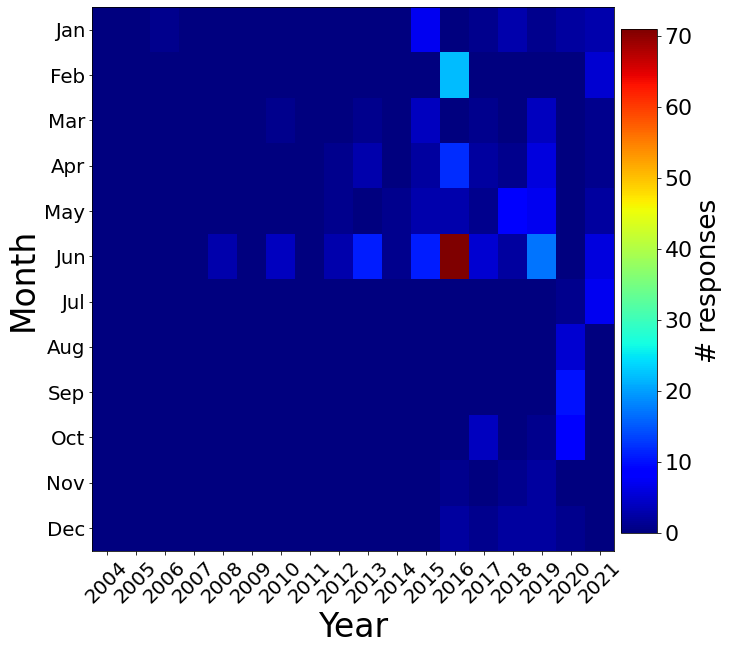

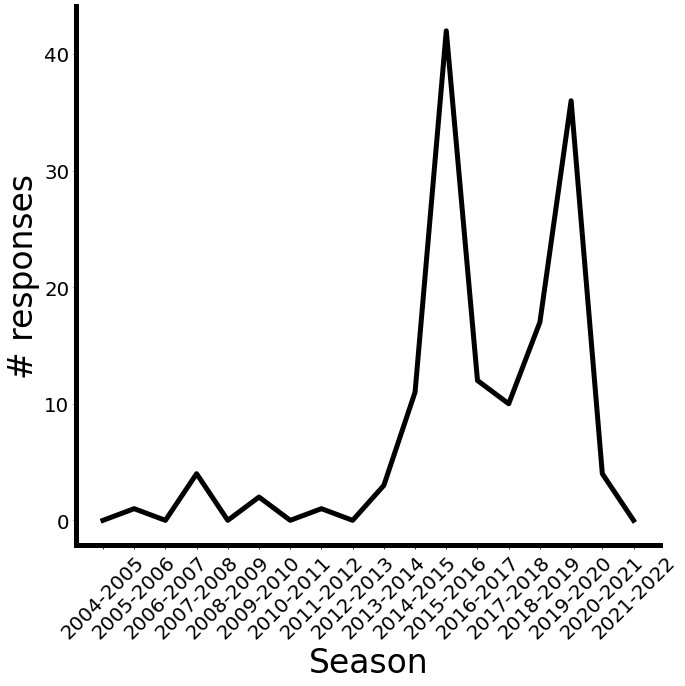

In [386]:
#characterize month/date/year of game
mos=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
szn_nms=np.linspace(szn_f,szn_f+szns-1,szns).astype(int)
szn_nms2=[]
for i in range(szns):
    szn_nms2.append(str(szn_f+i)+'-'+str(szn_f+i+1))
print(szn_nms2)
y_m_ind,y_ind_szn,mem_ages,szn_mem_ages=np.zeros((szns,12)),np.zeros((szns)),[],[]
for i in range(npp):
    y_ind=int(dfp['Year'][dfp.index[i]])
    m_ind=int(dfp['Month/date'][dfp.index[i]][5:7])
    d_ind=int(dfp['Month/date'][dfp.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfp['Study date'][dfp.index[i]][:4])
    m_ind_s=int(dfp['Study date'][dfp.index[i]][5:7])
    d_ind_s=int(dfp['Study date'][dfp.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(npn):
    y_ind=int(dfn['Year'][dfn.index[i]])
    m_ind=int(dfn['Month/date'][dfn.index[i]][5:7])
    d_ind=int(dfn['Month/date'][dfn.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfn['Study date'][dfn.index[i]][:4])
    m_ind_s=int(dfn['Study date'][dfn.index[i]][5:7])
    d_ind_s=int(dfn['Study date'][dfn.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(ngp):
    y_ind=int(dfgp['Year'][dfgp.index[i]])
    m_ind=int(dfgp['Month/date'][dfgp.index[i]][5:7])
    d_ind=int(dfgp['Month/date'][dfgp.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfgp['Study date'][dfgp.index[i]][:4])
    m_ind_s=int(dfgp['Study date'][dfgp.index[i]][5:7])
    d_ind_s=int(dfgp['Study date'][dfgp.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(ngn):
    y_ind=int(dfgn['Year'][dfgn.index[i]])
    m_ind=int(dfgn['Month/date'][dfgn.index[i]][5:7])
    d_ind=int(dfgn['Month/date'][dfgn.index[i]][8:10])
    y_m_ind[y_ind-szn_f,m_ind-1]=y_m_ind[y_ind-szn_f,m_ind-1]+1
    y_ind_s=int(dfgn['Study date'][dfgn.index[i]][:4])
    m_ind_s=int(dfgn['Study date'][dfgn.index[i]][5:7])
    d_ind_s=int(dfgn['Study date'][dfgn.index[i]][8:10])
    mem_age=datetime(y_ind_s,m_ind_s,d_ind_s)-datetime(y_ind,m_ind,d_ind)
    mem_ages.append(mem_age.days)
for i in range(nsp):
    y_ind=int(dfsp['Year'][dfsp.index[i]][:4])
    y_ind_szn[y_ind-szn_f]=y_ind_szn[y_ind-szn_f]+1
    y_ind_s=int(dfsp['Study date'][dfsp.index[i]][:4])
    mem_age=y_ind_s-y_ind
    szn_mem_ages.append(mem_age)
for i in range(nsn):
    y_ind=int(dfsn['Year'][dfsn.index[i]][:4])
    y_ind_szn[y_ind-szn_f]=y_ind_szn[y_ind-szn_f]+1
    y_ind_s=int(dfsn['Study date'][dfsn.index[i]][:4])
    mem_age=y_ind_s-y_ind
    szn_mem_ages.append(mem_age)
    
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
im=ax.imshow(y_m_ind.T,interpolation='none',aspect='auto',cmap='jet')
ax.set_ylabel('Month',fontsize=fs)
ax.set_xlabel('Year',fontsize=fs)
ax.set_yticks(np.linspace(0,len(mos)-1,len(mos)))
ax.set_yticklabels(mos,fontsize=fs*0.6)
ax.set_xticks(np.linspace(0,szns-1,szns))
ax.set_xticklabels(szn_nms, rotation = 45,fontsize=fs*0.6)
f.subplots_adjust(right=0.85) #adjust so we can add colorbar
cbar_ax = f.add_axes([0.86, 0.15, 0.05, 0.7])
cbar=f.colorbar(im, cax=cbar_ax)
cbar.set_label('# responses',fontsize=fs*0.8)
#f.tight_layout()
f.savefig('figs/time_playgame.pdf', transparent=True)

f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
ax.plot(y_ind_szn,'k',linewidth=lw)
ax.set_ylabel('# responses',fontsize=fs)
ax.tick_params(axis='y',labelsize=fs*0.6)
ax.set_xlabel('Season',fontsize=fs)
ax.set_xticks(np.linspace(0,szns-1,szns))
ax.set_xticklabels(szn_nms2, rotation = 45,fontsize=fs*0.6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#f.subplots_adjust(right=0.8) #adjust so we can add colorbar
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/time_season.pdf', transparent=True)

[19. 20.  2. 12.  3. 17.  8. 11. 10.  2.  9.  4.  7.  4. 34. 31. 29. 15.
 15.  7.  4.  3.  0.  0.  8.  3.  3.  3.  1.  2.  0.  0.  0.  0.  3.  2.
  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


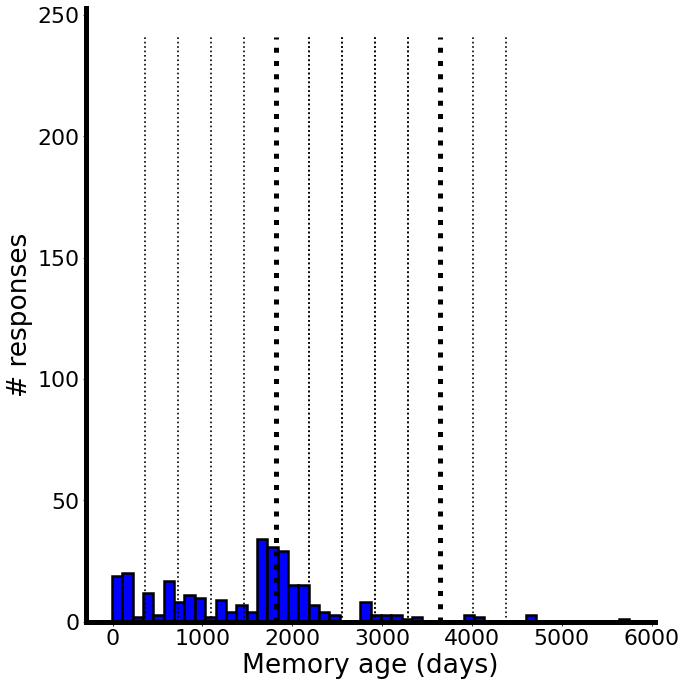

In [387]:
yr_b=4
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
#line for every year + darker every 5
plt.vlines(365*5,0,np.max(histo[0]),linewidth=lw,colors='k',linestyles='dotted')
plt.vlines(365*10,0,np.max(histo[0]),linewidth=lw,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365,365*4,yr_b),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365*6,365*9,yr_b),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365*6,365*9,yr_b),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
plt.vlines(np.linspace(365*11,365*12,2),0,np.max(histo[0]),linewidth=lw/3,colors='k',linestyles='dotted')
histo=plt.hist(mem_ages,bins=50,linewidth=lw/2,ec='black')
ax.set_ylabel('# responses',fontsize=fs*4/5)
ax.set_xlabel('Memory age (days)',fontsize=fs*4/5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/response_ages.pdf', transparent=True)
print(histo[0])

(array([ 4., 36., 17., 10., 12., 42., 11.,  3.,  0.,  1.,  0.,  2.,  0.,
        4.,  1.]), array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16.]), <a list of 15 Patch objects>)


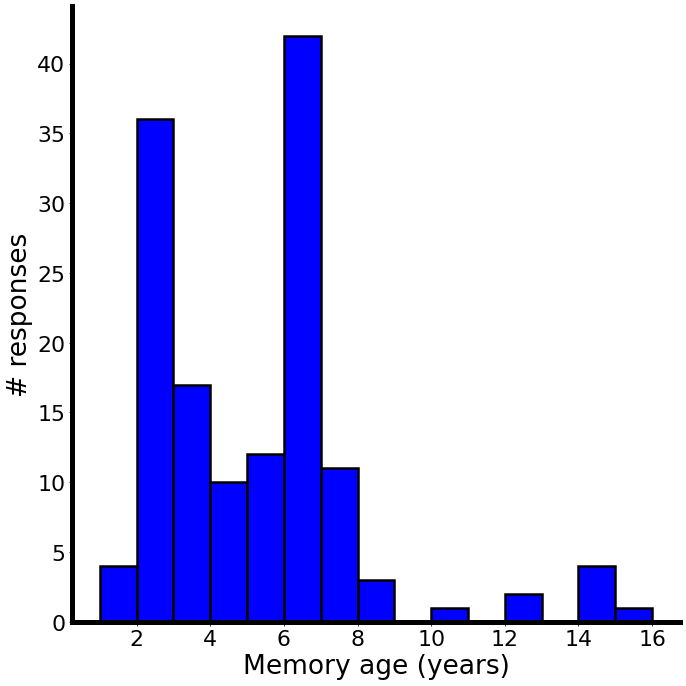

In [388]:
yr_b=4
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
histo=plt.hist(szn_mem_ages,linewidth=lw/2,ec='black',bins=15)
ax.set_ylabel('# responses',fontsize=fs*4/5)
ax.set_xlabel('Memory age (years)',fontsize=fs*4/5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/response_ages_szn.pdf', transparent=True)
print(histo)

# 1. Load play-by-play data & plot basics

In [389]:
allsurs=np.load('pydata/allsurs.npy')
mwwps=np.load('pydata/mwwps.npy')
mwwp_ts=np.load('pydata/mwwp_ts.npy')
maxsurs=np.load('pydata/maxsurs.npy')
df1=pd.read_csv('pydata/df1.csv')
fwwps=np.load('pydata/fwwps.npy')
secB=np.load('pydata/secB.npy')
print(df1[:2])

qq=np.where(abs(allsurs)<0.01)
lil_i=len(qq[0])/len(allsurs)
print('% plays with <1% impact on game:',lil_i)

qq=np.where(abs(allsurs)<0.05)
lil_i5=len(qq[0])/len(allsurs)
print('% plays with <5% impact on game:',lil_i5)

qq=np.where(abs(allsurs)>0.25)
big_i=len(qq[0])/len(allsurs)
print('% plays with <5% impact on game:',big_i)

       g_id         g_d    sl  sdiff  hp  home  vis  hw  sl_ot  year  month  \
0  40400407  2005-06-23  2880      0   0    26    8   1   2880  2005      6   
1  40400407  2005-06-23  2880      0   1    26    8   1   2880  2005      6   

   day  sdiff_adj       hwp      mwwp       sur     fgsur     wgsur    maxsur  \
0   23          4  0.702929  0.319512       NaN  0.297071  0.680488  0.098775   
1   23          4  0.702634  0.319512 -0.000295  0.297071  0.680488  0.098775   

   mwwp_t  
0  1184.0  
1  1184.0  
% plays with <1% impact on game: 0.34608928886236845
% plays with <5% impact on game: 0.8253828535453367
% plays with <5% impact on game: 0.0009720825247366121


In [390]:
sur_v=df1['sur']
sl_ot_v=df1['sl_ot']
sur_bm,sur_bs=np.zeros((len(secB)-1)),np.zeros((len(secB)-1))
for i in range(len(secB)-1):
    if i==0:
        qq=np.where(np.logical_and(sl_ot_v<=secB[i],sl_ot_v>=secB[i+1]))[0]
    else:
        qq=np.where(np.logical_and(sl_ot_v<secB[i],sl_ot_v>=secB[i+1]))[0]
    if i==0:
        print(sur_v[qq])
    sur_bm[i]=np.nanmean(np.absolute(sur_v[qq]))
    sur_bs[i]=np.nanstd(np.absolute(sur_v[qq]))

0               NaN
1         -0.000295
208             NaN
427             NaN
428       -0.000006
             ...   
5682754   -0.002254
5683053         NaN
5683054   -0.000006
5683313         NaN
5683314   -0.001125
Name: sur, Length: 45133, dtype: float64


a: 1.2857767970955909e-06, b: 0.025939052211879428
r-squared =  0.17537763456195224
a: -0.007213687352713371, b: 0.07739103776433247
r-squared =  0.8161658384543995


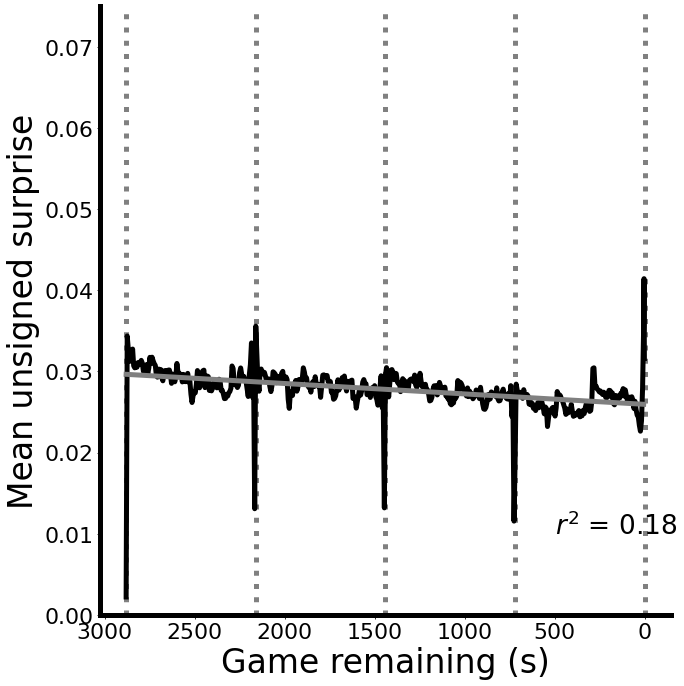

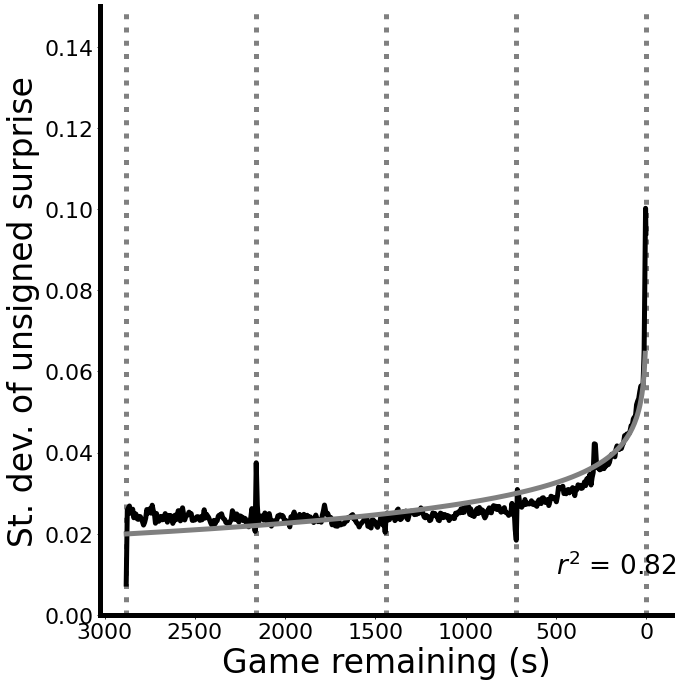

In [391]:
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
bf=-2
x,y=secB[:-1],sur_bm
a,b=np.polyfit(x,y,1)
corr, _ = pearsonr(x,y)
print('a: %s, b: %s' %(a,b))
print('r-squared = ',corr**2)
plt.plot(x,y,'k',linewidth=lw)
plt.plot(x[:bf], a*x[:bf]+b,'gray',linewidth=lw)
ax.invert_xaxis()
ax.set_ylabel('Mean unsigned surprise',fontsize=fs)
ax.set_xlabel('Game remaining (s)',fontsize=fs)
ax.set_ylim(0,0.075)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(500,0.01,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*4/5,color='k')
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
plt.vlines([t_sec,t_sec*3/4,t_sec/2,t_sec/4,0],0,0.075,linewidth=lw,colors='gray',linestyles='dotted')
f.tight_layout()
f.savefig('figs/surprise_mean.pdf', transparent=True)
    
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
y=sur_bs
a,b=np.polyfit(np.log(x),y,1)
corr, _ = pearsonr(np.log(x),y)
print('a: %s, b: %s' %(a,b))
print('r-squared = ',corr**2)
plt.plot(x,y,'k',linewidth=lw)
plt.plot(x[:bf], a*np.log(x[:bf])+b,'gray',linewidth=lw)
ax.invert_xaxis()
ax.set_ylabel('St. dev. of unsigned surprise',fontsize=fs)
ax.set_xlabel('Game remaining (s)',fontsize=fs)
ax.set_ylim(0,0.15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(500,0.01,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*4/5,color='k')
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
plt.vlines([t_sec,t_sec*3/4,t_sec/2,t_sec/4,0],0,0.15,linewidth=lw,colors='gray',linestyles='dotted')
f.tight_layout()
f.savefig('figs/surprise_stdev.pdf', transparent=True)

In [392]:
#### maybe make ax2 w/ histplot? 
def kdeplotf(dat,dat2,dat3,xl,xlim,fn,exv):
    #exv is an extra variable to adjust one thing or another
    fs,binn,legg,lw2=25,120,[],5
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    if xlim[0]<xlim[1]:
        binns=np.linspace(xlim[0],xlim[1],binn+1)
    else:
        binns=np.linspace(xlim[1],xlim[0],binn+1)
    if len(dat3)>0:
        sns.kdeplot(dat,color='k',linewidth=lw)
        sns.kdeplot(dat2,color='b',linewidth=lw)
        sns.kdeplot(dat3,color='r',linewidth=lw)
        #sns.rugplot(dat,color='k')
        #sns.histplot(dat2,color='b',linewidth=lw2,bins=binns)
        #sns.rugplot(dat2,color='b')
        #sns.rugplot(dat3,color='r')
        #sns.histplot(dat3,color='r',linewidth=lw2,bins=binns)
        legg=['All','Positive','Negative']
        if exv==2:
            legg[0]='''All, 
same game'''
        elif exv==3:
            legg[0]='''All, 4Q of 
same game'''
        elif exv==6:
            legg[0]='''All, 4Q of 
same game'''
    elif len(dat2)>0:
        sns.kdeplot(dat,color='b',linewidth=lw)
        sns.kdeplot(dat2,color='r',linewidth=lw)
        #sns.rugplot(dat,color='b')
        #sns.histplot(dat,color='b',linewidth=lw2,bins=binns,kde=True)
        #sns.rugplot(dat2,color='r')
        #sns.histplot(dat2,color='r',linewidth=lw2,bins=binns,kde=True)
        legg=['Positive','Negative']
    else:
        sns.kdeplot(dat,color='k',linewidth=lw)
        #sns.rugplot(dat,color='k')
    ax.set_ylabel('Density',fontsize=fs*5/4)
    ax.set_xlabel(xl,fontsize=fs*5/4)
    ax.set_xlim(xlim)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    if len(legg)>0:
        if exv!=5:
            ax.legend(legg,ncol=1,loc='upper left',fontsize=fs) #,frameon=False
        if exv==4:
            ax.legend(legg,ncol=1,loc='upper center',fontsize=fs)
        #elif exv==5:
        #    ax.legend(legg,ncol=3,loc='upper center',fontsize=fs)
        elif exv==6:
            ax.legend(legg,ncol=1,loc='upper right',fontsize=fs)
    if exv==1: #plot vertical lines to demarcate quarters / OT periods
        ymin, ymax = ax.get_ylim()
        plt.vlines([t_sec,t_sec*3/4,t_sec/2,t_sec/4,0,-(5*60)],ymin,ymax,
                   linewidth=lw,colors='k',linestyles='dotted')
        ax.set_ylim([ymin, ymax])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    if len(fn)>0:
        f.tight_layout()
        f.savefig(fn, transparent=True)

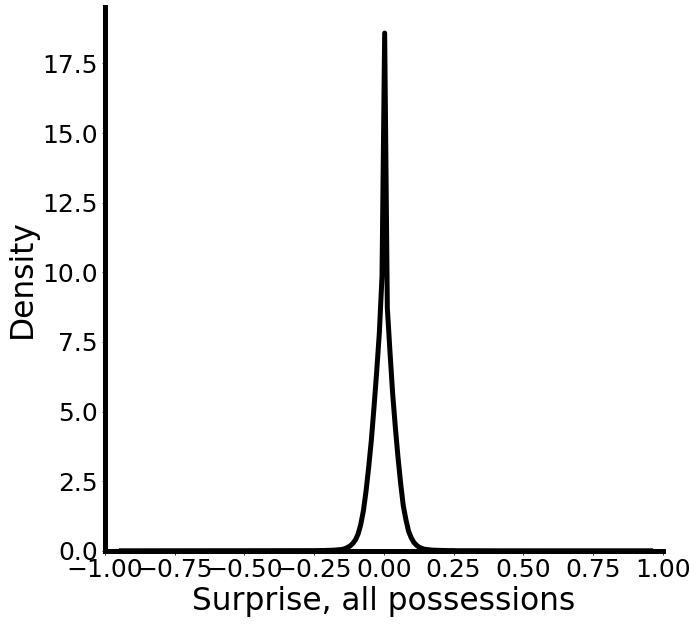

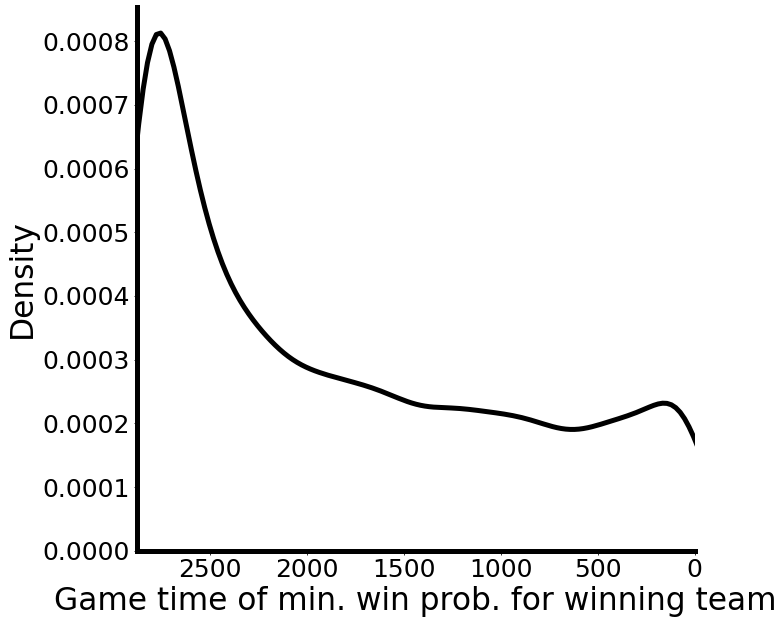

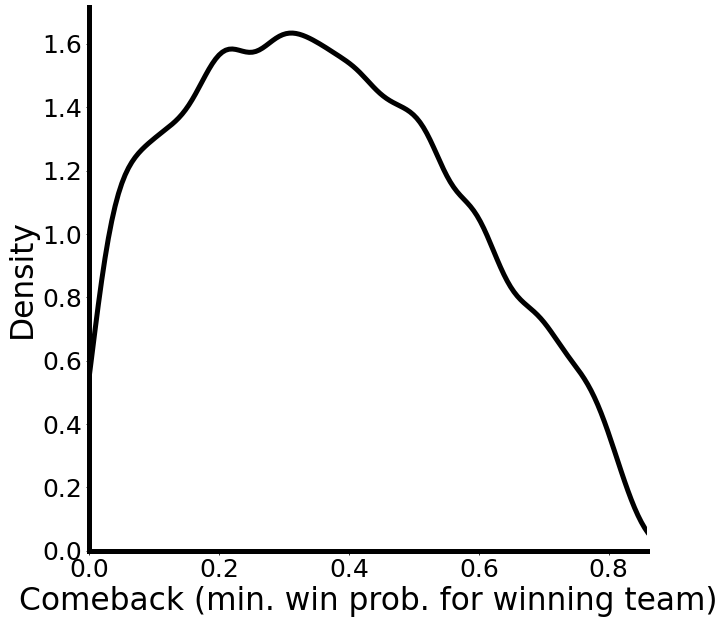

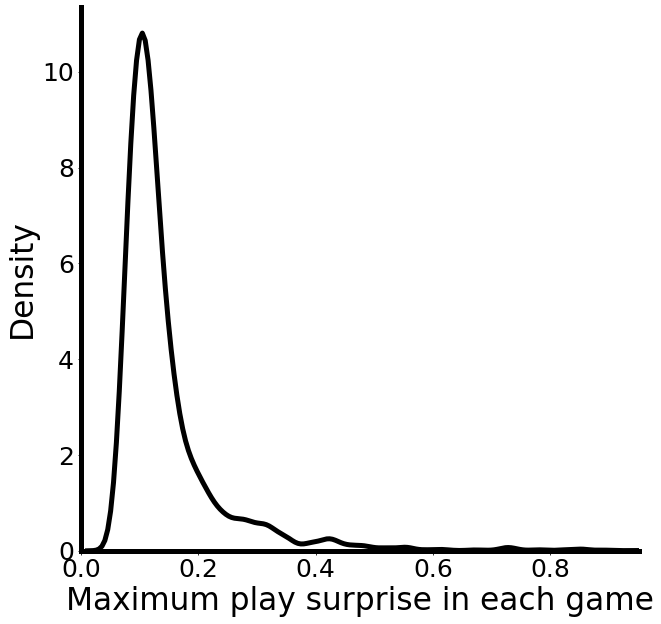

In [393]:
##possession level
kdeplotf(allsurs,[],[],'Surprise, all possessions',[-1,1],'figs/all_surs.pdf',0)
##game level
kdeplotf(mwwp_ts[:,0],[],[],'Game time of min. win prob. for winning team',[t_sec,0],
         'figs/all_comeback_times.pdf',0)
kdeplotf(mwwps[:,0],[],[],'Comeback (min. win prob. for winning team)',[0,np.max(mwwps)],
         'figs/all_comebacks.pdf',0)
kdeplotf(maxsurs[:,0],[],[],'Maximum play surprise in each game',[0,np.max(maxsurs)],
         'figs/max_play_sur_game.pdf',0)

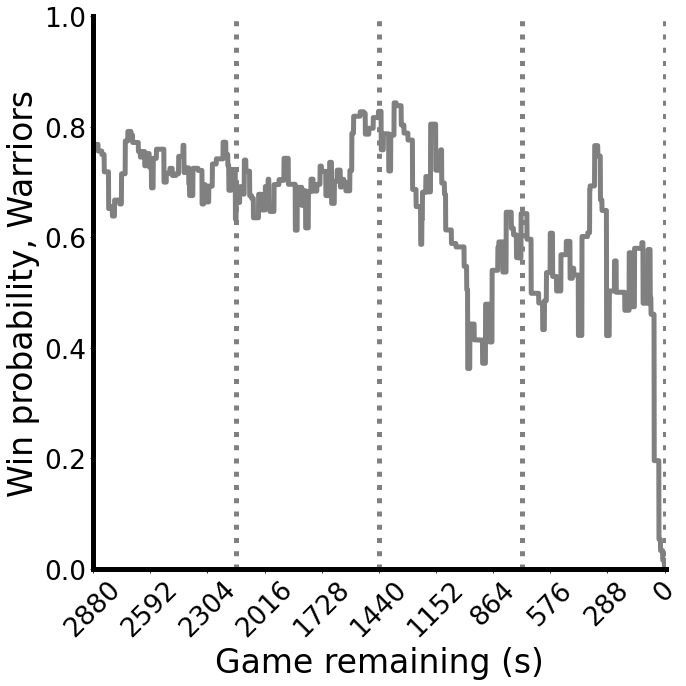

In [394]:
#plot one game - Cavs-Warriors 2016-06-19
qq=np.where(np.logical_and(np.logical_and(df1['year']==2016,df1['month']==6),df1['day']==19))[0]
sec_ds=df1['sl'][df1.index[qq]].values
wp_ds=df1['hwp'][df1.index[qq]].values
sec_ex,wp_ex=np.linspace(0,t_sec,t_sec+1),np.zeros((t_sec+1))
for i in range(len(wp_ds)-1):
    wp_ex[sec_ds[i+1]:sec_ds[i]]=wp_ds[i]
wp_ex[0],wp_ex[-1]=0,wp_ds[0]

f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
ax.plot(sec_ex,wp_ex,'gray',linewidth=lw)
ax.set_ylabel('Win probability, Warriors',fontsize=fs)
ax.set_ylim([0,1])
ax.tick_params(axis='y',labelsize=fs*4/5)
ax.set_xlabel('Game remaining (s)',fontsize=fs)
ax.set_xticklabels(np.linspace(t_sec,0,int(t_sec/(48*6))+1).astype(int), rotation = 45,fontsize=fs*4/5)
ax.set_xticks(np.linspace(t_sec,0,int(t_sec/(48*6))+1).astype(int))
ax.set_xlim([-5,t_sec])
ax.invert_xaxis()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.hlines(0.5,0,t_sec,linewidth=lw,colors='k',linestyles='dotted')
plt.vlines([t_sec,t_sec*3/4,t_sec/2,t_sec/4,0],0,1,linewidth=lw,colors='gray',linestyles='dotted')
#plt.vlines(t_sec/4,0,1,linewidth=lw,colors='k',linestyles='dotted')
#f.subplots_adjust(right=0.8) #adjust so we can add colorbar
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/example_game.pdf', transparent=True)

['Oct 1', 'Nov 1', 'Dec 1', 'Jan 1', 'Feb 1', 'Mar 1', 'Apr 1', 'May 1', 'Round 1', 'Round 2', 'Round 3', 'Finals']
[0.05128205 0.08333333 0.11111111 0.11764706 0.09756098 0.08510638
 0.07407407 0.09302326 0.10695187 0.10582011 0.3030303  1.        ]


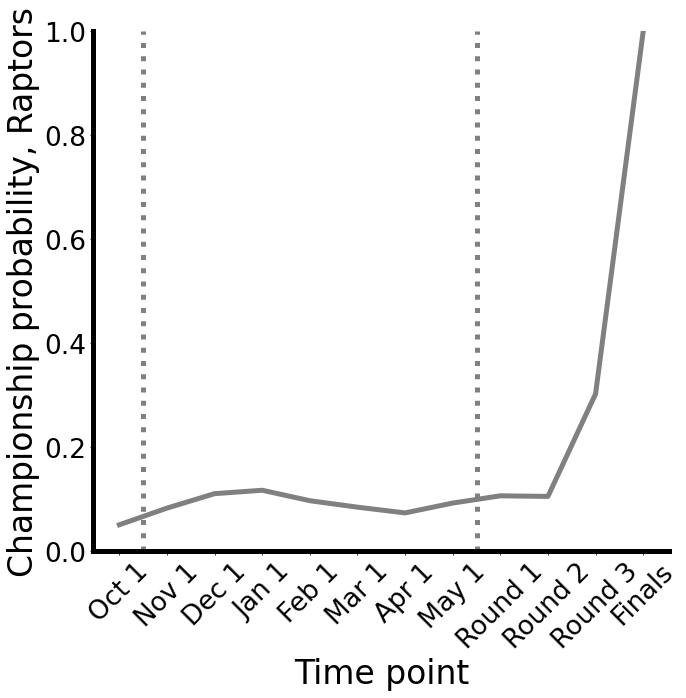

In [395]:
#odds updates
ou=['Oct 1','Nov 1','Dec 1','Jan 1','Feb 1','Mar 1','Apr 1','May 1','Round 1','Round 2','Round 3','Finals']
qq=df_ots.loc[np.logical_and(df_ots['Team']=='TOR',df_ots['Starting year']==2018)]
odds=np.zeros((len(ou)))
odds[:11]=df_ots.loc[df_ots.index==447].values[0][4:15]
odds=100/(100+odds)
odds[11]=1
print(ou)
print(odds)

f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
ax.plot(odds,'gray',linewidth=lw)
ax.set_ylabel('Championship probability, Raptors',fontsize=fs)
ax.set_ylim([0,1])
ax.tick_params(axis='y',labelsize=fs*4/5)
ax.set_xlabel('Time point',fontsize=fs)
ax.set_xticks(np.linspace(0,len(ou),len(ou)+1))
ax.set_xticklabels(ou, rotation = 45,fontsize=fs*4/5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.vlines([0.5,7.5],0,1,linewidth=lw,colors='gray',linestyles='dotted')
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
f.savefig('figs/example_season.pdf', transparent=True)

# 3. Input data from our study & plot

# Start with plays

In [396]:
#defs for reading in data
def findsecs(tstring):
    if isHMS(tstring):
        date_time = datetime.strptime(tstring, "%M:%S:%f") #datetime
        a_timedelta = date_time - datetime(1900, 1, 1) #datetime
        #print(a_timedelta)
        seconds = a_timedelta.total_seconds()
        #print(seconds)
        return seconds
    elif isMS(tstring):
        date_time = datetime.strptime(tstring, "%M:%S") #datetime
        a_timedelta = date_time # - datetime(1900, 1, 1) #datetime
        seconds = a_timedelta.total_seconds()
        #print(seconds)
        return seconds
def isHMS(input):
    try:
        time.strptime(input, '%H:%M:%S')
        return True
    except ValueError:
        return False
def isMS(input):
    try:
        time.strptime(input, '%M:%S')
        return True
    except ValueError:
        return False

In [397]:
print('# final entries, pos: %s' %npp)
timesp=np.zeros((npp)) #pre-assign empty secs column
for i in range(npp):
    if str(dfp['Game time for possession AFTER play'][dfp.index[i]])!='nan': #BEFORE
        timesp[i]=findsecs(str(dfp['Game time for possession AFTER play'][dfp.index[i]]))
        if dfp['Quarter'][dfp.index[i]]<4: #for regular game, non-4th quarter
            timesp[i]=timesp[i]+(4-dfp['Quarter'][dfp.index[i]])*(12*60)
        elif dfp['Quarter'][dfp.index[i]]>4: #for OT
            timesp[i]=timesp[i]+(4-dfp['Quarter'][dfp.index[i]])*(5*60)
dfp=dfp.rename(columns={"Spectacularity (1-4)": "Spectacularity"}) 
print('# final entries, neg: %s' %npn)
timesn=np.zeros((npn)) #pre-assign empty secs column
for i in range(npn):
    if str(dfn['Game time for possession AFTER play'][dfn.index[i]])!='nan':
        timesn[i]=findsecs(str(dfn['Game time for possession AFTER play'][dfn.index[i]]))
        if dfn['Quarter'][dfn.index[i]]<4:
            timesn[i]=timesn[i]+(4-dfn['Quarter'][dfn.index[i]])*(12*60)
        elif dfn['Quarter'][dfn.index[i]]>4:
            timesn[i]=timesn[i]+(4-dfn['Quarter'][dfn.index[i]])*(5*60)
dfn=dfn.rename(columns={"Spectacularity (1-4)": "Spectacularity"}) 

#OT games:separate time being looked up (for alignment w/ data) from the time left (for win probability)
timesp2=deepcopy(timesp)
qq=np.where(timesp<0)[0] #
timesp2[qq]=timesp[qq]+(60*5)
qq=np.where(timesp<0)[0] #repeat in case 2OT
timesp2[qq]=timesp[qq]+(60*5)
timesn2=deepcopy(timesn)
qq=np.where(timesn<0)[0]
timesn2[qq]=timesn[qq]+(60*5)
qq=np.where(timesn<0)[0]
timesn2[qq]=timesn[qq]+(60*5)

#clean up time info and data as ints
m_ind,d_ind=np.zeros((npp)),np.zeros((npp))
for i in range(npp):
    m_ind[i]=dfp['Month/date'][dfp.index[i]][5:7]
    d_ind[i]=dfp['Month/date'][dfp.index[i]][8:10]
dfp['month']=m_ind
dfp['day']=d_ind
dfp['gt']=timesp
dfp['gt2']=timesp2
dfp[['month','day','Year','home','gt','gt2']]=dfp[['month','day','Year','home','gt','gt2']].astype(int)

m_ind,d_ind=np.zeros((npn)),np.zeros((npn))
for i in range(npn):
    m_ind[i]=dfn['Month/date'][dfn.index[i]][5:7]
    d_ind[i]=dfn['Month/date'][dfn.index[i]][8:10]
dfn['month']=m_ind
dfn['day']=d_ind
dfn['gt']=timesn
dfn['gt2']=timesn2
dfn[['month','day','Year','home','gt','gt2']]=dfn[['month','day','Year','home','gt','gt2']].astype(int)

# final entries, pos: 70
# final entries, neg: 74


# find info from game for a given play

In [398]:
#loop over all dfp, matching year/month/day/team
sursp_a,perc_g_surp,perc_g_surp_4q=np.zeros((npp)),np.zeros((npp)),np.zeros((npp))
sursp_a_abs,perc_g_surp_abs,perc_g_surp_4q_abs=np.zeros((npp)),np.zeros((npp)),np.zeros((npp))
perc_into_sznpp=np.zeros((npp))
for i in range(npp):
    curr_y=dfp['Year'][dfp.index[i]] #match year
    q=np.where(df1['year']==curr_y)[0]
    curr_m=dfp['month'][dfp.index[i]] #match month
    qq=np.where(df1['month'][q]==curr_m)[0]
    curr_d=dfp['day'][dfp.index[i]] #match date
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    curr_ht=dfp['home'][dfp.index[i]] #match home team
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]] #dataframe representing full game
    tdiffs=np.absolute(df1gt['sl']-dfp['gt'][dfp.index[i]]) #match play by finding time diffs, min
    pos_m=np.where(tdiffs==np.min(tdiffs))[0]
    #sometimes it grabs two within the same second - must check these!
    print('Year, month, date, home:%s,%s,%s,%s' %(curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    print('game time, RAs:%s;pbp:%s;#rs:%s' %(dfp['gt'][dfp.index[i]],df1gt['sl'][df1gt.index[pos_m]],len(pos_m)))
    if len(pos_m)>1:
        print('special i:',i)
        print('multiple surs:',df1gt['sur'][df1gt.index[pos_m]])
    if i==4: #fix one spot w/ multiple plays within a second
        print(df1gt['sur'][df1gt.index[pos_m]])
        pos_m=pos_m[4]
    elif i==8:
        pos_m=pos_m[1]
    elif i==9:
        pos_m=pos_m[1]
    elif i==16:
        pos_m=pos_m[1] 
    #elif i==40:
    #    pos_m=pos_m[2] 
    #elif i==48:
    #    pos_m=pos_m[2]''' 
    else:
        pos_m=pos_m[0] #other cases
    sursp_a[i]=df1gt['sur'][df1gt.index[pos_m]] #relative surprise by the algorithm
    sursp_a_abs[i]=np.absolute(df1gt['sur'][df1gt.index[pos_m]]) #abs surprise by the algorithm
    pos_4q=np.where(df1gt['sl']<60*12)[0] #grab game events from 4th quarter
    if i==0:
        allgsursp=df1gt['sur'][1:] #all rel surprise values from that game
        allgsursp_4q=df1gt['sur'][df1gt.index[pos_4q]] #all surprise values in last five min
        allgsursp_abs=np.absolute(df1gt['sur'][1:]) #absolute surprise
        allgsursp_4q_abs=np.absolute(df1gt['sur'][df1gt.index[pos_4q]])
    else:
        allgsursp=np.hstack([allgsursp,df1gt['sur'][1:]])
        allgsursp_4q=np.hstack([allgsursp_4q,df1gt['sur'][df1gt.index[pos_4q]]])
        allgsursp_abs=np.hstack([allgsursp_abs,np.absolute(df1gt['sur'][1:])])
        allgsursp_4q_abs=np.hstack([allgsursp_4q_abs,np.absolute(df1gt['sur'][df1gt.index[pos_4q]])])
    perc_g_surp[i]=stats.percentileofscore(df1gt['sur'][1:].values,sursp_a[i])
    perc_g_surp_4q[i]=stats.percentileofscore(df1gt['sur'][df1gt.index[pos_4q]].values,sursp_a[i])
    perc_g_surp_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][1:].values),sursp_a_abs[i])
    perc_g_surp_4q_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][df1gt.index[pos_4q]].values),
                                                sursp_a_abs[i])
    print('expert sur:%s' %format(dfp['Relative surprise'][dfp.index[i]]/100,".2f"))
    print('sur, perc sur g, perc sur 4q:%s,%s,%s' 
          %(format(sursp_a[i],".2f"),format(perc_g_surp[i],".2f"),format(perc_g_surp_4q[i],".2f"),))
    print('abs sur, abs perc sur g, abs perc sur 4q:%s,%s,%s' 
          %(format(sursp_a_abs[i],".2f"),format(perc_g_surp_abs[i],".2f"),format(perc_g_surp_4q_abs[i],".2f"),))
    
    curr_g_id=df1gt['g_id'][df1gt.index[0]] #current game id
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    if curr_m>mthc: #if happens in early part of season
        szn=curr_y+0
    else:
        szn=curr_y-1 #if happens in late part
    #find games in early part of season
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    #late part of season
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl]) #combine df of all updates in this season!
    ids_tszn=df1szn.g_id.unique() #find unique games
    perc_into_sznpp[i]=stats.percentileofscore(ids_tszn,curr_g_id) #all in order by g_id so find %ile
    print('\n')

Year, month, date, home:2015,6,14,9
rows, rows, rows, rows:362147,1540,243,243
game time, RAs:453;pbp:3240049    453
Name: sl, dtype: int64;#rs:1
expert sur:0.10
sur, perc sur g, perc sur 4q:0.13,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.13,99.59,98.46


Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
game time, RAs:5;pbp:2552917    5
2552918    5
Name: sl, dtype: int64;#rs:2
special i: 1
multiple surs: 2552917    0.426566
2552918    0.000000
Name: sur, dtype: float64
expert sur:0.00
sur, perc sur g, perc sur 4q:0.43,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.43,100.00,100.00


Year, month, date, home:2019,5,12,27
rows, rows, rows, rows:352368,7649,513,253
game time, RAs:0;pbp:4681818    0
4681819    0
4681820    0
Name: sl, dtype: int64;#rs:3
special i: 2
multiple surs: 4681818    0.393222
4681819    0.000000
4681820    0.031323
Name: sur, dtype: float64
expert sur:0.33
sur, perc sur g, perc sur 4q:0.39,100.00,100.00
abs sur



Year, month, date, home:2018,12,27,25
rows, rows, rows, rows:358838,56951,1343,278
game time, RAs:0;pbp:4886388    0
4886389    0
4886390    0
4886391    0
Name: sl, dtype: int64;#rs:4
special i: 22
multiple surs: 4886388    0.852615
4886389    0.000000
4886390    0.000000
4886391    0.046892
Name: sur, dtype: float64
expert sur:0.90
sur, perc sur g, perc sur 4q:0.85,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.85,100.00,100.00


Year, month, date, home:2016,2,27,20
rows, rows, rows, rows:367236,44233,2117,289
game time, RAs:-299;pbp:3713156   -300
3713157   -300
Name: sl, dtype: int64;#rs:2
special i: 23
multiple surs: 3713156   -0.408294
3713157   -0.010274
Name: sur, dtype: float64
expert sur:0.36
sur, perc sur g, perc sur 4q:-0.41,0.35,0.96
abs sur, abs perc sur g, abs perc sur 4q:0.41,100.00,100.00


Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
expert sur:0.10
sur, pe



Year, month, date, home:2019,4,23,24
rows, rows, rows, rows:352368,32820,1013,250
game time, RAs:0;pbp:4689603    0
4689604    0
4689605    0
Name: sl, dtype: int64;#rs:3
special i: 46
multiple surs: 4689603    0.350099
4689604    0.000000
4689605    0.005968
Name: sur, dtype: float64
expert sur:0.33
sur, perc sur g, perc sur 4q:0.35,100.00,100.00
abs sur, abs perc sur g, abs perc sur 4q:0.35,100.00,100.00


Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
expert sur:0.31
sur, perc sur g, perc sur 4q:-0.26,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00


Year, month, date, home:2020,8,4,12
rows, rows, rows, rows:205965,32434,1570,255
game time, RAs:0;pbp:5078873    0
5078874    0
5078875    0
Name: sl, dtype: int64;#rs:3
special i: 48
multiple surs: 5078873   -0.353913
5078874   -0.057094
5078875   -0.007561
Name: sur, dtype: float64
expert sur:0.54
sur, perc sur g, p

In [399]:
#repeat for negative plays - for all comments, see above
sursn_a,perc_g_surn,perc_g_surn_4q=np.zeros((npn)),np.zeros((npn)),np.zeros((npn))
sursn_a_abs,perc_g_surn_abs,perc_g_surn_4q_abs=np.zeros((npn)),np.zeros((npn)),np.zeros((npn))
perc_into_sznpn=np.zeros((npn))
for i in range(npn):
    curr_y=dfn['Year'][dfn.index[i]] 
    q=np.where(df1['year']==curr_y)[0]
    curr_m=dfn['month'][dfn.index[i]] 
    qq=np.where(df1['month'][q]==curr_m)[0]
    curr_d=dfn['day'][dfn.index[i]] 
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    curr_ht=dfn['home'][dfn.index[i]] 
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]]
    tdiffs=np.absolute(df1gt['sl']-dfn['gt'][dfn.index[i]]) 
    pos_m=np.where(tdiffs==np.min(tdiffs))[0]
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    print('game time, RAs:%s;pbp:%s;#rs:%s' %(dfn['gt'][dfn.index[i]],df1gt['sl'][df1gt.index[pos_m]],len(pos_m)))
    if len(pos_m)>1:
        print('special i:',i)
        print('multiple surs:',df1gt['sur'][df1gt.index[pos_m]])
    if i==15: 
        pos_m=pos_m[1]
    elif i==33: 
        pos_m=pos_m[2] #34, [3]
    elif i==37: 
        pos_m=pos_m[2]
    elif i==48: 
        pos_m=pos_m[2]
    elif i==52: 
        pos_m=pos_m[1]
    elif i==60: 
        pos_m=pos_m[2]
    elif i==68: 
        pos_m=pos_m[-1]
    elif i==73: 
        pos_m=pos_m[1]
    else:
        pos_m=pos_m[0] 
    print('game time, RAs:%s;pbp:%s' %(dfn['gt'][dfn.index[i]],df1gt['sl'][df1gt.index[pos_m]]))
    sursn_a[i]=df1gt['sur'][df1gt.index[pos_m]]
    sursn_a_abs[i]=np.absolute(df1gt['sur'][df1gt.index[pos_m]]) 
    pos_4q=np.where(df1gt['sl']<60*12)[0] 
    if i==0:
        allgsursn=df1gt['sur'][1:]
        allgsursn_4q=df1gt['sur'][df1gt.index[pos_4q]] 
        allgsursn_abs=np.absolute(df1gt['sur'][1:]) 
        allgsursn_4q_abs=np.absolute(df1gt['sur'][df1gt.index[pos_4q]])
    else:
        allgsursn=np.hstack([allgsursn,df1gt['sur'][1:]])
        allgsursn_4q=np.hstack([allgsursn_4q,df1gt['sur'][df1gt.index[pos_4q]]])
        allgsursn_abs=np.hstack([allgsursn_abs,np.absolute(df1gt['sur'][1:])])
        allgsursn_4q_abs=np.hstack([allgsursn_4q_abs,np.absolute(df1gt['sur'][df1gt.index[pos_4q]])])
    perc_g_surn[i]=stats.percentileofscore(df1gt['sur'][1:].values,sursn_a[i])
    perc_g_surn_4q[i]=stats.percentileofscore(df1gt['sur'][df1gt.index[pos_4q]].values,sursn_a[i])
    perc_g_surn_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][1:].values),sursn_a_abs[i])
    perc_g_surn_4q_abs[i]=stats.percentileofscore(np.absolute(df1gt['sur'][df1gt.index[pos_4q]].values),
                                                sursn_a_abs[i])
    print('Year, month, date, home:%s,%s,%s,%s' %(curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    print('expert sur:%s' %format(dfn['Relative surprise'][dfn.index[i]]/100,".2f"))
    print('sur, perc sur g, perc sur 4q:%s,%s,%s' 
          %(format(sursn_a[i],".3f"),format(perc_g_surn[i],".2f"),format(perc_g_surn_4q[i],".2f")))
    print('abs sur, abs perc sur g, abs perc sur 4q:%s,%s,%s' 
          %(format(sursn_a_abs[i],".2f"),format(perc_g_surn_abs[i],".2f"),format(perc_g_surn_4q_abs[i],".2f")))
    
    curr_g_id=df1gt['g_id'][df1gt.index[0]]
    if curr_y!=2020:
        mthc=8 
    else:
        mthc=11
    if curr_m>mthc: 
        szn=curr_y+0
    else:
        szn=curr_y-1 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl])
    ids_tszn=df1szn.g_id.unique()
    perc_into_sznpn[i]=stats.percentileofscore(ids_tszn,curr_g_id)
    

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,100.00
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:53;pbp:3600531    53
Name: sl, dtype: int64;#rs:1
game time, RAs:53;pbp:53
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.31
sur, perc sur g, perc sur 4q:-0.265,0.43,1.89
abs sur, abs perc sur g, abs perc sur 4q:0.26,100.00,

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45
rows, rows, rows, rows:362709,46451,526,264
game time, RAs:2565;pbp:4656663    2565
Name: sl, dtype: int64;#rs:1
game time, RAs:2565;pbp:2565
Year, month, date, home:2017,10,17,5
rows, rows, rows, rows:362709,46451,526,264
expert sur:0.00
sur, perc sur g, perc sur 4q:-0.024,24.33,34.38
abs sur, abs perc sur g, abs perc sur 4q:0.02,50.19,21.88
rows, rows, rows, rows:367236,9052,234,234
game time, RAs:27;pbp:3602262    26
3602263    26
Name: sl, dtype: int64;#rs:2
special i: 24
multiple surs: 3602262    0.003257
3602263    0.000000
Name: sur, dtype: float64
game time, RAs:27;pbp:26
Year, month, date, home:2016,5,30,9
rows, rows, rows, rows:367236,9052,234,2

rows, rows, rows, rows:205965,57836,1576,258
game time, RAs:885;pbp:5204665    885
5204666    885
5204667    885
Name: sl, dtype: int64;#rs:3
special i: 44
multiple surs: 5204665   -0.000927
5204666    0.012903
5204667   -0.011494
Name: sur, dtype: float64
game time, RAs:885;pbp:885
Year, month, date, home:2020,1,7,13
rows, rows, rows, rows:205965,57836,1576,258
expert sur:0.00
sur, perc sur g, perc sur 4q:-0.001,38.13,10.17
abs sur, abs perc sur g, abs perc sur 4q:0.00,27.63,79.66
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45
rows, rows, rows, rows:205965,9067,469,223
game time, RAs:0;pbp:5051270    0
Name: sl, dtype: int64;#rs:1
game time, RAs:0;pbp:0
Year, month, date, home:2020,9,1,7
rows, rows, 

rows, rows, rows, rows:367236,1730,236,236
game time, RAs:1;pbp:3600537    1
Name: sl, dtype: int64;#rs:1
game time, RAs:1;pbp:1
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.01
sur, perc sur g, perc sur 4q:-0.016,34.47,47.17
abs sur, abs perc sur g, abs perc sur 4q:0.02,37.02,24.53
rows, rows, rows, rows:367236,1730,236,236
game time, RAs:110;pbp:3600527    109
Name: sl, dtype: int64;#rs:1
game time, RAs:110;pbp:109
Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
expert sur:-0.06
sur, perc sur g, perc sur 4q:-0.110,1.70,7.55
abs sur, abs perc sur g, abs perc sur 4q:0.11,97.45,92.45
rows, rows, rows, rows:283261,2010,235,235
game time, RAs:13;pbp:5370092    13
Name: sl, dtype: int64;#rs:1
game time, RAs:13;pbp:13
Year, month, date, home:2021,7,17,23
rows, rows, rows, rows:283261,2010,235,235
expert sur:-0.16
sur, perc sur g, perc sur 4q:-0.063,6.41,8.33
abs sur, abs perc sur g, abs perc sur 4q:0.06,88.89,88.3

In [400]:
chvp=np.zeros((npp)) #fix quick thing with cheering for being strings / inconvertible to int quickly
for i in range(npp):
    if int(dfp['Cheering for (1=H,-1=V)'][dfp.index[i]])==1:
        chvp[i]=1
    elif int(dfp['Cheering for (1=H,-1=V)'][dfp.index[i]])==-1:
        chvp[i]=-1
dfp['chv']=chvp
chvn=np.zeros((npn)) #fix quick thing with cheering for being strings / inconvertible to int quickly
for i in range(npn):
    if int(dfn['Cheering for (1=H,-1=V)'][dfn.index[i]])==1:
        chvn[i]=1
    elif int(dfn['Cheering for (1=H,-1=V)'][dfn.index[i]])==-1:
        chvn[i]=-1
dfn['chv']=chvn

dfp['relsur_a']=np.multiply(sursp_a,dfp['chv'].values) #relative surprise by algorithm
dfn['relsur_a']=np.multiply(sursn_a,dfn['chv'].values)

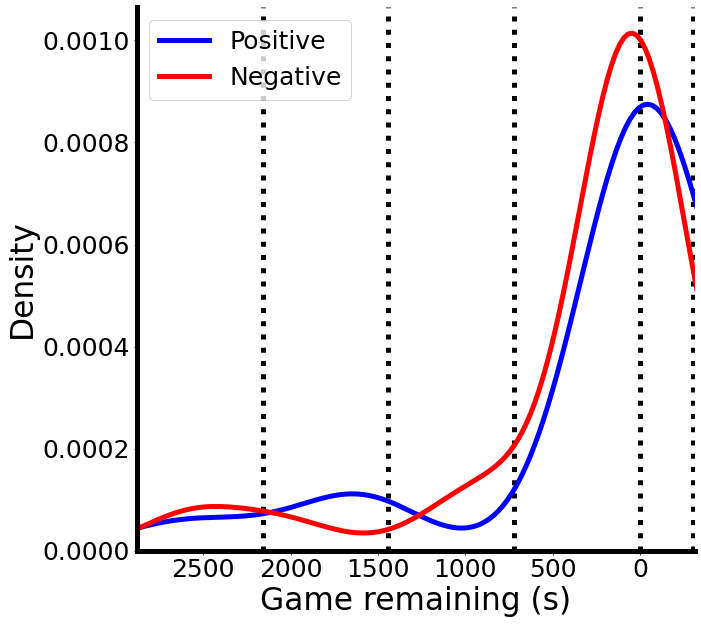

times pos v neg, stat = -0.5940978808697887, pval = 0.5533919452606422,df = 142


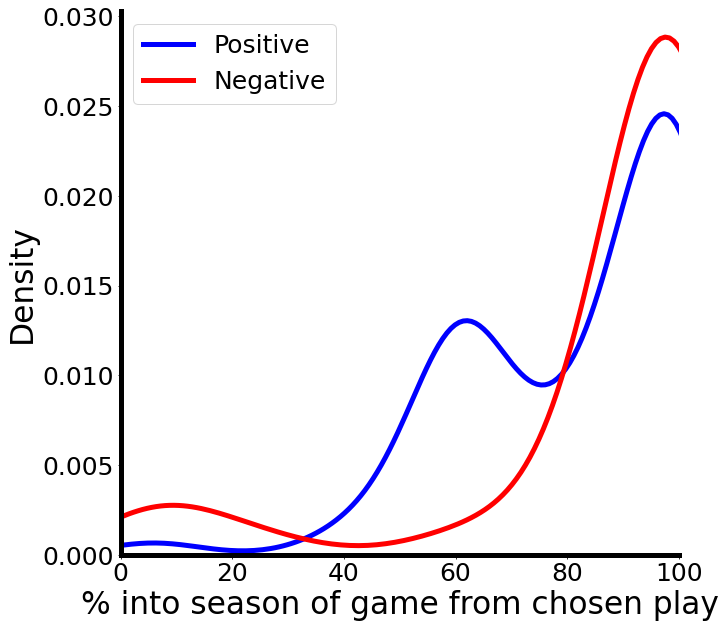

times pos v neg, stat = -1.365111095620746, pval = 0.17437703759090842,df = 142


In [401]:
# plot when chosen plays happen in game
figp=1
nseci=t_sec/2 #2880 #720
max_gl,min_gl=t_sec+0,-(5*60)-10 #add 10 s buffer so we can see rugplot points
sec_a=np.linspace(min_gl,max_gl,51) #last quarter
kdeplotf(timesp,timesn,[],'Game remaining (s)',[max_gl,min_gl],'figs/play_recalltimes.pdf',1)

x,y=timesp,timesn
stat,pval=ttest_ind(x,y,nan_policy='omit')
print('times pos v neg, stat = %s, pval = %s,df = %s' %(stat,pval,len(x)+len(y)-2))

#plot when chosen plays happen in season
kdeplotf(perc_into_sznpp,perc_into_sznpn,[],'% into season of game from chosen play',
         [0,100],'figs/play_recalltimes_szn.pdf',0)

x,y=perc_into_sznpp,perc_into_sznpn
stat,pval=ttest_ind(x,y,nan_policy='omit')
print('times pos v neg, stat = %s, pval = %s,df = %s' %(stat,pval,len(x)+len(y)-2))

(0.9442398158906452,
 0.01841126416515813,
 0.8754650193612041,
 -0.018769280049418382)

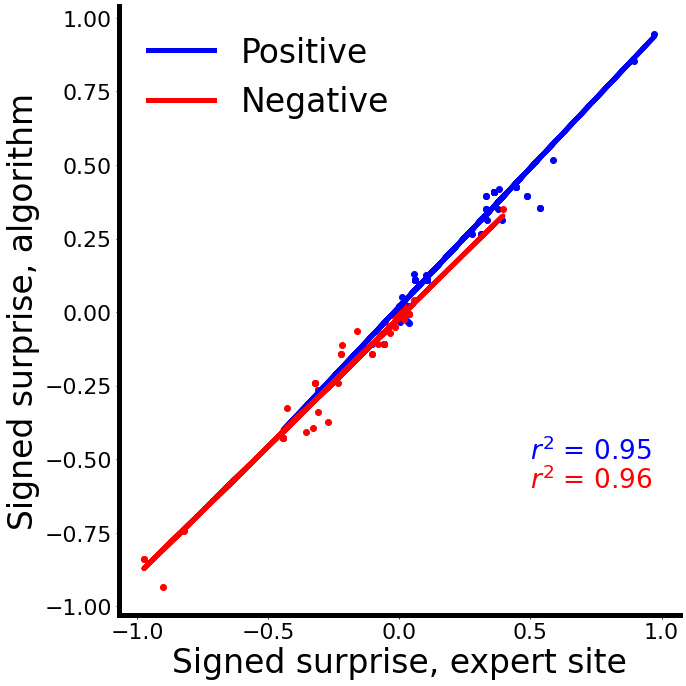

In [402]:
#check algo vs expert
def scatterp(x1,y1,x2,y2,xl,yl,fn,exv):
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    plt.scatter(x1,y1)
    a1,b1=np.polyfit(x1,y1,1)
    plt.plot(x1, a1*x1+b1,linewidth=lw)
    if len(x2)>0:
        plt.scatter(x2,y2)
        a2,b2=np.polyfit(x2,y2,1)
        plt.plot(x2, a2*x2+b2,linewidth=lw)
    ax.set_xlabel(xl,fontsize=fs)
    ax.set_ylabel(yl,fontsize=fs)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    ax.legend(['Positive','Negative'],ncol=1,loc='upper left',fontsize=fs,frameon=False)
    if exv>0:
        ax.legend(['Positive','Negative'],ncol=1,loc='upper right',fontsize=fs,frameon=False)
        
    corr1, _ = pearsonr(x1,y1)
    corr2, _ = pearsonr(x2,y2)
    if len(fn)>0:
        if exv==1:
            ax.text(0.5,1.3,'$r^{2}$ = %.2f' %corr1**2,fontsize=fs*4/5,color='b')
            ax.text(0.5,1.1,'$r^{2}$ = %.2f' %corr2**2,fontsize=fs*4/5,color='r')
        elif exv==2:
            ax.text(15,1.3,'$r^{2}$ = %.2f' %corr1**2,fontsize=fs*4/5,color='b')
            ax.text(15,1.1,'$r^{2}$ = %.2f' %corr2**2,fontsize=fs*4/5,color='r')
        else:
            ax.text(0.5,-0.5,'$r^{2}$ = %.2f' %corr1**2,fontsize=fs*4/5,color='b')
            ax.text(0.5,-0.6,'$r^{2}$ = %.2f' %corr2**2,fontsize=fs*4/5,color='r')
        f.tight_layout()
        f.savefig(fn, transparent=True)
    return a1,b1,a2,b2

scatterp(dfp['Relative surprise']/100,dfp['relsur_a'],dfn['Relative surprise']/100,dfn['relsur_a'],
        'Signed surprise, expert site','Signed surprise, algorithm','figs/play_algoVexpert.pdf',0)

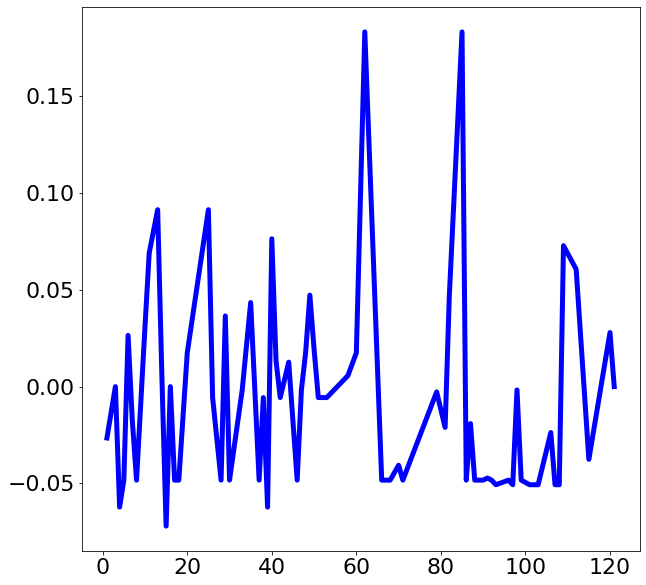

In [403]:
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
plt.plot((dfp['Relative surprise']/100-dfp['relsur_a']),linewidth=lw)

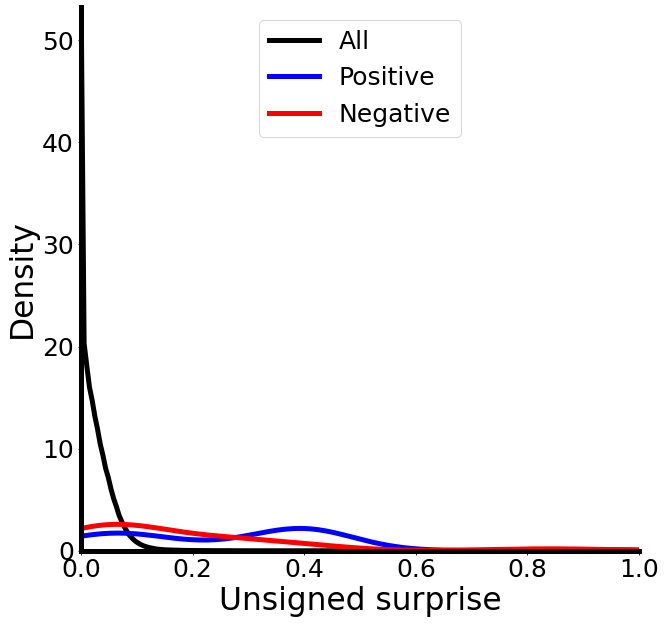

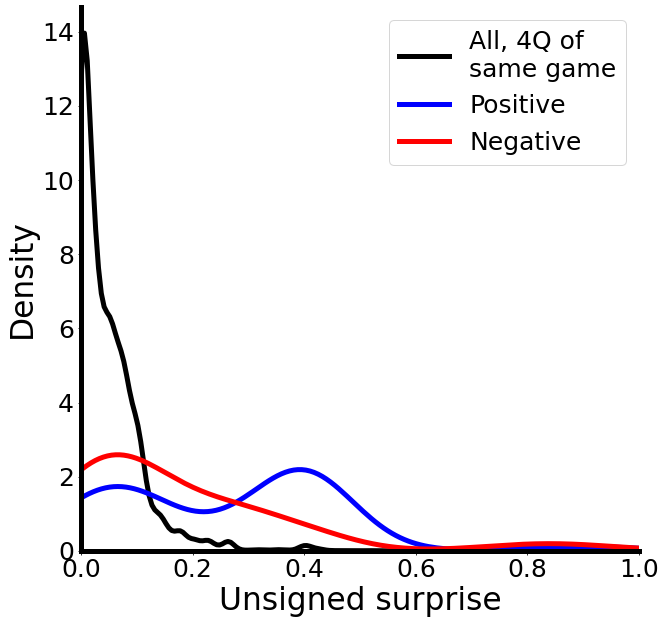

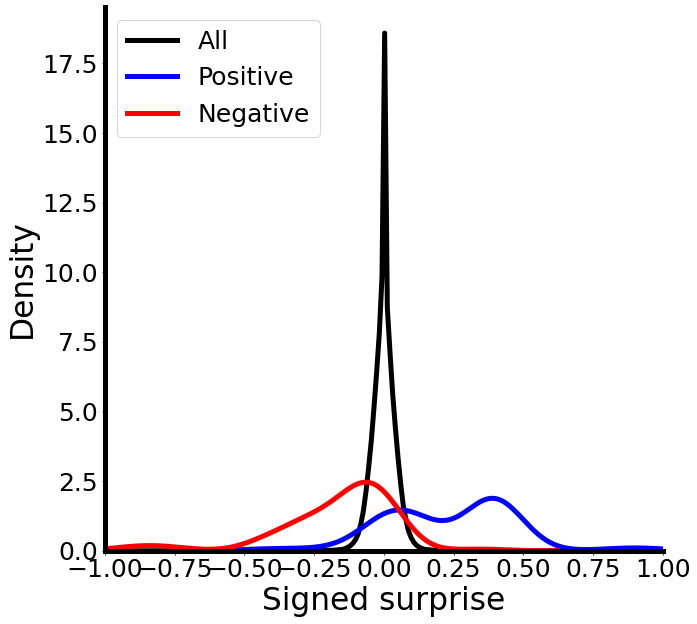

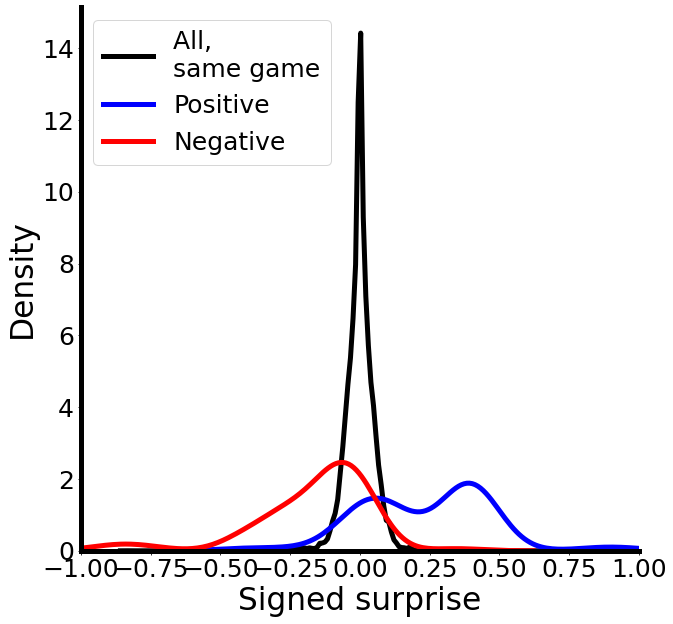

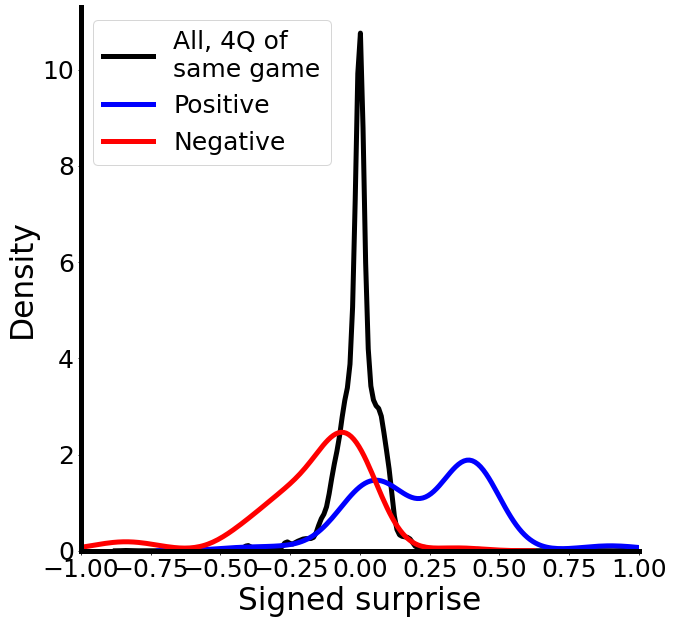

pos, allsurs, stat = 48.755535435104015, pval = 0.0
pos, allgsursp, stat = 35.81172038628268, pval = 1.6412266306431752e-271
pos, allgsursp_4q, stat = 23.926565696713094, pval = 2.6675205188756128e-120
neg, allsurs, stat = -35.08020696630003, pval = 1.4443620172178584e-269
neg, allgsursp, stat = -26.02833614617326, pval = 9.970845352413358e-147
neg, allgsursp_4q, stat = -16.565434155646326, pval = 5.263479849290847e-60
% + plays with >5% impact on game: 0.7714285714285715
% - plays with >5% impact on game: 0.6756756756756757
% + plays with >25% impact on game: 0.5714285714285714
% - plays with >25% impact on game: 0.2972972972972973


In [404]:
expert_algo=2 #1=use expert #s, 2=use algorithm
if expert_algo==1:
    sursp,sursn=dfp['Signed surprise']/100,dfn['Signed surprise']/100
elif expert_algo==2:
    sursp,sursn=dfp['relsur_a'],dfn['relsur_a']
    
allgsurs=np.hstack([allgsursp,allgsursn])
allgsurs_4q=np.hstack([allgsursp_4q,allgsursn_4q])

##possession level
nb=100
kdeplotf(np.absolute(allsurs),np.absolute(sursp),np.absolute(sursn),
         'Unsigned surprise',[0,1],'figs/play_abs_surprise.pdf',4)
kdeplotf(np.absolute(allgsurs_4q),np.absolute(sursp),np.absolute(sursn),
         'Unsigned surprise',[0,1],'figs/play_abs_surprise_4q.pdf',6)

kdeplotf(allsurs,sursp,sursn,'Signed surprise',[-1,1],'figs/play_surprise.pdf',0)
kdeplotf(allgsurs,sursp,sursn,'Signed surprise',[-1,1],'figs/play_surprise_allgsurs.pdf',2)
kdeplotf(allgsurs_4q,sursp,sursn,'Signed surprise',[-1,1],'figs/play_surprise_allgsurs_4q.pdf',3)

#run stats
stat,pval=ttest_ind(sursp,allsurs,nan_policy='omit')
print('pos, allsurs, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(sursp,allgsursp,nan_policy='omit')
print('pos, allgsursp, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(sursp,allgsursp_4q,nan_policy='omit')
print('pos, allgsursp_4q, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(sursn,allsurs,nan_policy='omit')
print('neg, allsurs, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(sursn,allgsursn,nan_policy='omit')
print('neg, allgsursp, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(sursn,allgsursn_4q,nan_policy='omit')
print('neg, allgsursp_4q, stat = %s, pval = %s' %(stat,pval))

qq=np.where(abs(sursp)>0.05)
big_i=len(qq[0])/len(sursp)
print('% + plays with >5% impact on game:',big_i)
qq=np.where(abs(sursn)>0.05)
big_i=len(qq[0])/len(sursn)
print('% - plays with >5% impact on game:',big_i)
qq=np.where(abs(sursp)>0.25)
big_i=len(qq[0])/len(sursp)
print('% + plays with >25% impact on game:',big_i)
qq=np.where(abs(sursn)>0.25)
big_i=len(qq[0])/len(sursn)
print('% - plays with >25% impact on game:',big_i)

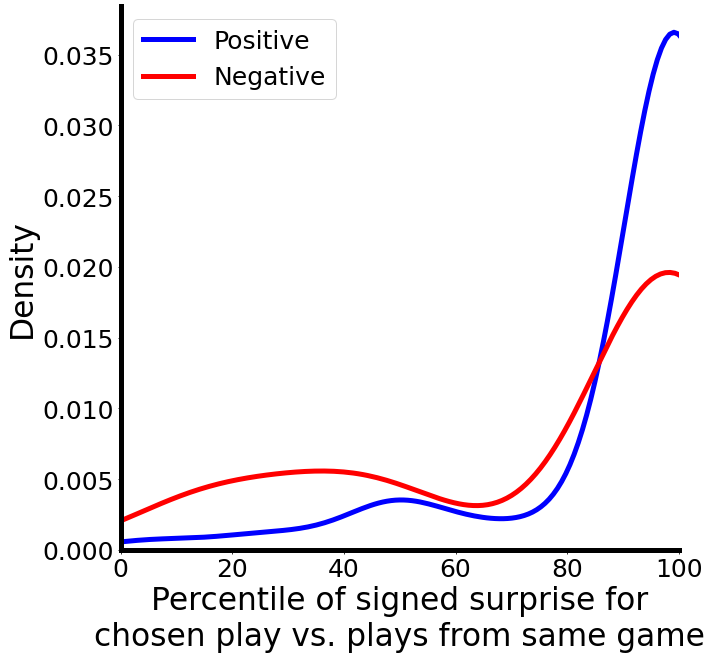

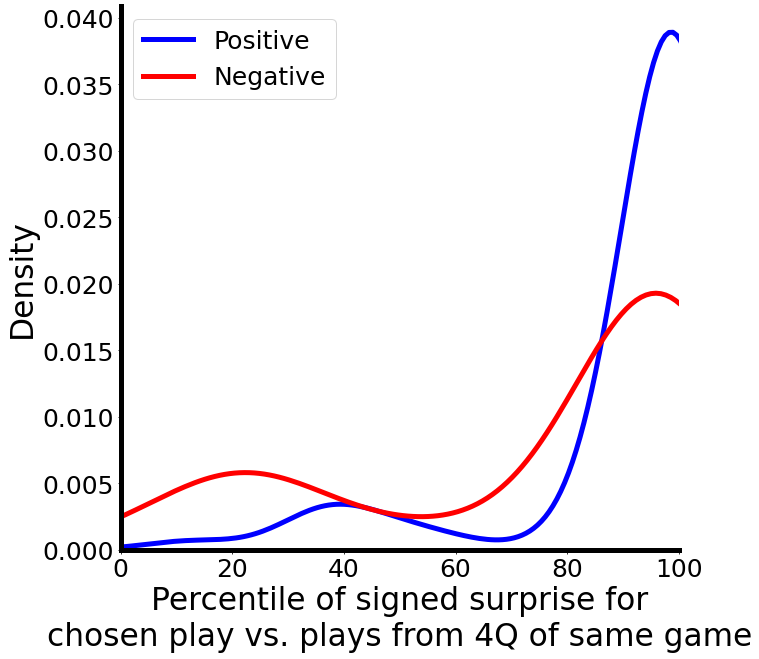

In [405]:
#kdeplotf(allsurs,perc_g_surp_abs,perc_g_surn_abs,'Surprise, all possessions',[0,100],'figs/recalltimes_play.pdf',0)
kdeplotf(perc_g_surp_abs,perc_g_surn_abs,[],'''Percentile of signed surprise for
chosen play vs. plays from same game''',[0,100],'figs/recalltimes_play.pdf',0)
kdeplotf(perc_g_surp_4q_abs,perc_g_surn_4q_abs,[],'''Percentile of signed surprise for
chosen play vs. plays from 4Q of same game''',[0,100],'figs/recalltimes_play_4q.pdf',0)

In [406]:
def barswarm(dp,dn,lab,yl,fn,exv):
    dat1=pd.DataFrame({'Condition':['Positive']*len(dp),lab:dp})
    dat2=pd.DataFrame({'Condition':['Negative']*len(dn),lab:dn})
    dat=dat1.append(dat2)
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    colors = ["blue", "red"] #"#FF0B04", "#4374B3"
    cp = sns.set_palette(sns.color_palette(colors))
    ax=sns.barplot(x=dat['Condition'],y=dat[lab],facecolor=(1, 1, 1, 0),errcolor=".2",
                   edgecolor=".2",palette=cp,saturation=1,linewidth=lw,capsize=.3)
    ax=sns.swarmplot(x=dat['Condition'],y=dat[lab],palette=cp,facecolor=None,size=msz)
    ax.set_ylabel(yl,fontsize=fs)
    ax.set_xlabel('Condition',fontsize=fs)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    if exv==0:
        ax.hlines(0,-0.5,1.5,color="black")
    elif exv==1:
        ax.tick_params(axis='x',labelsize=fs*4/5)
        ax.tick_params(axis='y',labelsize=fs*4/5)
        ax.set_yticks(np.linspace(1,4,4))
        ax.set_yticklabels(['Routine','Top 3/game','Top 10/week','Top 10/year'])
    elif exv==2:
        ax.tick_params(axis='x',labelsize=fs*4/5)
        ax.tick_params(axis='y',labelsize=fs*4/5)
        ax.set_yticks(np.linspace(1,4,4))
        ax.set_yticklabels(['Routine','''Good solo
performance or
hyped narrative''','''Performance
in top 10/week''','''Performance
in top 10/year'''])
    elif exv==3:
        ax.hlines(15.5,-0.5,1.5,colors='k', linestyles='dashed',linewidth=lw)
    f.tight_layout()
    f.savefig(fn, transparent=True)

/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


pos vs neg, stat = 3.0107046718071206, pval = 0.0033730300146956145
r-squared,both = 0.00843850583581971, pval = 0.3811653879375573
r-squared,positive = 0.011595658478823677, pval = 0.4813801503947981
r-squared,negative = 0.011168941450192376, pval = 0.474670753282297


(-0.2992241797593301,
 2.1288571116724895,
 0.47933175208189516,
 1.5011734116351931)

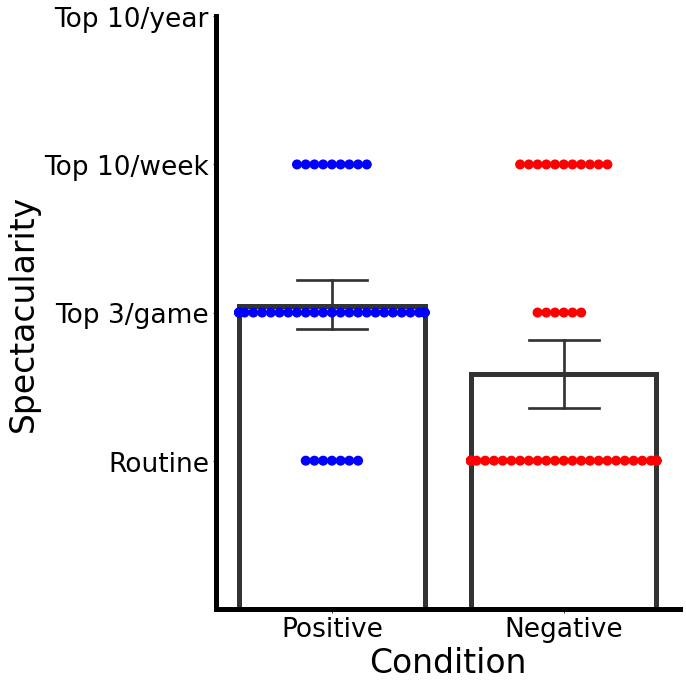

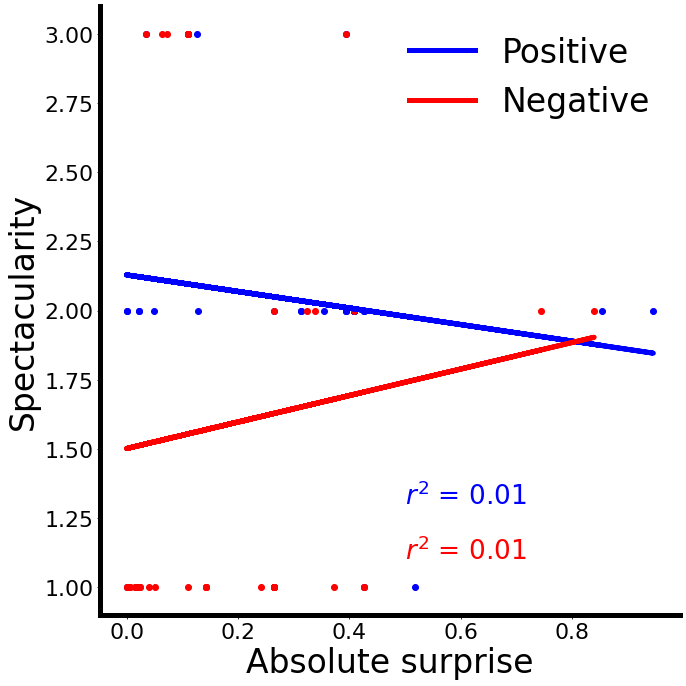

In [407]:
#spectacularity
ystr1,ybr1='relsur_a','Absolute surprise'
ystr2,ybr2='Spectacularity','Spectacularity'
qp=np.where(dfp[ystr2].isna()==0)[0]
qn=np.where(dfn[ystr2].isna()==0)[0]
x1,x2=np.absolute(dfp[ystr1].values),np.absolute(dfn[ystr1].values)
y1,y2=dfp[ystr2].values,dfn[ystr2].values

fn='figs/play_'+str(ystr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,1)

stat,pval=ttest_ind(y1[qp],y2[qn],nan_policy='omit')
print('pos vs neg, stat = %s, pval = %s' %(stat,pval))
corr, pval = pearsonr(np.hstack([x1[qp],x2[qn]]),np.hstack([y1[qp],y2[qn]]))
print('r-squared,both = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/play_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


pos vs neg, stat = 1.5479286095065234, pval = 0.12391329031514907
r-squared,positive = 0.007163407568559391, pval = 0.4925698881032142
r-squared,negative = 0.025852422435812254, pval = 0.17417420585825613


(-0.506377762139754, 3.291865429389866, -1.013797111592406, 3.0166041465332682)

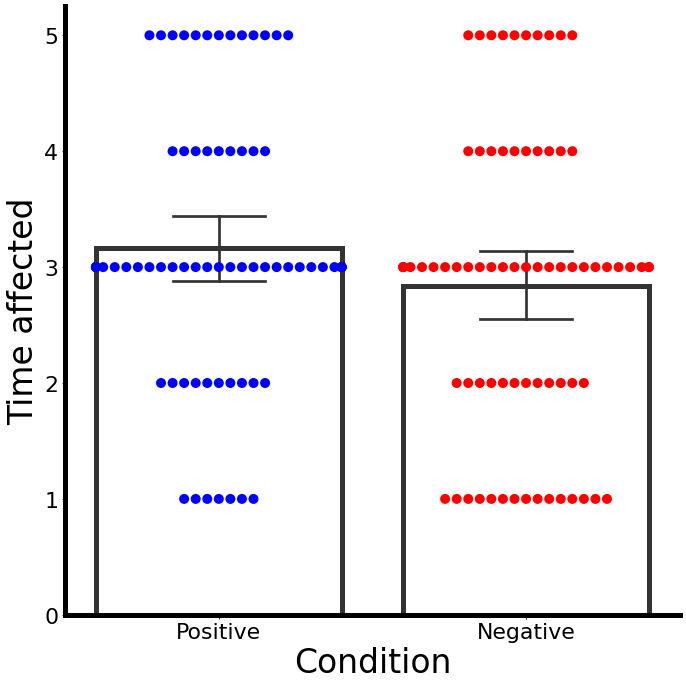

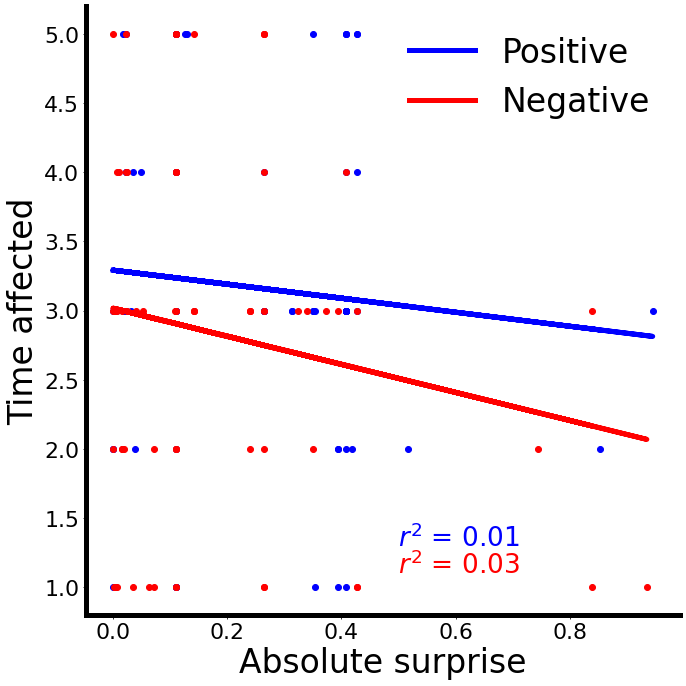

In [408]:
ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
qp=np.where(dfp[ystr2].isna()==0)[0]
qn=np.where(dfn[ystr2].isna()==0)[0]
#x1,x2=dfp[ystr1].values,dfn[ystr1].values
x1,x2=np.absolute(dfp[ystr1].values),np.absolute(dfn[ystr1].values)
y1,y2=dfp[ystr2].values,dfn[ystr2].values

fn='figs/play_'+str(ybr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,0)

stat,pval=ttest_ind(y1[qp],y2[qn],nan_policy='omit')
print('pos vs neg, stat = %s, pval = %s' %(stat,pval))
corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/play_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

# Game data

In [409]:
print('# pos entries: %s' %len(dfgp))
print('# neg entries: %s' %len(dfgn))

m_ind,d_ind=np.zeros((ngp)),np.zeros((ngp))
for i in range(ngp):
    m_ind[i]=dfgp['Month/date'][dfgp.index[i]][5:7]
    d_ind[i]=dfgp['Month/date'][dfgp.index[i]][8:10]
dfgp['month']=m_ind
dfgp['day']=d_ind
dfgp[['month','day','Year','home']] = dfgp[['month','day','Year','home']].astype(int)
m_ind,d_ind=np.zeros((ngn)),np.zeros((ngn))
for i in range(ngn):
    m_ind[i]=dfgn['Month/date'][dfgn.index[i]][5:7]
    d_ind[i]=dfgn['Month/date'][dfgn.index[i]][8:10]
dfgn['month']=m_ind
dfgn['day']=d_ind
dfgn[['month','day','Year','home']] = dfgn[['month','day','Year','home']].astype(int)

# pos entries: 77
# neg entries: 74


In [410]:
#find games!!!!!
gsursp_a,perc_s_surp,perc_s_surp_poffs=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngp))
gsursp_a_abs,perc_s_surp_abs,perc_into_szngp=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngp))
perc_s_surp_poffs_abs,gmaxsursp_a,gsursp_st_a=np.zeros((ngp)),np.zeros((ngp)),np.zeros((ngp))
gsursp_t_a=np.zeros((ngp))
for i in range(ngp):
    curr_y=dfgp['Year'][dfgp.index[i]] #match year
    q=np.where(df1['year']==curr_y)[0]
    curr_m=dfgp['month'][dfgp.index[i]] #match month
    qq=np.where(df1['month'][q]==curr_m)[0]
    curr_d=dfgp['day'][dfgp.index[i]] #match date
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    curr_ht=dfgp['home'][dfgp.index[i]] #match home team
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    print('Year, month, date, home:%s,%s,%s,%s' %(curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]] #dataframe representing full game
    gmaxsursp_a[i]=df1gt['maxsur'][df1gt.index[0]] #max PLAY surprise in game
    gsursp_st_a[i]=df1gt['hwp'][df1gt.index[-1]]-df1gt['hwp'][df1gt.index[0]] #game surprise end vs. start
    
    if df1gt['hwp'][df1gt.index[-1]]==1: #home team won
        gsursp_a[i]=1-df1gt['mwwp'][df1gt.index[0]] #relative comeback effect by the algorithm
        #use absolute here because there are some miniscule rounding errors
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-df1gt['mwwp'][df1gt.index[0]])<0.0001)[0]
    else:
        gsursp_a[i]=-(1-df1gt['mwwp'][df1gt.index[0]])
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-(1-df1gt['mwwp'][df1gt.index[0]]))<0.0001)[0]
    gsursp_t_a[i]=df1gt['sl'][df1gt.index[mwwpi[0]]] #time in game of moment furthest from comeback        
        
    gsursp_a_abs[i]=np.absolute(df1gt['mwwp'][df1gt.index[0]]) #abs comeback effect by the algorithm
    print('gsur, gmaxsur,gsur_st:%s,%s,%s' #    print('gsur, gmaxsur,gsur_st:%s,%s,%s,%s' #
          %(format(gsursp_a[i],".2f"), #,format(perc_g_surp[i],".2f")
            format(gmaxsursp_a[i],".2f"),format(gmaxsursp_a[i],".2f"))) 
    
    print('\n')
    #find % of way into season of games
    curr_g_id=df1gt['g_id'][df1gt.index[0]] #current game id
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    if curr_m>mthc: #if happens in early part of season
        szn=curr_y+0
    else:
        szn=curr_y-1 #if happens in late part
    #find games in early part of year
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl])
    ids_tszn=df1szn.g_id.unique()
    perc_into_szngp[i]=stats.percentileofscore(ids_tszn,curr_g_id)

Year, month, date, home:2015,1,23,9
rows, rows, rows, rows:362147,58278,2764,280
gsur, gmaxsur,gsur_st:0.31,0.20,0.20


Year, month, date, home:2008,6,17,2
rows, rows, rows, rows:330313,1470,257,257
gsur, gmaxsur,gsur_st:0.82,0.11,0.11


Year, month, date, home:2016,6,5,9
rows, rows, rows, rows:367236,1730,241,241
gsur, gmaxsur,gsur_st:0.49,0.09,0.09


Year, month, date, home:2015,1,23,9
rows, rows, rows, rows:362147,58278,2764,280
gsur, gmaxsur,gsur_st:0.31,0.20,0.20


Year, month, date, home:2018,11,19,25
rows, rows, rows, rows:358838,57070,2360,281
gsur, gmaxsur,gsur_st:0.61,0.14,0.14


Year, month, date, home:2016,12,5,9
rows, rows, rows, rows:367236,59347,2919,286
gsur, gmaxsur,gsur_st:0.19,0.06,0.06


Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


Year, month, date, home:2020,10,11,15
rows, rows, rows, rows:205965,1234,240,240
gsur, gmaxsur,gsur_st:-0.51,0.12,0.12


Year, month, date, home:2016,4,13,13
rows, 

Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


Year, month, date, home:2006,1,22,13
rows, rows, rows, rows:332820,56193,2272,264
gsur, gmaxsur,gsur_st:0.91,0.09,0.09


Year, month, date, home:2018,1,8,9
rows, rows, rows, rows:358838,54655,2057,255
gsur, gmaxsur,gsur_st:0.36,0.11,0.11


Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


Year, month, date, home:2015,6,16,5
rows, rows, rows, rows:362147,1540,264,264
gsur, gmaxsur,gsur_st:-0.60,0.13,0.13


Year, month, date, home:2018,6,8,5
rows, rows, rows, rows:358838,732,235,235
gsur, gmaxsur,gsur_st:-0.53,0.11,0.11


Year, month, date, home:2019,5,12,27
rows, rows, rows, rows:352368,7649,513,253
gsur, gmaxsur,gsur_st:0.71,0.39,0.39




In [411]:
gsursn_a,perc_s_surn,perc_s_surn_poffs=np.zeros((ngn)),np.zeros((ngn)),np.zeros((ngn))
gsursn_a_abs,perc_s_surn_abs,perc_into_szngn=np.zeros((ngn)),np.zeros((ngn)),np.zeros((ngn))
perc_s_surn_poffs_abs,gmaxsursn_a,gsursn_st_a=np.zeros((ngn)),np.zeros((ngn)),np.zeros((ngn))
gsursn_t_a=np.zeros((ngn))
for i in range(ngn):
    curr_y=dfgn['Year'][dfgn.index[i]] #match year
    q=np.where(df1['year']==curr_y)[0]
    curr_m=dfgn['month'][dfgn.index[i]] #match month
    qq=np.where(df1['month'][q]==curr_m)[0]
    curr_d=dfgn['day'][dfgn.index[i]] #match date
    qqq=np.where(df1['day'][q[qq]]==curr_d)[0]
    curr_ht=dfgn['home'][dfgn.index[i]] #match home team
    qqqq=np.where(df1['home'][q[qq[qqq]]]==curr_ht)[0]
    print('Year, month, date, home:%s,%s,%s,%s' %(curr_y,curr_m,curr_d,curr_ht))
    print('rows, rows, rows, rows:%s,%s,%s,%s' %(len(q),len(qq),len(qqq),len(qqqq)))
    df1gt=df1.iloc[q[qq[qqq[qqqq]]]] #dataframe representing full game
    gmaxsursn_a[i]=df1gt['maxsur'][df1gt.index[0]] #max PLAY surprise in game
    gsursn_st_a[i]=df1gt['hwp'][df1gt.index[-1]]-df1gt['hwp'][df1gt.index[0]] #game surprise end vs. start
    if df1gt['hwp'][df1gt.index[-1]]==1: #home team won
        gsursn_a[i]=1-df1gt['mwwp'][df1gt.index[0]] #relative game surprise by the algorithm
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-df1gt['mwwp'][df1gt.index[0]])<0.0001)[0]
        gsursn_t_a[i]=df1gt['sl'][df1gt.index[mwwpi[0]]]      
    else:
        gsursn_a[i]=-(1-df1gt['mwwp'][df1gt.index[0]])
        mwwpi=np.where(np.absolute(df1gt['hwp'][df1gt.index]-(1-df1gt['mwwp'][df1gt.index[0]]))<0.0001)[0]
        gsursn_t_a[i]=df1gt['sl'][df1gt.index[mwwpi[0]]]       
        
        
    gsursn_a_abs[i]=np.absolute(df1gt['mwwp'][df1gt.index[0]]) #abs game surprise by the algorithm
    print('gsur, gmaxsur,gsur_st:%s,%s,%s' #    print('gsur, gmaxsur,gsur_st:%s,%s,%s,%s' #
          %(format(gsursn_a[i],".2f"), #,format(perc_g_surp[i],".2f")
            format(gmaxsursn_a[i],".2f"),format(gmaxsursn_a[i],".2f"))) 
    print('\n')
    curr_g_id=df1gt['g_id'][df1gt.index[0]] #current game id
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    if curr_m>mthc: #if happens in early part of season
        szn=curr_y+0
    else:
        szn=curr_y-1 #if happens in late part
    #find games in early part of year
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn),df1['month']>mthc))[0]
    df1szne=df1.iloc[q] 
    q=np.where(np.logical_and(np.logical_and(np.logical_or(df1['home']==curr_ht,df1['vis']==curr_ht),
                                             df1['year']==szn+1),df1['month']<mthc))[0]
    df1sznl=df1.iloc[q]
    df1szn=pd.concat([df1szne,df1sznl]) #df of all updates in this season!
    ids_tszn=df1szn.g_id.unique()
    perc_into_szngn[i]=stats.percentileofscore(ids_tszn,curr_g_id)

Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


Year, month, date, home:2019,6,13,9
rows, rows, rows, rows:352368,1274,260,260
gsur, gmaxsur,gsur_st:-0.75,0.19,0.19


Year, month, date, home:2020,9,30,13
rows, rows, rows, rows:205965,9067,248,248
gsur, gmaxsur,gsur_st:0.68,0.09,0.09


Year, month, date, home:2020,9,27,15
rows, rows, rows, rows:205965,9067,247,247
gsur, gmaxsur,gsur_st:0.70,0.12,0.12


Year, month, date, home:2020,1,12,14
rows, rows, rows, rows:205965,57836,1820,285
gsur, gmaxsur,gsur_st:0.42,0.09,0.09


Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


Year, month, date, home:2016,6,19,9
rows, rows, rows, rows:367236,1730,236,236
gsur, gmaxsur,gsur_st:-0.84,0.18,0.18


Year, month, date, home:2019,3,22,13
rows, rows, rows, rows:352368,58546,1811,282
gsur, gmaxsur,gsur_st:-0.64,0.14,0.14


Year, month, date, home:2020,7,31,26
rows, 

Year, month, date, home:2013,6,18,15
rows, rows, rows, rows:359216,2153,269,269
gsur, gmaxsur,gsur_st:0.99,0.43,0.43


Year, month, date, home:2021,6,19,1
rows, rows, rows, rows:283261,11247,268,268
gsur, gmaxsur,gsur_st:-0.83,0.35,0.35


Year, month, date, home:2019,6,13,9
rows, rows, rows, rows:352368,1274,260,260
gsur, gmaxsur,gsur_st:-0.75,0.19,0.19




pos mean = 79.46720182316437 + 3.179584861450557, neg mean = 91.78515411899998 + 2.1114090160133188
times pos v neg, stat = -3.1801971066384738, pval = 0.00179069966107984,df = 149


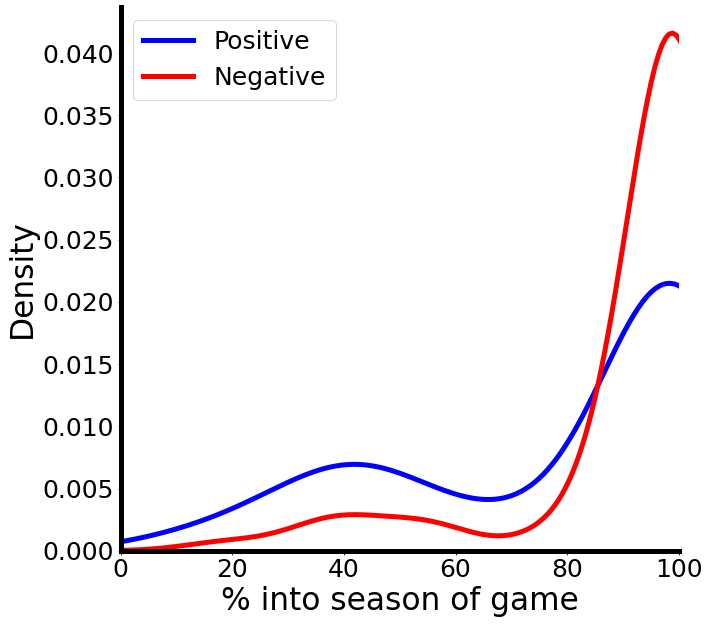

In [412]:
x,y=perc_into_szngp+0,perc_into_szngn+0
stat,pval=ttest_ind(x,y,nan_policy='omit')
print('pos mean = %s + %s, neg mean = %s + %s' %(np.mean(x),np.std(x)/np.sqrt(ngp),np.mean(y),np.std(y)/np.sqrt(ngn)))
print('times pos v neg, stat = %s, pval = %s,df = %s' %(stat,pval,len(x)+len(y)-2))

kdeplotf(x,y,[],'% into season of game',[0,100],'figs/game_perc_into_szn.pdf',0)

(0.8330280049450958,
 0.10735511768251353,
 1.1081326400562843,
 0.048294426667860046)

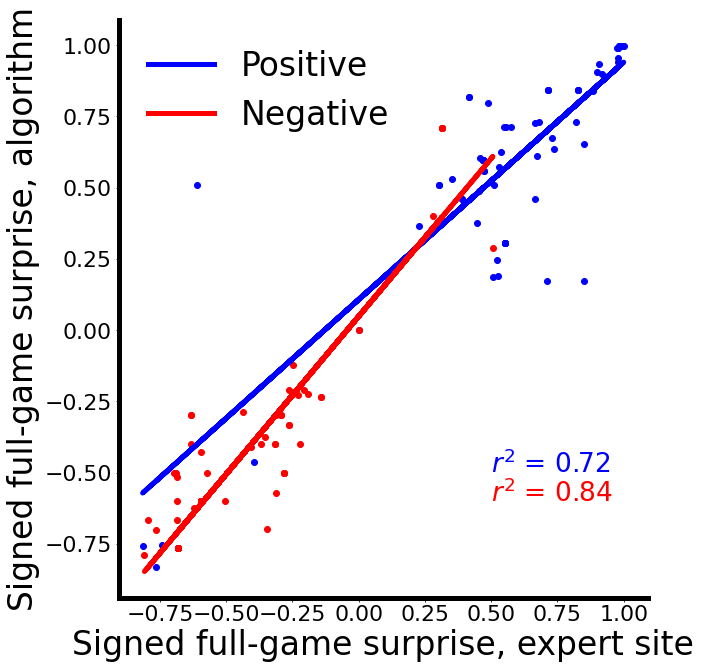

In [413]:
chvp=np.zeros((ngp))
for i in range(ngp):
    if int(dfgp['Cheering for? (1=H,-1=V)'][dfgp.index[i]])==1:
        chvp[i]=1
    elif int(dfgp['Cheering for? (1=H,-1=V)'][dfgp.index[i]])==-1:
        chvp[i]=-1
dfgp['chv']=chvp
chvn=np.zeros((ngn)) #fix quick thing with cheering for being strings / inconvertible to int quickly
for i in range(ngn):
    if int(dfgn['Cheering for? (1=H,-1=V)'][dfgn.index[i]])==1:
        chvn[i]=1
    elif int(dfgn['Cheering for? (1=H,-1=V)'][dfgn.index[i]])==-1:
        chvn[i]=-1
dfgn['chv']=chvn

dfgp['relcbsur_a']=np.multiply(gsursp_a,dfgp['chv'].values) #relative surprise by algorithm
dfgn['relcbsur_a']=np.multiply(gsursn_a,dfgn['chv'].values)
dfgp['relgsur_a']=np.multiply(gsursp_st_a,dfgp['chv'].values) #post- minus pre-game surprise by algorithm
dfgn['relgsur_a']=np.multiply(gsursn_st_a,dfgn['chv'].values)

#check algo vs expert
scatterp(dfgp['Comeback via website (if NBA/WNBA)']/100,dfgp['relcbsur_a'],
        dfgn['Relative surprise (game-level)']/100,dfgn['relgsur_a'],
        'Signed full-game surprise, expert site','Signed full-game surprise, algorithm',
        'figs/game_fullgame_algoVexpert.pdf',0)

(0.853841927663037,
 0.10719319839465802,
 0.9883486876040508,
 -0.022160767793215522)

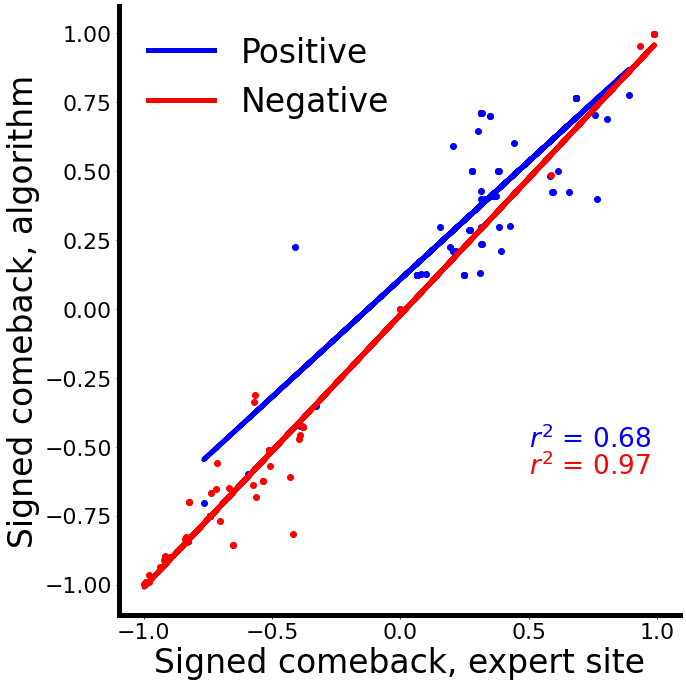

In [414]:
scatterp(dfgp['Relative surprise (game-level)']/100,dfgp['relgsur_a'],
        dfgn['Comeback via website (if NBA/WNBA)']/100,dfgn['relcbsur_a'],
        'Signed comeback, expert site','Signed comeback, algorithm',
        'figs/game_cb_algoVexpert.pdf',0)

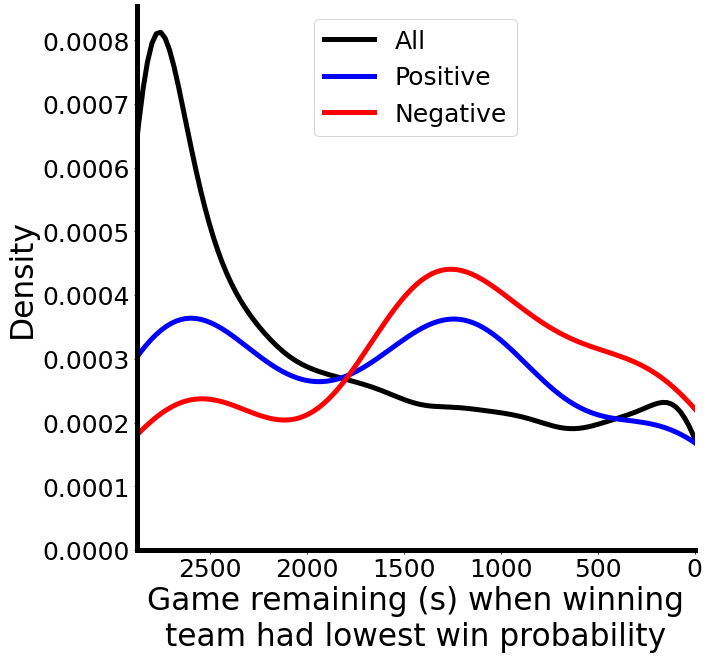

GR, pos, stat = 2.002157774790077, pval = 0.04527968512785735
GR, neg, stat = 4.66237643550696, pval = 3.1436355146523692e-06
GR, pos vs. neg, stat = 1.9968439098786341, pval = 0.04766347225476225


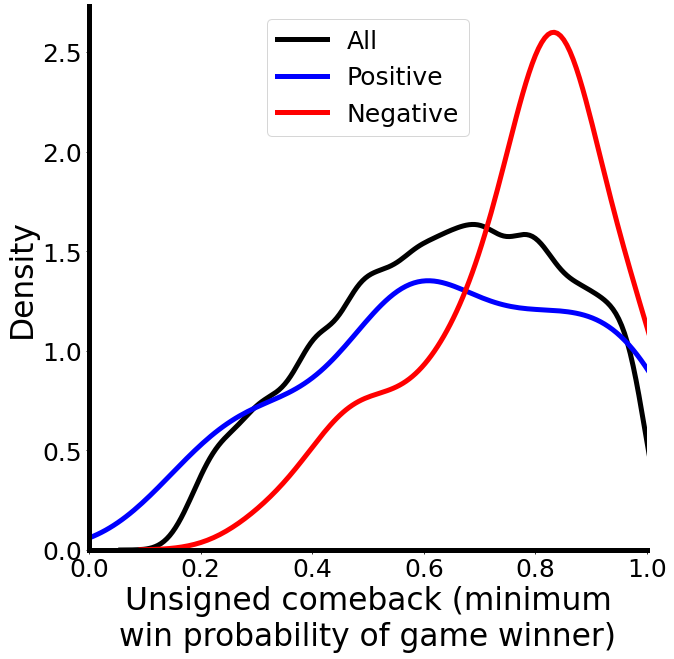

cb, pos, stat = [0.39450152], pval = [0.69321452]
cb, neg, stat = [5.17100529], pval = [2.348212e-07]
cb, pos vs. neg, stat = 3.3258892833829408, pval = 0.0011098741983274199


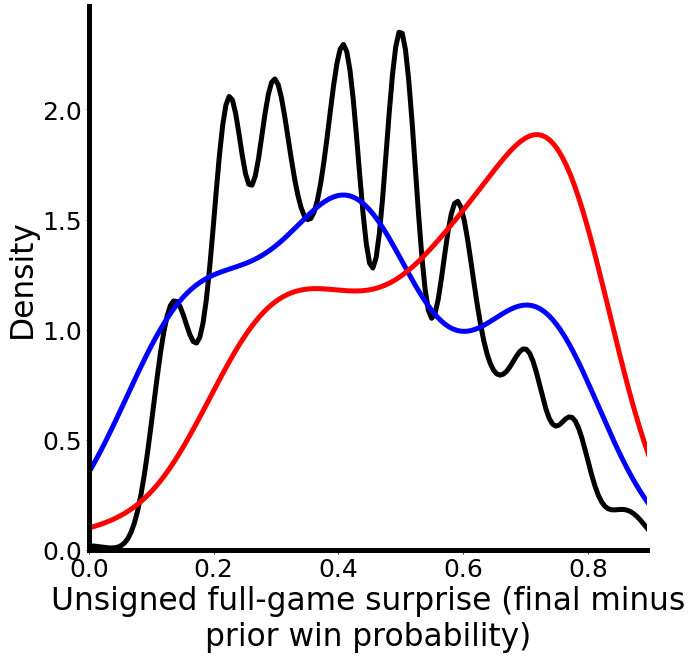

full game, pos, stat = -0.12495780111573379, pval = 0.9005580689583852
full game, neg, stat = 40.60531105786445, pval = 0.0
full game, pos vs. neg, stat = -3.41385414296003, pval = 0.0008251855297785069


In [415]:
## next also calculate based on GAME surprise, not within-game
# need to calculate the base rate of these two
expert_algo=2 #1=use expert #s, 2=use algorithm
if expert_algo==1:
    cbsp,cbsn=dfgp['Comeback via website (if NBA/WNBA)'],dfgn['Comeback via website (if NBA/WNBA)']
    cbsp,cbsn=1-cbsp/100,1-cbsn/100 #normalize - put in same space as other data
    fgsp,fgsp=dfgp['Absolute surprise (game-level)'],dfgn['Absolute surprise (game-level)']
elif expert_algo==2:
    cbsp,cbsn=gsursp_a_abs+0,gsursn_a_abs+0
    fgsp,fgsn=dfgp['relgsur_a'],dfgn['relgsur_a']

#need to grab this null distribution!!
kdeplotf(mwwp_ts[:,0],gsursp_t_a,gsursn_t_a,'''Game remaining (s) when winning
team had lowest win probability''',[t_sec,0],
         'figs/game_comeback_times.pdf',4)

stat,pval=ttest_ind(mwwp_ts[:,0],gsursp_t_a,nan_policy='omit')
print('GR, pos, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(mwwp_ts[:,0],gsursn_t_a,nan_policy='omit')
print('GR, neg, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(gsursp_t_a,gsursn_t_a,nan_policy='omit')
print('GR, pos vs. neg, stat = %s, pval = %s' %(stat,pval))


kdeplotf(1-mwwps[:,0],1-cbsp,1-cbsn,'''Unsigned comeback (minimum
win probability of game winner)''',[0,1],
         'figs/game_comeback_abs.pdf',4)

stat,pval=ttest_ind(mwwps,cbsp,nan_policy='omit')
print('cb, pos, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(mwwps,cbsn,nan_policy='omit')
print('cb, neg, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(cbsp,cbsn,nan_policy='omit')
print('cb, pos vs. neg, stat = %s, pval = %s' %(stat,pval))

kdeplotf(1-fwwps[:,0],np.absolute(fgsp),np.absolute(fgsn),'''Unsigned full-game surprise (final minus
prior win probability)''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs.pdf',5)

stat,pval=ttest_ind(1-fwwps[:,0],np.absolute(fgsp),nan_policy='omit')
print('full game, pos, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(1-fwwps[:,0],fgsn,nan_policy='omit')
print('full game, neg, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(np.absolute(fgsp),np.absolute(fgsn),nan_policy='omit')
print('full game, pos vs. neg, stat = %s, pval = %s' %(stat,pval))

<ipython-input-416-3ba397e722f0>:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elatdepp=np.array(elatdepp, dtype=[('O', np.float)]).astype(np.float) #fix odd data issue


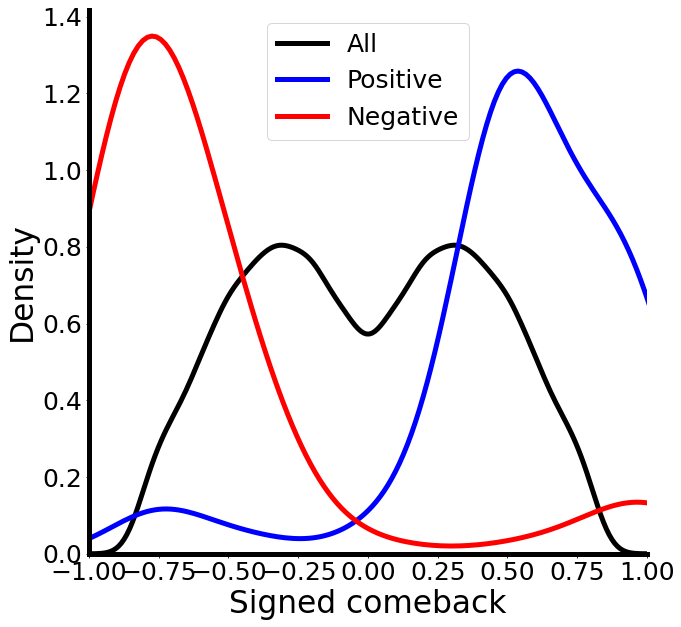

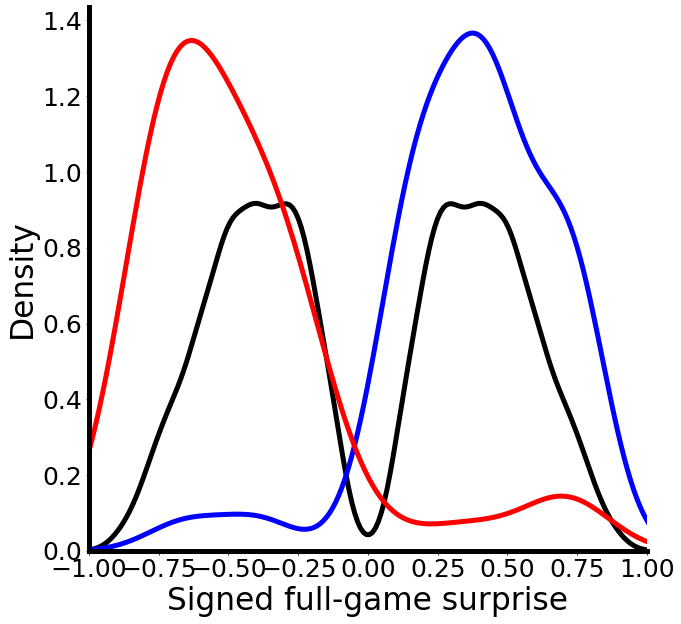

In [416]:
#max-min home
winnerp0=dfgp['Home WP after game (0/100)']
winnerp=winnerp0+0
winnerp[winnerp0==100]=1
winnerp[winnerp0==0]=-1
winnern0=dfgn['Home WP after game (0/100)']
winnern=winnern0+0
winnern[winnern0==100]=1
winnern[winnern0==0]=-1

maxminhomep=dfgp['Max Home WP within game (_ or 100)']-dfgp['Min Home WP (_ or 0)']
elatdepp=np.multiply(np.multiply(np.multiply(maxminhomep,dfgp['Cheering for? (1=H,-1=V)']),
                     winnerp),0.01)
maxminhomen=dfgn['Max Home WP within game (_ or 100)']-dfgn['Min Home WP (_ or 0)']
elatdepn=np.multiply(np.multiply(np.multiply(maxminhomen,dfgn['Cheering for? (1=H,-1=V)']),
                                 winnern),0.01)
elatdepp=elatdepp.values
elatdepp=np.array(elatdepp, dtype=[('O', np.float)]).astype(np.float) #fix odd data issue
#elatdepp=elatdepp.astype(float64)
elatdepn=elatdepn.values

#for all games dist, imagine that each team is cheered for in each game exactly once
rel_mwwps=np.hstack([mwwps[:,0],-mwwps[:,0]])
kdeplotf(rel_mwwps,elatdepp,elatdepn,'Signed comeback',[-1,1],'figs/game_comeback_valence.pdf',4)

rel_fwwps=np.hstack([1-fwwps[:,0],-(1-fwwps[:,0])])

#for post- minus pre-gamefull-game surprise
kdeplotf(rel_fwwps,dfgp['relgsur_a'],dfgn['relgsur_a'],'Signed full-game surprise',[-1,1],'figs/game_fullgame_valence.pdf',5)

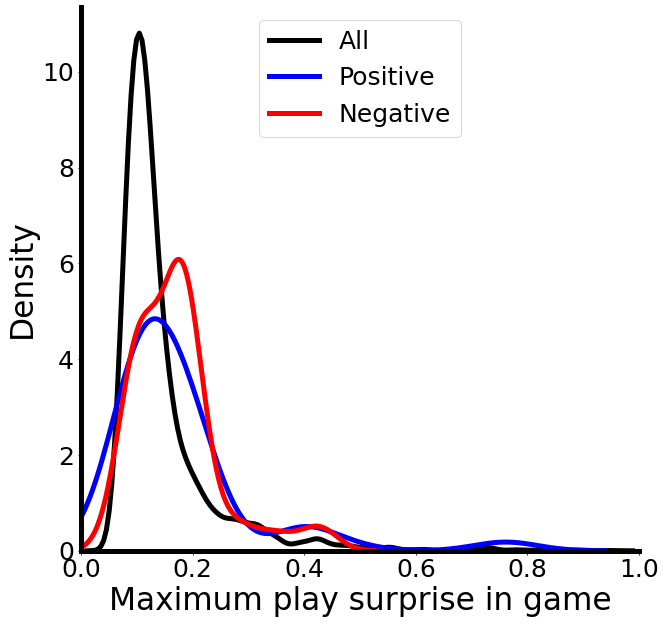

pos, stat = -3.0084965596520585, pval = 0.0026283269642566843
neg, stat = -2.3307522770115434, pval = 0.019775172250513843
adj, pos, stat = 0.48625612839103244, pval = 0.6267902938976015
adj, neg, stat = -0.7991109010306089, pval = 0.4242345050444506


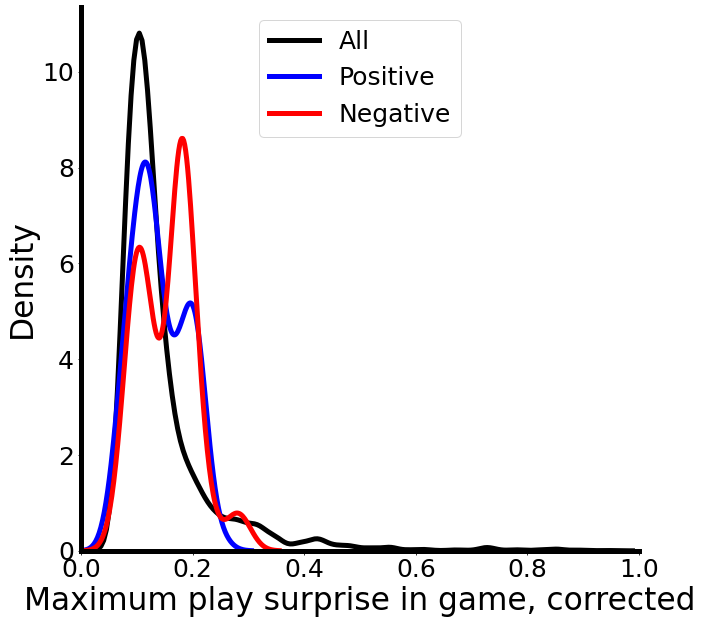

In [417]:
#max surprise play - is higher in chosen games
kdeplotf(maxsurs[:,0],gmaxsursp_a,gmaxsursn_a,'Maximum play surprise in game',[0,1],
         'figs/game_max_play_sur_pn.pdf',4)
stat,pval=ttest_ind(maxsurs[:,0],gmaxsursp_a,nan_policy='omit')
print('pos, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(maxsurs[:,0],gmaxsursn_a,nan_policy='omit')
print('neg, stat = %s, pval = %s' %(stat,pval))

#BUT if we adjust this ignore values of high max surprise
coff=np.mean(maxsurs[:,0])+1.645*np.std(maxsurs[:,0]) #1.645 - keep middle 90% of data (or lower 95%)
lcoff=np.mean(maxsurs[:,0])-1.645*np.std(maxsurs[:,0])
q0=np.where(np.logical_and(gmaxsursp_a<coff,gmaxsursp_a>lcoff))[0]
stat,pval=ttest_ind(maxsurs[:,0],gmaxsursp_a[q0],nan_policy='omit')
print('adj, pos, stat = %s, pval = %s' %(stat,pval))
q1=np.where(np.logical_and(gmaxsursn_a<coff,gmaxsursn_a>lcoff))[0]

stat,pval=ttest_ind(maxsurs[:,0],gmaxsursn_a[q1],nan_policy='omit')
print('adj, neg, stat = %s, pval = %s' %(stat,pval))
kdeplotf(maxsurs[:,0],gmaxsursp_a[q0],gmaxsursn_a[q1],'Maximum play surprise in game, corrected',[0,1],
         'figs/game_max_play_sur_pn_corr.pdf',4)

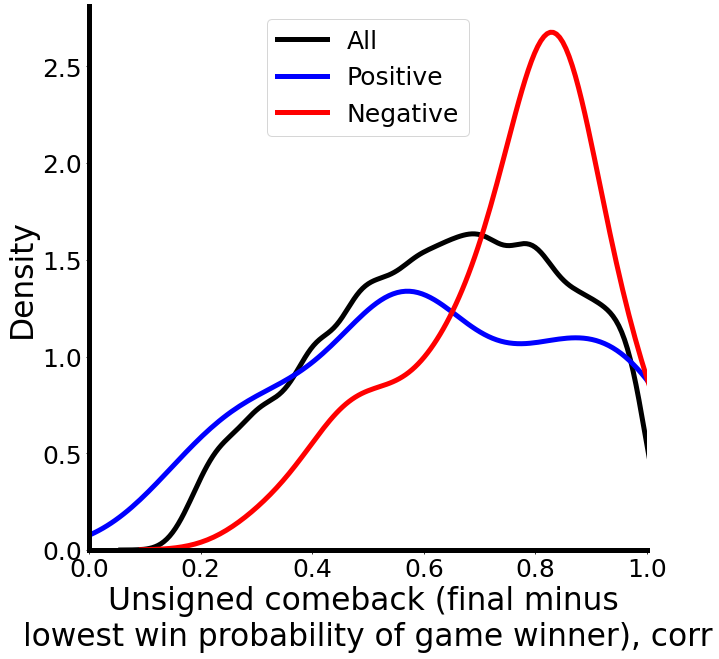

adj, abs comeback pos, stat = [-0.26043242], pval = [0.79453261]
adj, abs comeback neg, stat = [4.44233923], pval = [8.94082737e-06]
adj, abs comeback pos vs. neg, stat = 3.2056617338503552, pval = 0.0016795854874811335


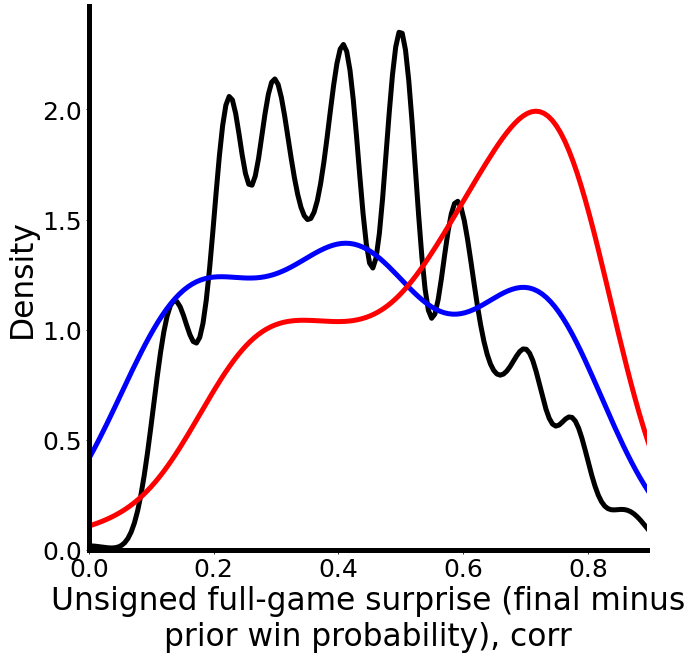

adj, full game, pos, stat = [-0.36385979], pval = [0.71596611]
adj, full game, neg, stat = [-5.87946249], pval = [4.17385657e-09]
adj, full game, pos vs. neg, stat = -3.277394278708993, pval = 0.0013299200970558062


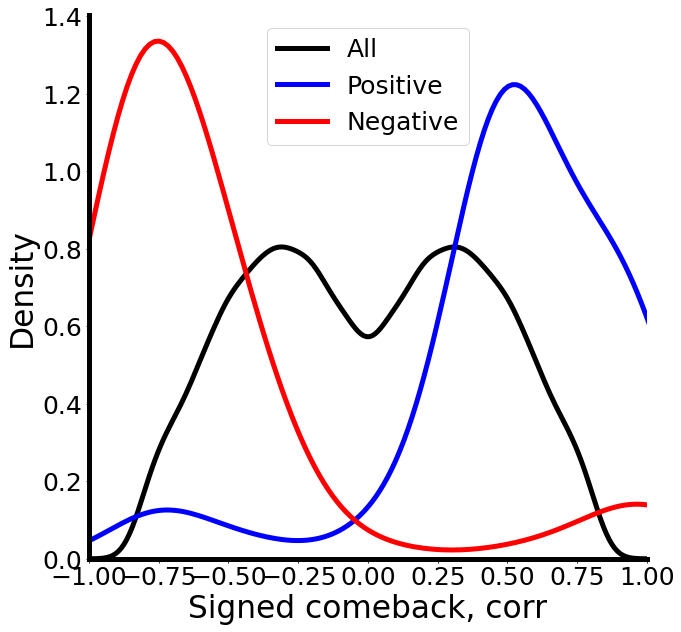

adj, rel pos, stat = -10.378167450023442, pval = 3.327425950158643e-25
adj, rel neg, stat = 11.196974516823467, pval = 4.608276398919081e-29
adj, rel pos vs. neg, stat = 14.043233870504823, pval = 3.031986192440184e-28


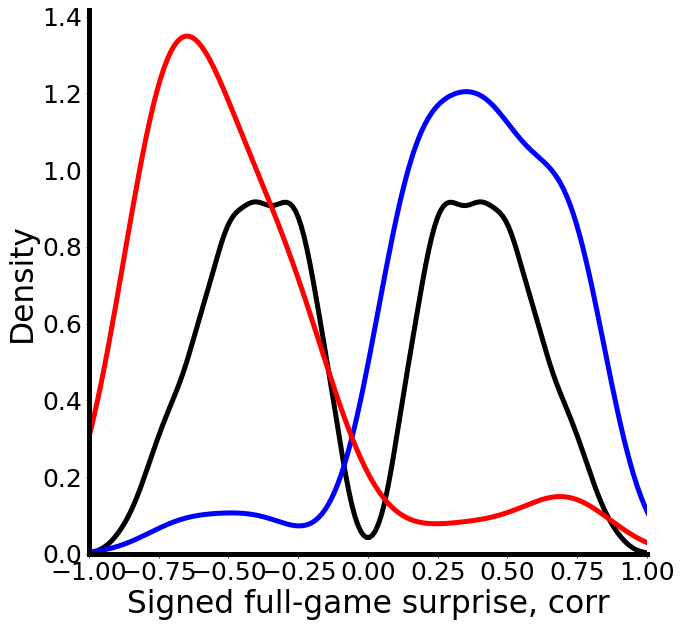

In [418]:
fgsp=fgsp.values
fgsn=fgsn.values

#look for mwwp contrasts with only these values!
kdeplotf(1-mwwps[:,0],1-cbsp[q0],1-cbsn[q1],'''Unsigned comeback (final minus 
lowest win probability of game winner), corr''',[0,1],
         'figs/game_comeback_abs_adj.pdf',4)

stat,pval=ttest_ind(mwwps,cbsp[q0],nan_policy='omit')
print('adj, abs comeback pos, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(mwwps,cbsn[q1],nan_policy='omit')
print('adj, abs comeback neg, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(cbsp[q0],cbsn[q1],nan_policy='omit')
print('adj, abs comeback pos vs. neg, stat = %s, pval = %s' %(stat,pval))

kdeplotf(1-fwwps[:,0],np.absolute(fgsp[q0]),np.absolute(fgsn[q1]),
         '''Unsigned full-game surprise (final minus
prior win probability), corr''',[0,max(1-fwwps)],
         'figs/game_fullgamesurprise_abs_adj.pdf',5)

stat,pval=ttest_ind(1-fwwps,np.absolute(fgsp[q0]),nan_policy='omit')
print('adj, full game, pos, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(1-fwwps,np.absolute(fgsn[q1]),nan_policy='omit')
print('adj, full game, neg, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(np.absolute(fgsp[q0]),np.absolute(fgsn[q1]),nan_policy='omit')
print('adj, full game, pos vs. neg, stat = %s, pval = %s' %(stat,pval))

kdeplotf(rel_mwwps,elatdepp[q0],elatdepn[q1],'Signed comeback, corr',[-1,1],'figs/game_comeback_valence_adj.pdf',4)

stat,pval=ttest_ind(rel_mwwps,elatdepp[q0],nan_policy='omit')
print('adj, rel pos, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(rel_mwwps,elatdepn[q1],nan_policy='omit')
print('adj, rel neg, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(elatdepp[q0],elatdepn[q1],nan_policy='omit')
print('adj, rel pos vs. neg, stat = %s, pval = %s' %(stat,pval))

#for post- minus pre-game surprise
ptemp,ntemp=dfgp['relgsur_a'].values,dfgn['relgsur_a'].values
kdeplotf(rel_fwwps,ptemp[q0],ntemp[q1],'Signed full-game surprise, corr',[-1,1],'figs/game_comeback_valence_adj.pdf',5)

/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 25.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


pos vs neg, stat = 6.312558947402151, pval = 3.7936833737390164e-09
r-squared,positive = 0.00014389158095890468, pval = 0.9268944669592821
r-squared,negative = 0.07182087369056464, pval = 0.02096986159403054


/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


pos vs neg, stat = 0.9602979005867202, pval = 0.3384610393538947
r-squared,positive = 0.015251862596729128, pval = 0.2845870064849986
r-squared,negative = 0.0003924136993909234, pval = 0.8669589674417121


(0.4873007667293471,
 3.30041316996347,
 0.061909520316595294,
 3.3248806746603004)

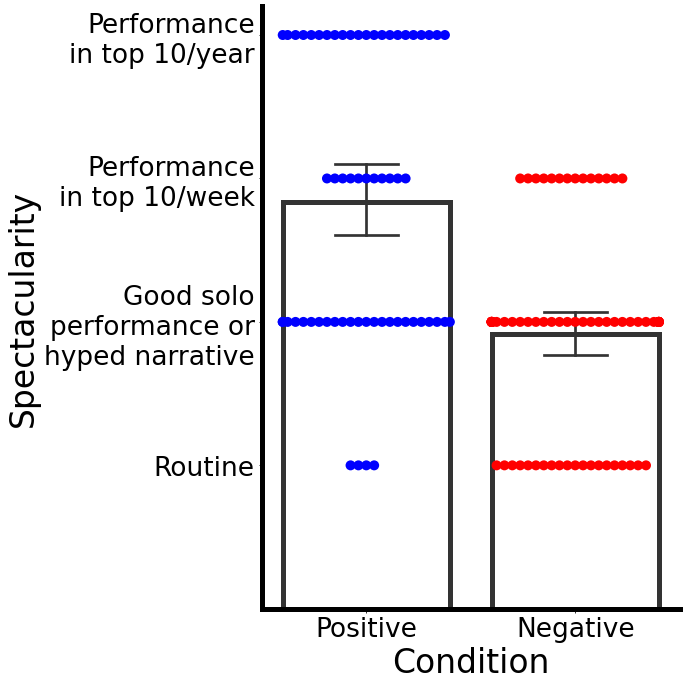

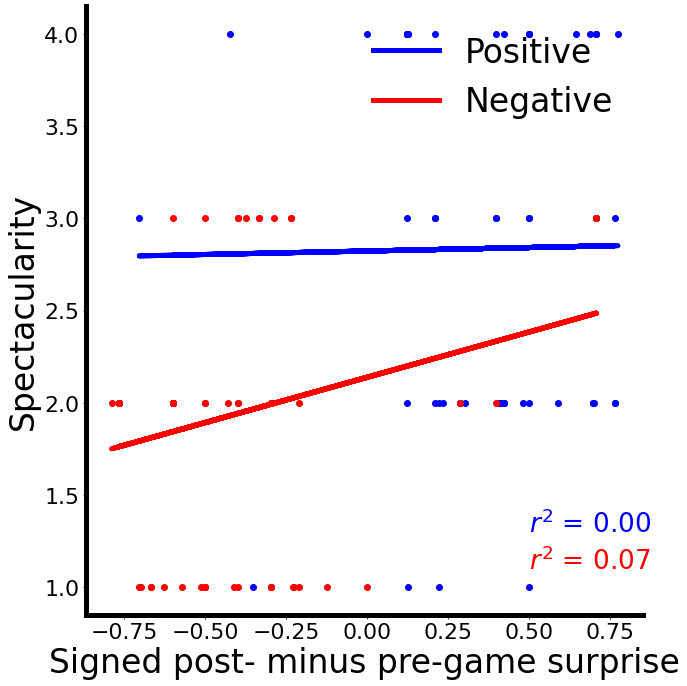

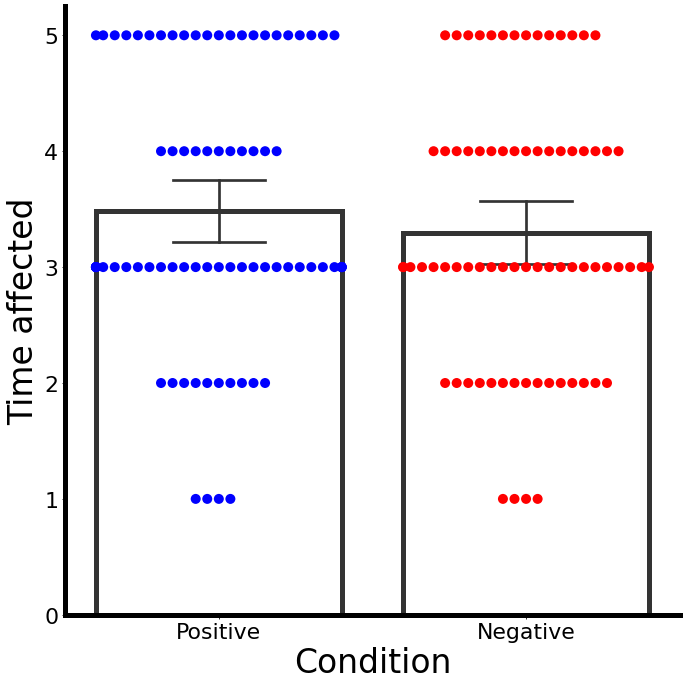

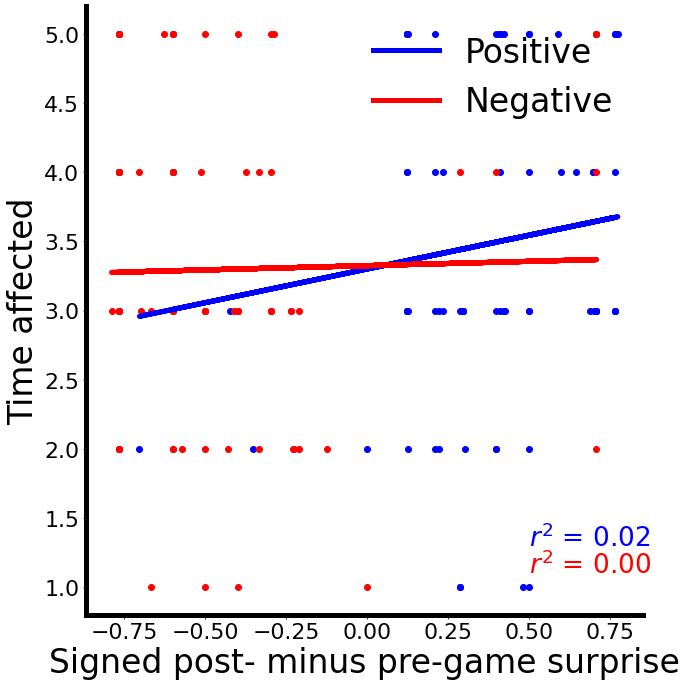

In [419]:
#spectacularity
ystr1,ybr1='relgsur_a','Signed post- minus pre-game surprise'
ystr2,ybr2='Spectacularity of game?','Spectacularity'
qp=np.where(dfgp[ystr2].isna()==0)[0]
qn=np.where(dfgn[ystr2].isna()==0)[0]
x1,x2=dfgp[ystr1].values,dfgn[ystr1].values
y1,y2=dfgp[ystr2].values,dfgn[ystr2].values

fn='figs/game_'+str(ystr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,2)

stat,pval=ttest_ind(y1[qp],y2[qn],nan_policy='omit')
print('pos vs neg, stat = %s, pval = %s' %(stat,pval))
corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/game_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

#time affected
ystr1,ybr1='relgsur_a','Signed post- minus pre-game surprise'
ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
qp=np.where(dfgp[ystr2].isna()==0)[0]
qn=np.where(dfgn[ystr2].isna()==0)[0]
x1,x2=dfgp[ystr1].values,dfgn[ystr1].values
y1,y2=dfgp[ystr2].values,dfgn[ystr2].values

fn='figs/game_'+str(ybr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,0)

stat,pval=ttest_ind(y1[qp],y2[qn],nan_policy='omit')
print('pos vs neg, stat = %s, pval = %s' %(stat,pval))
corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp],y1[qp],x2[qn],y2[qn],ybr1,ybr2,'figs/game_'+str(ystr1)+'_'+str(ystr2)+'.pdf',1)

# season data

In [420]:
print('# pos entries: %s' %len(dfsp))
print('# neg entries: %s' %len(dfsn))

#first, find starting year from Year
sp_year,sn_year=np.zeros((nsp)),np.zeros((nsn))
for i in range(nsp):
    sp_year[i]=dfsp['Year'][dfsp.index[i]][:4]
for i in range(nsn):
    sn_year[i]=dfsn['Year'][dfsn.index[i]][:4]
dfsp['syear'],dfsn['syear']=sp_year,sn_year
#find team's record and odds beforehand
nots=len(df_ots) #same length as df_svr

# pos entries: 96
# neg entries: 47


In [421]:
#find maximum play, full- and within-game surprises during this season
inds=[]
mxmxsurs,mxfgsurs,mxwgsurs=np.zeros((nots)),np.zeros((nots)),np.zeros((nots))
for i in range(nots): #don't use most current year, don't have pbp
    curr_y=df_svr['Starting year'][i] #find year
    s=df_svr['Team'][i] #find team index
    for ii in range(len(nba3)):
        if s == nba3[ii]:
            ix=ii+0
            break
    #find all games with this year / team 
    if curr_y!=2020: #not bubble year
        mthc=8 #month cutoff
    else:
        mthc=11 #month cutoff
    qq=np.where(np.logical_and(np.logical_or(df1['home']==ix,df1['vis']==ix),
                               np.logical_or(np.logical_and(df1['year']==curr_y,df1['month']>mthc),
                                   np.logical_and(df1['year']==curr_y+1,df1['month']<mthc))))[0]
    dfq=df1.iloc[qq]
    gids=dfq.g_id.unique()
    maxsurs,maxfgsurs,maxwgsurs=np.zeros((len(gids))),np.zeros((len(gids))),np.zeros((len(gids)))
    for ii in range(len(gids)):
        qq=np.where(dfq['g_id']==gids[ii])[0]
        maxsurs[ii]=dfq['maxsur'][dfq.index[qq[0]]]
        maxfgsurs[ii]=dfq['fgsur'][dfq.index[qq[0]]]
        maxwgsurs[ii]=dfq['wgsur'][dfq.index[qq[0]]]
    mxmxsurs[i]=np.max(np.absolute(maxsurs))
    mxfgsurs[i]=np.max(np.absolute(maxfgsurs))
    mxwgsurs[i]=np.max(np.absolute(maxwgsurs))
    if i%200==0:
        print('progress:',i)
    
df_svr['mxmxsur']=mxmxsurs #add back to dataframe
df_svr['mxfgsur']=mxfgsurs
df_svr['mxwgsur']=mxwgsurs

progress: 0
progress: 200
progress: 400


In [422]:
#rank-ordered "season success" variable rather than win %
years=df_ots['Starting year'].unique()
rank_ys,pre_ranks=np.zeros((len(years),len(nba3))),np.zeros((len(years),len(nba3)))
tnop,t1r,t2r,t3r=14,8,4,2 #teams that miss the playoffs, make only 1st, 2nd, 3rd
for i in range(len(years)):
    #non-playoff teams
    q=np.where(df_ots['Starting year']==years[i])[0]
    rank_y=sss.rankdata(df_svr['Win %'][q])
    #teams making 1st round only
    q0=np.where(np.logical_and(df_ots['P1'][q]>-100000,df_ots['P2'][q].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[q0]])
    rank_y[q0]=tnop+rank_temp #add to main index
    qq=np.where(df_ots['P2'][q]>-100000)[0]
    #teams making 2nd round only
    qq0=np.where(np.logical_and(df_ots['P2'][q[qq]]>-100000,df_ots['P3'][q[qq]].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[qq[qq0]]])
    rank_y[qq[qq0]]=tnop+t1r+rank_temp
    qqq=np.where(df_ots['P3'][q[qq]]>-100000)[0]
    #teams making 3rd round only
    qqq0=np.where(np.logical_and(df_ots['P3'][q[qq[qqq]]]>-100000,df_ots['P4'][q[qq[qqq]]].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[qq[qqq[qqq0]]]])
    rank_y[qq[qqq[qqq0]]]=tnop+t1r+t2r+rank_temp
    #team losing championship
    qqqq=np.where(df_ots['P4'][q[qq[qqq]]]>-100000)[0]
    qqqq0=np.where(np.logical_and(df_ots['P4'][q[qq[qqq[qqqq]]]]>-100000,
                                  df_ots['Champ'][q[qq[qqq[qqqq]]]].isna()))[0]
    rank_temp=sss.rankdata(df_svr['Win %'][q[qq[qqq[qqqq[qqqq0]]]]])
    rank_y[qq[qqq[qqqq[qqqq0]]]]=tnop+t1r+t2r+t3r+rank_temp
    qqqqq=np.where(df_ots['Champ'][q[qq[qqq[qqqq]]]]=='** WINNER **')[0]
    rank_y[qq[qqq[qqqq[qqqqq]]]]=30
    #print(rank_y)
    rank_ys[i,:]=len(nba3)+1-rank_y #reverse these for final rankings (so #1 is best)
    #also do pre_odds rank (rather than as odds)
    pre_ranks[i,:]=sss.rankdata(df_ots['Pre3'].values[q])

In [423]:
low_odds,hi_odds=np.zeros((nots)),np.zeros((nots))
for i in range(nots):
    low_odds[i]=np.nanmax([np.nanmax([np.nanmax([np.nanmax([np.nanmax([np.nanmax([np.nanmax([np.nanmax(
        [np.nanmax([np.nanmax([np.nanmax([np.nanmax([df_ots['Pre1'][i],df_ots['Pre2'][i]]),
        df_ots['Pre3'][i]]),df_ots['S1'][i]]),df_ots['S2'][i]]),df_ots['S3'][i]]),df_ots['S4'][i]]),
        df_ots['S5'][i]]),df_ots['S6'][i]]),df_ots['P1'][i]]),df_ots['P2'][i]]),df_ots['P3'][i]]),
        df_ots['P4'][i]])
    hi_odds[i]=np.nanmin([np.nanmin([np.nanmin([np.nanmin([np.nanmin([np.nanmin([np.nanmin([np.nanmin(
        [np.nanmin([np.nanmin([np.nanmin([np.nanmin([df_ots['Pre1'][i],df_ots['Pre2'][i]]),
        df_ots['Pre3'][i]]),df_ots['S1'][i]]),df_ots['S2'][i]]),df_ots['S3'][i]]),df_ots['S4'][i]]),
        df_ots['S5'][i]]),df_ots['S6'][i]]),df_ots['P1'][i]]),df_ots['P2'][i]]),df_ots['P3'][i]]),
        df_ots['P4'][i]])
df_ots['low_odds']=low_odds
df_ots['hi_odds']=hi_odds

<ipython-input-423-7d05c653e91d>:4: RuntimeWarning: All-NaN axis encountered
  [np.nanmax([np.nanmax([np.nanmax([np.nanmax([df_ots['Pre1'][i],df_ots['Pre2'][i]]),
<ipython-input-423-7d05c653e91d>:9: RuntimeWarning: All-NaN axis encountered
  [np.nanmin([np.nanmin([np.nanmin([np.nanmin([df_ots['Pre1'][i],df_ots['Pre2'][i]]),


In [424]:
#now integrate with subject responses
wonchampp,lostchampp,pre_oddsp,low_oddsp=np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp))
hi_oddsp,recordp,rankp,pre_rankp=np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp))
mxmxsurp,mxfgsurp,mxwgsurp=np.zeros((nsp)),np.zeros((nsp)),np.zeros((nsp))
for i in range(nsp):
    curr_y=dfsp['syear'][dfsp.index[i]] #match year
    q=np.where(df_ots['Starting year']==curr_y)[0]
    curr_t=dfsp['Team'][dfsp.index[i]] #match team
    qq=np.where(df_ots['Team'][q]==curr_t)[0]
    print('Year, team:%s,%s' %(curr_y,curr_t))
    print('rows, rows:%s,%s' %(len(q),len(qq)))
    #final preseason odds
    pre3=df_ots['Pre3'][q[qq]].values
    if pre3>0:
        pre_oddsp[i]=100/(100+pre3)
    else:
        pre_oddsp[i]=np.absolute(pre3)/(100+np.absolute(pre3))
    #lowest/highest odds during season
    low_o=df_ots['low_odds'][q[qq]].values
    if low_o>0:
        low_oddsp[i]=100/(100+low_o)
    else:
        low_oddsp[i]=np.absolute(low_o)/(100+np.absolute(low_o))
    hi_o=df_ots['hi_odds'][q[qq]].values
    if low_o>0:
        hi_oddsp[i]=100/(100+hi_o)
    else:
        hi_oddsp[i]=np.absolute(hi_o)/(100+np.absolute(hi_o))
    
    qq2=np.where(df_svr['Team'][q]==curr_t)[0]
    recordp[i]=df_svr['Win %'][q[qq]].values
    
    if df_ots['P4'][q[qq]].values>-1000000: #got into champ game
        if '** WINNER **'==df_ots['Champ'][q[qq]].values:
            wonchampp[i]=1
        else:
            lostchampp[i]=1
    qqq=np.where(years==curr_y)[0]
    rankp[i]=rank_ys[int(qqq[0]),int(qq)] #season success rank
    pre_rankp[i]=pre_ranks[int(qqq[0]),int(qq)] #season pre-rank
    
    #max play, fg, and wg sur
    mxmxsurp[i]=df_svr['mxmxsur'][q[qq]].values
    mxfgsurp[i]=df_svr['mxfgsur'][q[qq]].values
    mxwgsurp[i]=df_svr['mxwgsur'][q[qq]].values

Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2007.0,BOS
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2013.0,SAS
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,LAL
rows, rows:30,1
Year, team:2019.0,LAL
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2018.0,TOR
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2015.0,CLE
rows, rows:30,1
Year, team:2017.0,GSW
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2015.0,CLE
rows, rows:30,1
Year, team:2014.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2018.0,POR
rows, rows:30,1
Year, team:2

In [425]:
wonchampn,lostchampn,pre_oddsn,low_oddsn=np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn))
hi_oddsn,recordn,rankn,pre_rankn=np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn))
mxmxsurn,mxfgsurn,mxwgsurn=np.zeros((nsn)),np.zeros((nsn)),np.zeros((nsn))
for i in range(nsn):
    curr_y=dfsn['syear'][dfsn.index[i]] #match year
    q=np.where(df_ots['Starting year']==curr_y)[0]
    curr_t=dfsn['Team'][dfsn.index[i]] #match home team
    qq=np.where(df_ots['Team'][q]==curr_t)[0]
    print('Year, team:%s,%s' %(curr_y,curr_t))
    print('rows, rows:%s,%s' %(len(q),len(qq)))
    pre3=df_ots['Pre3'][q[qq]].values
    if pre3>0:
        pre_oddsn[i]=100/(100+pre3)
    else:
        pre_oddsn[i]=np.absolute(pre3)/(100+np.absolute(pre3))
    low_o=df_ots['low_odds'][q[qq]].values
    if low_o>0:
        low_oddsn[i]=100/(100+low_o)
    else:
        low_oddsn[i]=np.absolute(low_o)/(100+np.absolute(low_o))
    hi_o=df_ots['hi_odds'][q[qq]].values
    if hi_o>0:
        hi_oddsn[i]=100/(100+hi_o)
    else:
        hi_oddsn[i]=np.absolute(hi_o)/(100+np.absolute(hi_o))
    qq2=np.where(df_svr['Team'][q]==curr_t)[0]
    recordn[i]=df_svr['Win %'][q[qq]].values
    
    if df_ots['P4'][q[qq]].values>-1000000: #got into champ game
        if '** WINNER **'==df_ots['Champ'][q[qq]].values:
            wonchampn[i]=1
        else:
            lostchampn[i]=1
    qqq=np.where(years==curr_y)[0]
    rankn[i]=rank_ys[int(qqq[0]),int(qq)]
    pre_rankn[i]=pre_ranks[int(qqq[0]),int(qq)] #season pre-rank
    
    #max play, fg, and wg sur
    mxmxsurn[i]=df_svr['mxmxsur'][q[qq]].values
    mxfgsurn[i]=df_svr['mxfgsur'][q[qq]].values
    mxwgsurn[i]=df_svr['mxwgsur'][q[qq]].values

Year, team:2018.0,SAC
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,POR
rows, rows:30,1
Year, team:2019.0,SAC
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2018.0,SAC
rows, rows:30,1
Year, team:2013.0,GSW
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2018.0,CLE
rows, rows:30,1
Year, team:2019.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2018.0,LAL
rows, rows:30,1
Year, team:2014.0,MIL
rows, rows:30,1
Year, team:2019.0,LAC
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2015.0,GSW
rows, rows:30,1
Year, team:2020.0,SAC
rows, rows:30,1
Year, team:2017.0,LAL
rows, rows:30,1
Year, team:2015.0,LAL
rows, rows:30,1
Year, team:2019.0,DEN
rows, rows:30,1
Year, team:2015.0,LAL
rows, rows:30,1
Year, team:2

pos, stat = 0.7712899171846912, pval = 0.4408367312679726
neg, stat = 0.6457138161188871, pval = 0.5187315824475609
pos, stat = -5.672436244384018, pval = 2.1848541384897395e-08
neg, stat = -3.26714112735184, pval = 0.0011535161982030456
pos, stat = 3.301644887369865, pval = 0.0010178933846757715
neg, stat = 2.266269637342595, pval = 0.023819063004982342


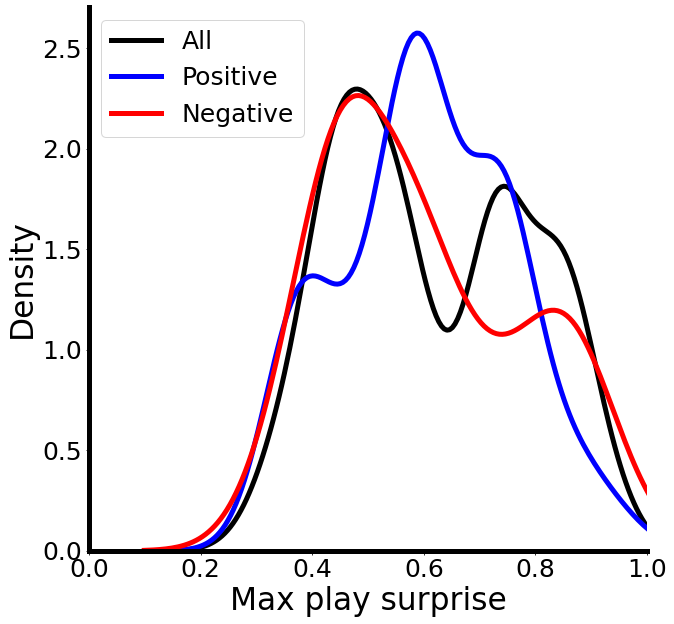

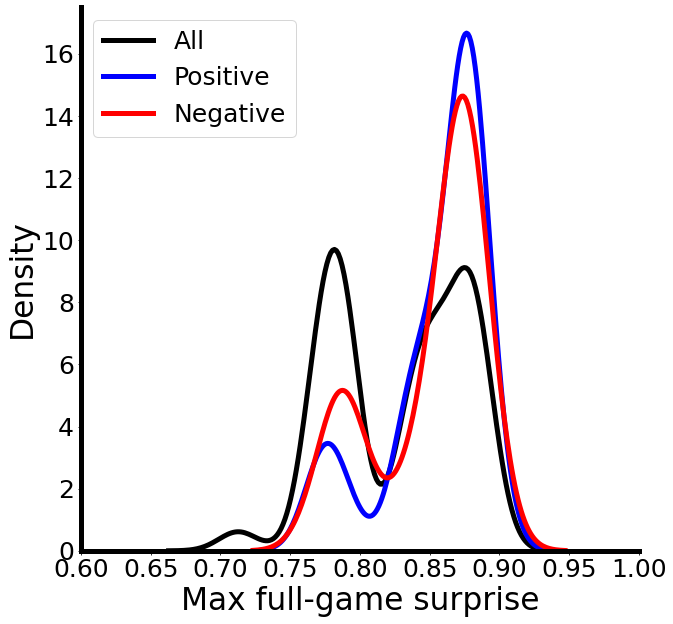

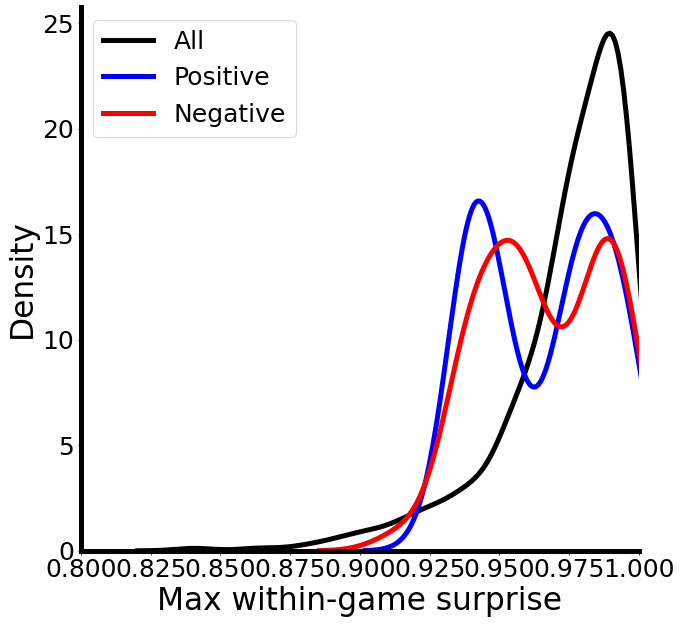

In [426]:
#distribution of mx plays, fg, and wg sur
stat,pval=ttest_ind(mxmxsurs,mxmxsurp,nan_policy='omit')
print('pos, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(mxmxsurs,mxmxsurn,nan_policy='omit')
print('neg, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(mxfgsurs,mxfgsurp,nan_policy='omit')
print('pos, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(mxfgsurs,mxfgsurn,nan_policy='omit')
print('neg, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(mxwgsurs,mxwgsurp,nan_policy='omit')
print('pos, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(mxwgsurs,mxwgsurn,nan_policy='omit')
print('neg, stat = %s, pval = %s' %(stat,pval))

kdeplotf(mxmxsurs,mxmxsurp,mxmxsurn,'Max play surprise',[0,1],'figs/season_play_sur.pdf',0)
kdeplotf(mxfgsurs,mxfgsurp,mxfgsurn,'Max full-game surprise',[0.6,1],'figs/season_fgame_sur.pdf',0)
kdeplotf(mxwgsurs,mxwgsurp,mxwgsurn,'Max within-game surprise',[0.8,1],'figs/season_wgame_sur.pdf',0)

adj, pos, stat = -0.9852440553231367, pval = 0.3249304465803563
adj, neg, stat = -0.9459675525402833, pval = 0.3445890079932473


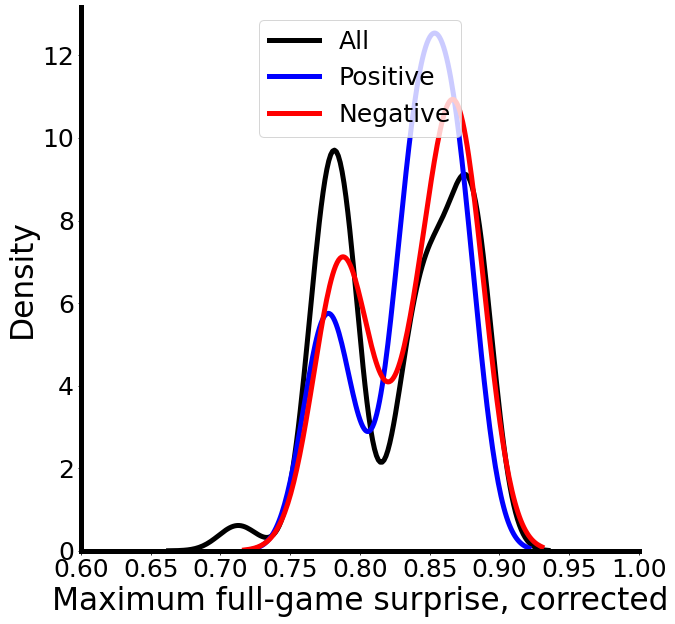

adj, pos, stat = -0.6638889248430175, pval = 0.5070265866264652
adj, neg, stat = -0.180157091263257, pval = 0.8570963328416521


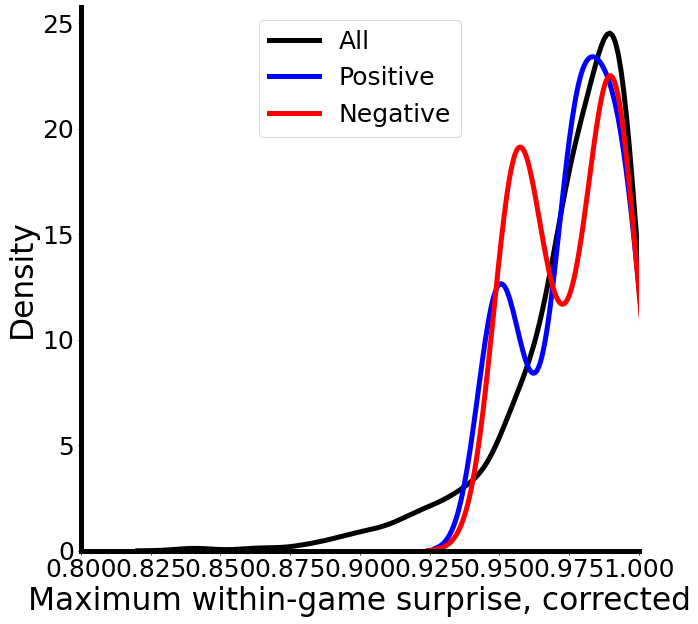

In [427]:
coff=0.875
lcoff=0.6
qfgp=np.where(np.logical_and(mxfgsurp<coff,mxfgsurp>lcoff))[0]
stat,pval=ttest_ind(mxfgsurs,mxfgsurp[qfgp],nan_policy='omit')
print('adj, pos, stat = %s, pval = %s' %(stat,pval))
qfgn=np.where(np.logical_and(mxfgsurn<coff,mxfgsurn>lcoff))[0]

stat,pval=ttest_ind(mxfgsurs,mxfgsurn[qfgn],nan_policy='omit')
print('adj, neg, stat = %s, pval = %s' %(stat,pval))
kdeplotf(mxfgsurs,mxfgsurp[qfgp],mxfgsurn[qfgn],'Maximum full-game surprise, corrected',[0.6,1],
         'figs/season_fgame_sur_pn_corr.pdf',4)

coff=1
lcoff=0.94
qwgp=np.where(np.logical_and(mxwgsurp<coff,mxwgsurp>lcoff))[0]
stat,pval=ttest_ind(mxwgsurs,mxwgsurp[qwgp],nan_policy='omit')
print('adj, pos, stat = %s, pval = %s' %(stat,pval))
qwgn=np.where(np.logical_and(mxfgsurn<coff,mxwgsurn>lcoff))[0]

stat,pval=ttest_ind(mxwgsurs,mxwgsurn[qwgn],nan_policy='omit')
print('adj, neg, stat = %s, pval = %s' %(stat,pval))
kdeplotf(mxwgsurs,mxwgsurp[qwgp],mxwgsurn[qwgn],'Maximum within-game surprise, corrected',[0.8,1],
         'figs/season_wgame_sur_pn_corr.pdf',4)

r-squared =  0.4355661839635033


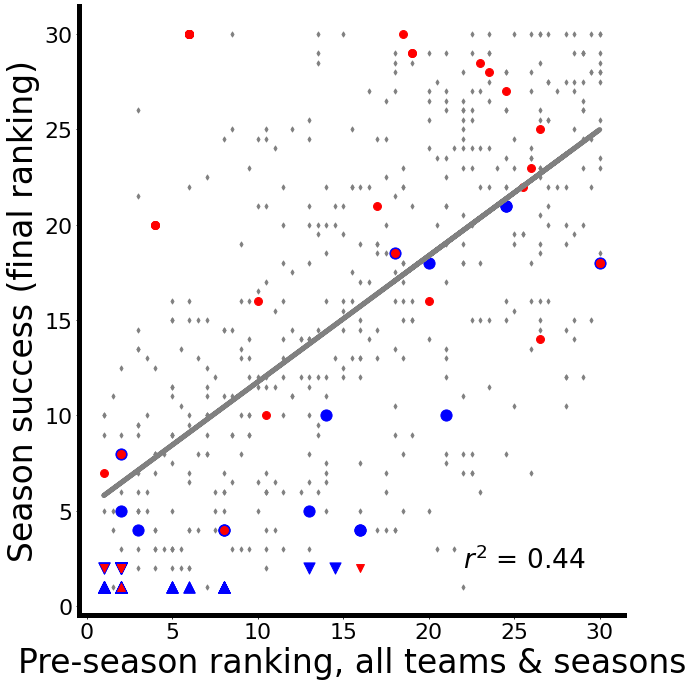

In [428]:
#relationship between pre_odds and record
#re-run this using different predictor (inv) values and outv=2
inv=4 #which odds to use: 1=pre-season,2=lowest in season,3=highest in season,4=pre_rank
outv=2 #outcome variable: 1=regular season record,2=season ranking

final_record=df_svr['Win %'].values
pre_rank_a=np.matrix.flatten(pre_ranks)
final_rank=np.matrix.flatten(rank_ys)

if inv<4:
    if inv==1:
        q=df_ots['Pre3'].values
    elif inv==2:
        q=df_ots['low_odds'].values
    elif inv==3:
        q=df_ots['hi_odds'].values
    odds_a=np.zeros((len(df_ots)))
    odds_a[q>0]=100/(100+q[q>0])
    odds_a[q<=0]=np.absolute(q[q<=0])/(100+np.absolute(q[q<=0]))
    if inv==1:
        x_a,x_p,x_n=np.log(odds_a)+0,np.log(pre_oddsp)+0,np.log(pre_oddsn)+0
        xl='''Log pre-season championship
probability, all teams & seasons'''
    elif inv==2:
        x_a,x_p,x_n=np.log(odds_a)+0,np.log(low_oddsp)+0,np.log(low_oddsn)+0
        xl='''Log lowest championship probabillity
during season, all teams & seasons'''
    elif inv==3:
        x_a,x_p,x_n=np.log(odds_a)+0,np.log(hi_oddsp)+0,np.log(hi_oddsn)+0
        xl='''Log highest championship odds
during season, all teams & seasons'''
elif inv==4:
    x_a,x_p,x_n=pre_rank_a+0,pre_rankp+0,pre_rankn+0
    xl='''Pre-season ranking, all teams & seasons'''

if outv==1:
    y_a,y_p,y_n=final_record+0,recordp+0,recordn+0
    yl='Season win %, all teams & seasons'
elif outv==2:
    y_a,y_p,y_n=final_rank+0,rankp+0,rankn+0
    yl='Season success (final ranking)'

sz=125
f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
x,y,lw3=x_a,y_a,2
plt.scatter(x,y,c='gray',marker='d',s=sz*0.1)
a,b=np.polyfit(x,y,1)
plt.plot(x, a*x+b,'gray',linewidth=lw)
ax.set_xlabel(xl,fontsize=fs)
ax.set_ylabel(yl,fontsize=fs)
corr, _ = pearsonr(x,y)
print('r-squared = ',corr**2)

x,y=x_p[wonchampp+lostchampp==0],y_p[wonchampp+lostchampp==0] #add positive seasons
plt.scatter(x,y,c='b',marker='o',s=sz)
x,y=x_p[wonchampp==1],y_p[wonchampp==1] 
plt.scatter(x,y,c='b',marker='^',s=sz)
x,y=x_p[lostchampp==1],y_p[lostchampp==1] 
plt.scatter(x,y,c='b',marker='v',s=sz)

x,y=x_n[wonchampn+lostchampn==0],y_n[wonchampn+lostchampn==0] 
plt.scatter(x,y,c='r',marker='o',s=sz*0.5)
x,y=x_n[wonchampn==1],y_n[wonchampn==1] 
plt.scatter(x,y,c='r',marker='^',s=sz*0.5)
x,y=x_n[lostchampn==1],y_n[lostchampn==1] 
plt.scatter(x,y,c='r',marker='v',s=sz*0.5)
if np.logical_and(inv==4,outv==2):
    ax.text(22,2,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*4/5)
elif np.logical_and(inv==3,outv==2):
    ax.text(-7,2,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*4/5)
elif np.logical_and(inv==1,outv==2):
    ax.text(-8,2,'$r^{2}$ = %.2f' %corr**2,fontsize=fs*4/5)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(lw)
f.tight_layout()
fn='figs/season_odds_records-' + str(inv) + '-' + str(outv) + '.pdf'
f.savefig(fn, transparent=True)

/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


pos 1 samp, resid, stat = -21.379691860746792, pval = 4.4501006424418354e-38
pos 1 samp, actual, stat = -29.469360968272735, pval = 1.3935395409390948e-49
neg 1 samp, resid, stat = 3.2190154439353074, pval = 0.002360333442341705
neg 1 samp, actual, stat = 0.9858002387976077, pval = 0.32938815294821766
pos 1 samp, resid, fgsur equated, stat = -13.802485697048844, pval = 1.1084342575071708e-18
neg 1 samp, resid, fgsur equated, stat = 4.473657643509939, pval = 0.00010248341932682304
pos 1 samp, resid, wgsur equated, stat = -16.852154089454288, pval = 5.653098578021938e-26
neg 1 samp, resid, wgsur equated, stat = 4.193332614251952, pval = 0.0001778162058547852
resid diff, stat = -9.157762111014836, pval = 5.562565054968702e-16
actual diff, stat = -10.803462674681596, pval = 3.3852708949494413e-20
no champ game, pos 1 samp, resid, stat = -13.582696734175391, pval = 4.220174984760138e-14
no champ game, neg 1 samp, resid, stat = -6.66564477986895, pval = 3.5357922536165035e-05
no champ, pos 1

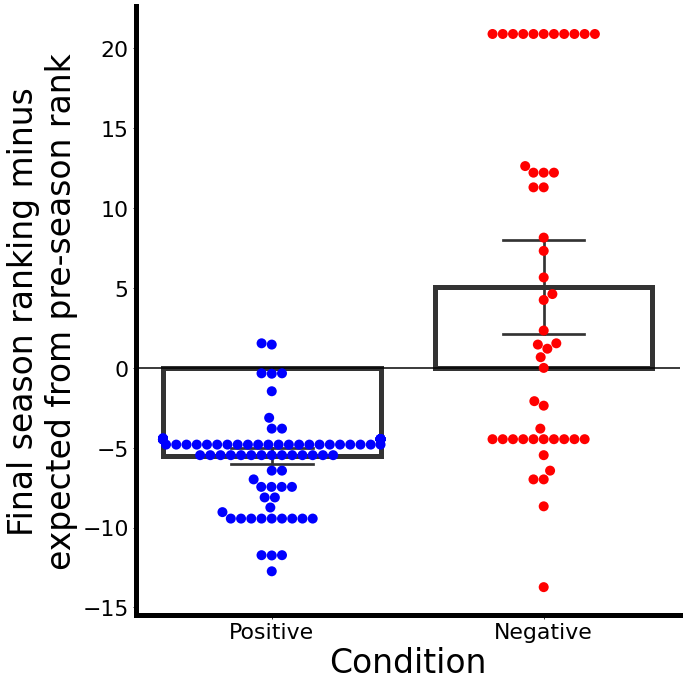

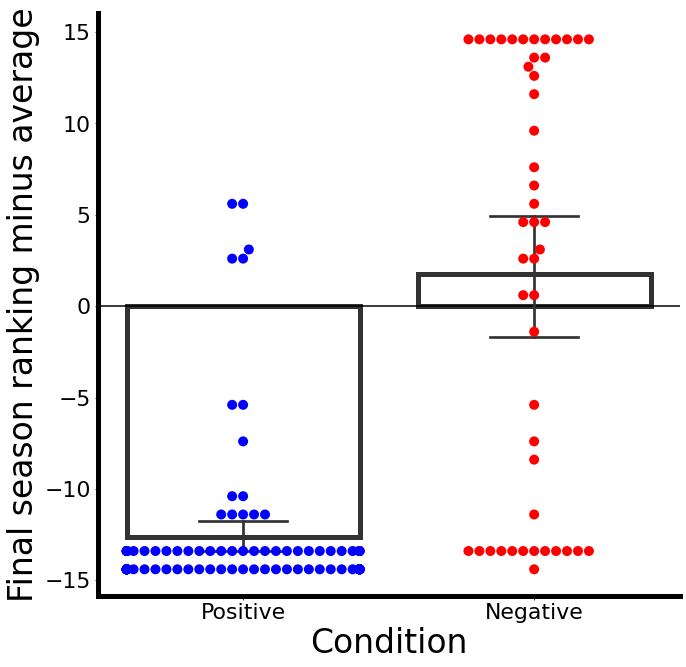

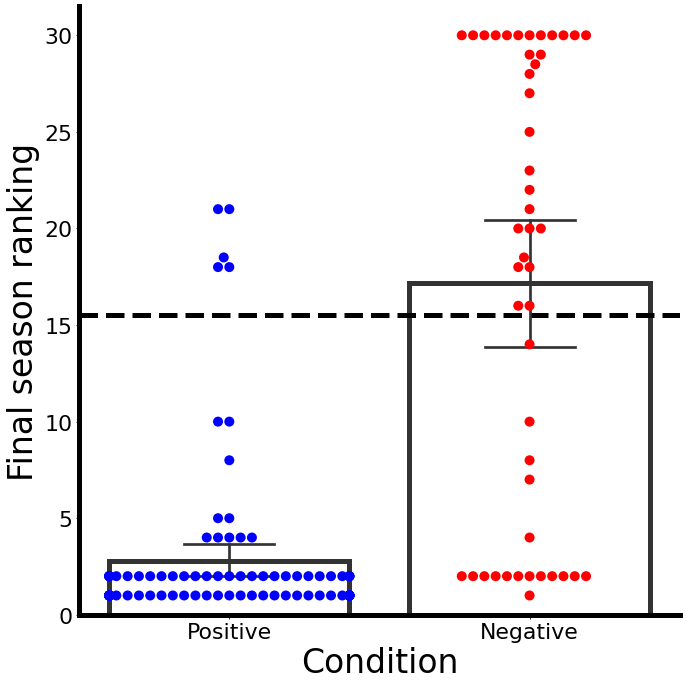

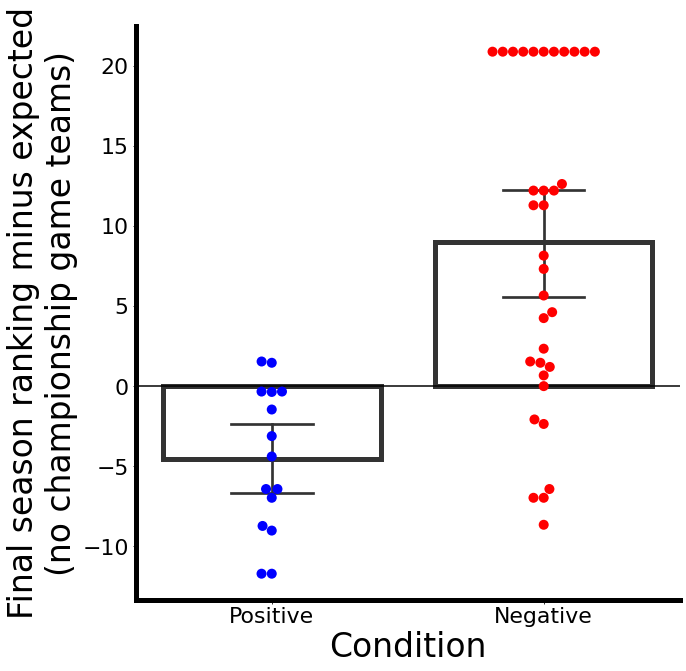

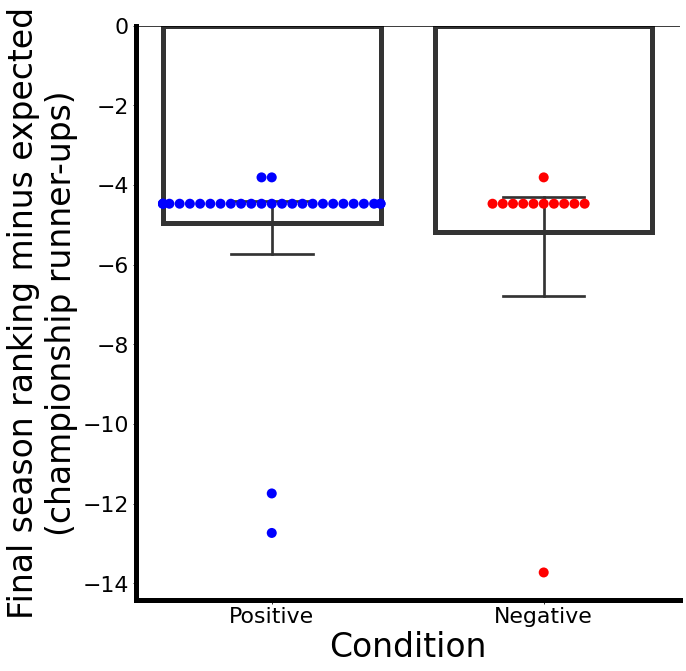

In [429]:
## do contrasts ONLY w/ actual wins - look vs. residual analysis
x1,y1=x_p,y_p # positive seasons
x2,y2=x_n,y_n # negative seasons

residp=y1-(a*x1+b)
residn=y2-(a*x2+b)
residp_val=np.multiply(residp,dfsp['Cheering FOR this team (1) or AGAINST them (-1)'].values)
residn_val=np.multiply(residn,dfsn['Cheering FOR this team (1) or AGAINST them (-1)'].values)

residp_vsavg=y1-np.mean(y_a)
residn_vsavg=y2-np.mean(y_a)
residp_vsavg=np.multiply(residp_vsavg,dfsp['Cheering FOR this team (1) or AGAINST them (-1)'].values)
residn_vsavg=np.multiply(residn_vsavg,dfsn['Cheering FOR this team (1) or AGAINST them (-1)'].values)

if outv==1:
    yl='''Wins minus expected x valence'''
    yl2='''Season win % x valence'''
    yl3='''Season win %'''
    yl4='''Season win %
(no championship game teams)'''
    yl4='''Season win %
(championship runner-ups)'''
elif outv==2:
    if inv==1:
        yl='''Final season ranking minus expected
from pre-season probability'''
    elif inv==3:
        yl='''Final season ranking minus expected
from max championship probability'''
    elif inv==4:
        yl='''Final season ranking minus
expected from pre-season rank'''
    yl2='''Final season ranking minus average'''
    yl3='''Final season ranking'''
    yl4='''Final season ranking minus expected
(no championship game teams)'''
    yl5='''Final season ranking minus expected
(championship runner-ups)'''
    
fn='figs/season_actualVexpected-' + str(inv) + '-' + str(outv) + '.pdf'
barswarm(residp_val,residn_val,'Residual',yl,fn,0)
fn='figs/season_actualXvalence.pdf'
barswarm(residp_vsavg,residn_vsavg,'Actual',yl2,fn,0)
fn='figs/season_actual.pdf'
barswarm(y1,y2,'Actual',yl3,fn,3)
qp,qn=np.where((wonchampp+lostchampp)==0)[0],np.where((wonchampn+lostchampn)==0)[0]
fn='figs/season_actualVexpectedXvalence_nochamp.pdf'
barswarm(residp_val[qp],residn_val[qn],'ResidualNoChamp',yl4,fn,0)
qp,qn=np.where((lostchampp)==1)[0],np.where((lostchampn)==1)[0]
fn='figs/season_actualVexpectedXvalence_runnerups.pdf'
barswarm(residp_val[qp],residn_val[qn],'ResidualRunnerups',yl5,fn,0)

stat,pval=stats.ttest_1samp(residp_val,popmean=0,nan_policy='omit')
print('pos 1 samp, resid, stat = %s, pval = %s' %(stat,pval))
stat,pval=stats.ttest_1samp(y1,popmean=np.mean(x_a),nan_policy='omit')
print('pos 1 samp, actual, stat = %s, pval = %s' %(stat,pval))
stat,pval=stats.ttest_1samp(residn_val,popmean=0,nan_policy='omit')
print('neg 1 samp, resid, stat = %s, pval = %s' %(stat,pval))
stat,pval=stats.ttest_1samp(y2,popmean=np.mean(x_a),nan_policy='omit')
print('neg 1 samp, actual, stat = %s, pval = %s' %(stat,pval))

stat,pval=stats.ttest_1samp(residp_val[qfgp],popmean=0,nan_policy='omit')
print('pos 1 samp, resid, fgsur equated, stat = %s, pval = %s' %(stat,pval))
stat,pval=stats.ttest_1samp(residn_val[qfgn],popmean=0,nan_policy='omit')
print('neg 1 samp, resid, fgsur equated, stat = %s, pval = %s' %(stat,pval))
stat,pval=stats.ttest_1samp(residp_val[qwgp],popmean=0,nan_policy='omit')
print('pos 1 samp, resid, wgsur equated, stat = %s, pval = %s' %(stat,pval))
stat,pval=stats.ttest_1samp(residn_val[qwgn],popmean=0,nan_policy='omit')
print('neg 1 samp, resid, wgsur equated, stat = %s, pval = %s' %(stat,pval))

stat,pval=ttest_ind(residp_val,residn_val,nan_policy='omit')
print('resid diff, stat = %s, pval = %s' %(stat,pval))
stat,pval=ttest_ind(y1,y2,nan_policy='omit')
print('actual diff, stat = %s, pval = %s' %(stat,pval))

stat,pval=stats.ttest_1samp(residp_val[qp],popmean=0,nan_policy='omit')
print('no champ game, pos 1 samp, resid, stat = %s, pval = %s' %(stat,pval))
stat,pval=stats.ttest_1samp(residn_val[qn],popmean=0,nan_policy='omit')
print('no champ game, neg 1 samp, resid, stat = %s, pval = %s' %(stat,pval))

qp,qn=np.where((wonchampp)==0)[0],np.where((wonchampn)==0)[0]
stat,pval=stats.ttest_1samp(residp_val[qp],popmean=0,nan_policy='omit')
print('no champ, pos 1 samp, resid, stat = %s, pval = %s' %(stat,pval))
stat,pval=stats.ttest_1samp(residn_val[qn],popmean=0,nan_policy='omit')
print('no champ, neg 1 samp, resid, stat = %s, pval = %s' %(stat,pval))


/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


pos vs neg, stat = 0.05126589242237928, pval = 0.9592074772657844
r-squared,positive = 0.0003695968230198624, pval = 0.8717488648162937
r-squared,negative = 0.06023351697698621, pval = 0.13749466265074042


(0.009698781059540432,
 3.4586556493202054,
 -0.0392119244391972,
 3.621753246753247)

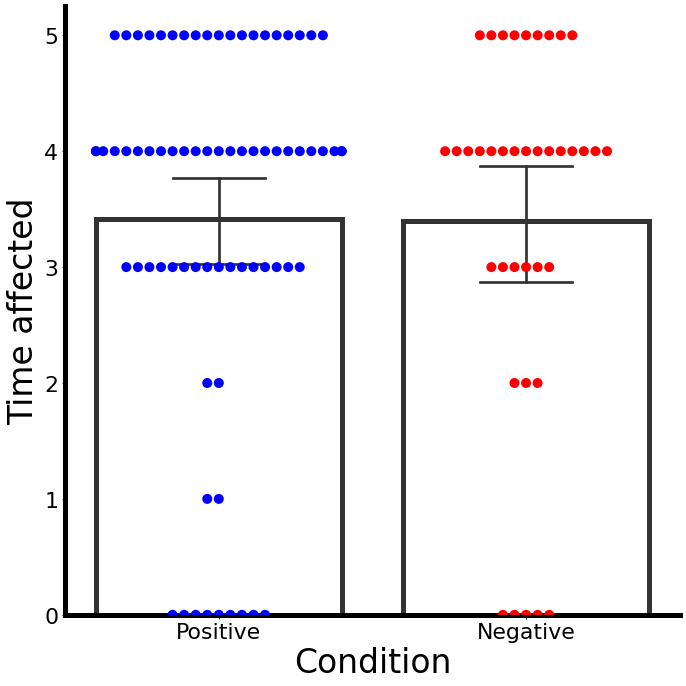

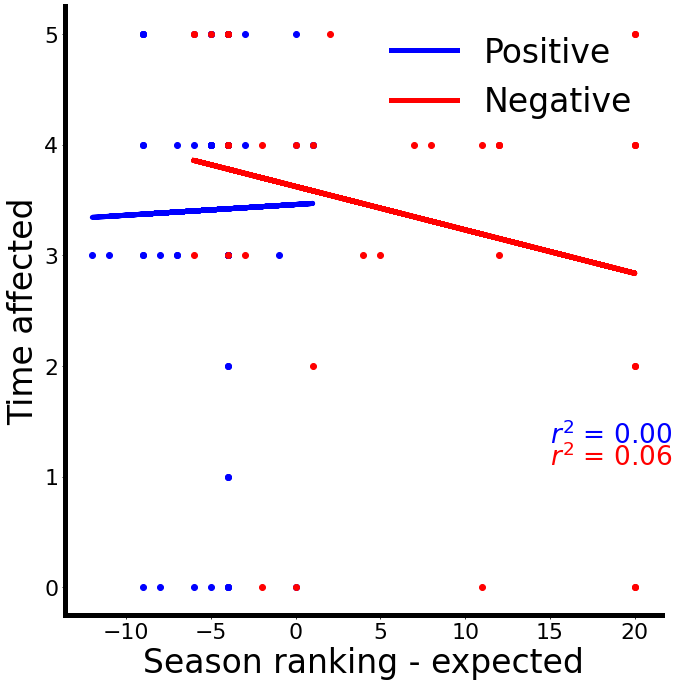

In [430]:
dfsp['x'],dfsn['x']=x_p,x_n
dfsp['y'],dfsn['y'],dfsp['y_res'],dfsn['y_res']=y_p,y_n,residp_val,residn_val

#time affected
act_resid=2 #actual vs residual outcome
if act_resid==1:
    ystr1,ybr1='y','Season ranking'
else:
    ystr1,ybr1='y_res','Season ranking - expected'
#ystr1,ybr1='For - against','For - against fandom'
ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
qp=np.where(dfsp[ystr2].isna()==0)[0]
qn=np.where(dfsn[ystr2].isna()==0)[0]
x1,x2=dfsp[ystr1].values,dfsn[ystr1].values
y1,y2=dfsp[ystr2].values,dfsn[ystr2].values

fn='figs/season_'+str(ybr2)+'.pdf'
barswarm(y1[qp],y2[qn],ybr2,ybr2,fn,0)

stat,pval=ttest_ind(y1[qp],y2[qn],nan_policy='omit')
print('pos vs neg, stat = %s, pval = %s' %(stat,pval))
corr, pval = pearsonr(x1[qp],y1[qp])
print('r-squared,positive = %s, pval = %s' %(corr**2,pval))
corr, pval = pearsonr(x2[qn],y2[qn])
print('r-squared,negative = %s, pval = %s' %(corr**2,pval))

scatterp(x1[qp].astype(int),y1[qp].astype(int),x2[qn].astype(int),y2[qn].astype(int),
         ybr1,ybr2,'figs/season_'+str(ystr1)+'_'+str(ystr2)+'.pdf',2)

Time affected, plays, stat = 1.5479286095065234, pval = 0.12391329031514907
Time affected, games, stat = 0.9602979005867202, pval = 0.3384610393538947
Time affected, seasons, stat = 0.05126589242237928, pval = 0.9592074772657844


/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 8.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Emotionality, plays, stat = 19.05733088743441, pval = 5.797009443358979e-41
Emotionality, games, stat = 25.845830304911093, pval = 6.298834697010208e-57
Emotionality, seasons, stat = 14.805560143841621, pval = 1.942869957475734e-30


/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 13.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Absolute emotionality, plays, stat = -0.011272080572220863, pval = 0.9910221925297347
Absolute emotionality, games, stat = 0.7114523989315431, pval = 0.47791628041375445
Absolute emotionality, seasons, stat = 1.0768132202400775, pval = 0.28341576318534


/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Fandom, plays, stat = -1.2976473175056114, pval = 0.1965125991559232
Fandom, games, stat = -2.06332915423263, pval = 0.04081665574111237
Fandom, seasons, stat = -1.20427455641345, pval = 0.23057516821715054


/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 27.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


# re-viewings, plays, stat = 3.3552377126628254, pval = 0.0010173046009793066
# re-viewings, games, stat = 2.3859423629853476, pval = 0.018300144410735707
# re-viewings, seasons, stat = 1.0540515722757602, pval = 0.2939769923381975


/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 23.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 18.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 51.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/jantony/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


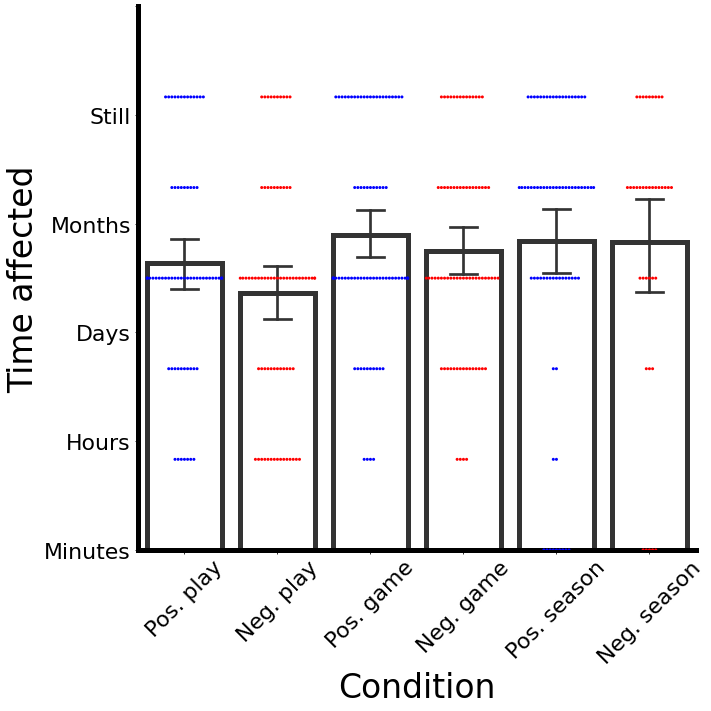

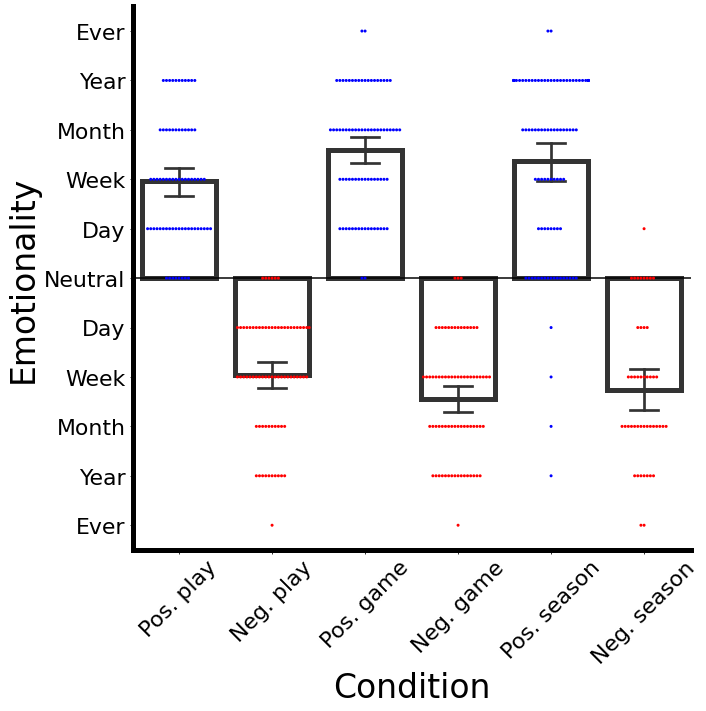

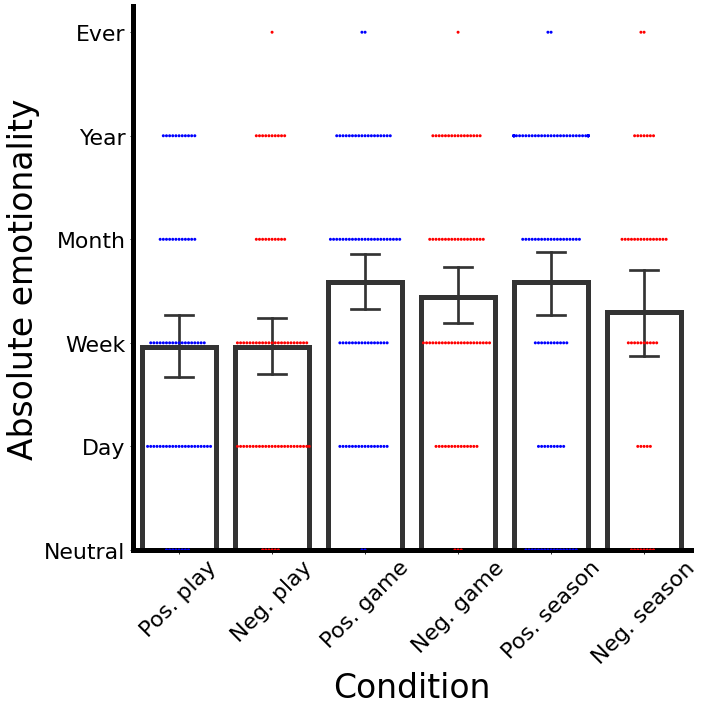

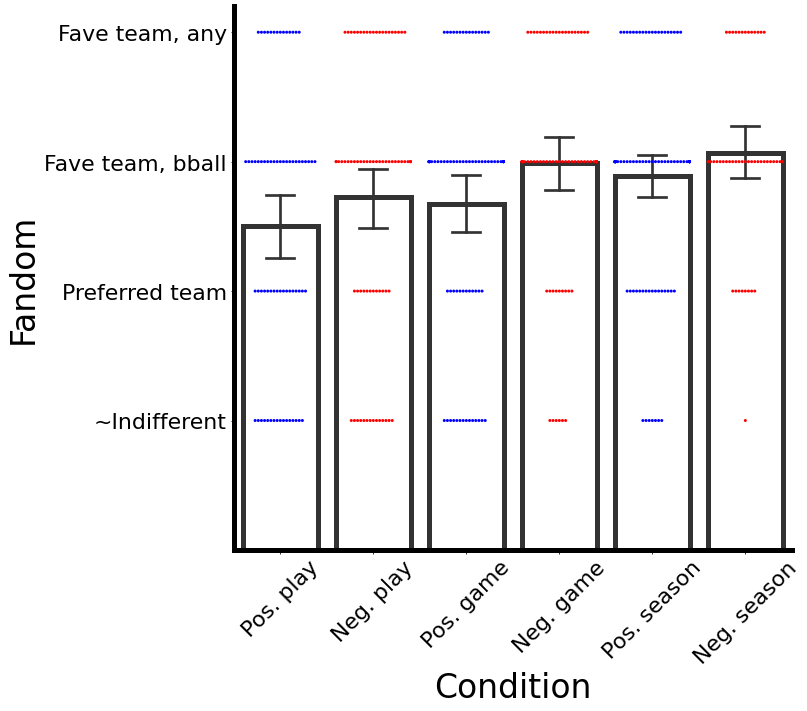

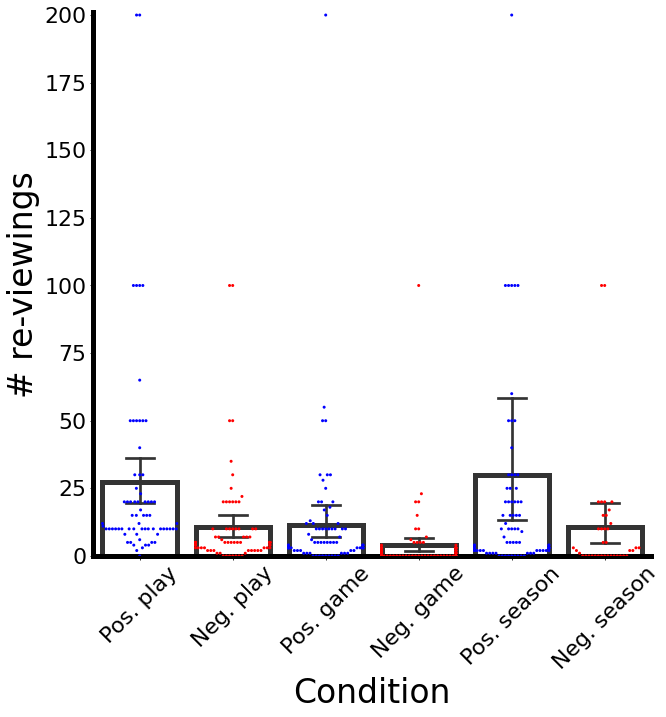

In [431]:
def barswarm_a(dp,dn,dgp,dgn,dsp,dsn,lab,yl,fn,exv):
    dat1=pd.DataFrame({'Condition':['Pos. play']*len(dp),lab:dp})
    dat2=pd.DataFrame({'Condition':['Neg. play']*len(dn),lab:dn})
    dat3=pd.DataFrame({'Condition':['Pos. game']*len(dgp),lab:dgp})
    dat4=pd.DataFrame({'Condition':['Neg. game']*len(dgn),lab:dgn})
    dat5=pd.DataFrame({'Condition':['Pos. season']*len(dsp),lab:dsp})
    dat6=pd.DataFrame({'Condition':['Neg. season']*len(dsn),lab:dsn})
    dat=dat1.append(dat2)
    dat=dat.append(dat3)
    dat=dat.append(dat4)
    dat=dat.append(dat5)
    dat=dat.append(dat6)
    f,ax=plt.subplots(nrows=1,ncols=1,figsize=(fsz,fsz))
    colors=["blue","red","blue","red","blue","red"] #"#FF0B04", "#4374B3"
    cp = sns.set_palette(sns.color_palette(colors))
    if exv==4:
        ax=sns.barplot(x=dat['Condition'],y=np.absolute(dat[lab]),facecolor=(1, 1, 1, 0),errcolor=".2",
                   edgecolor=".2",palette=cp,saturation=1,linewidth=lw,capsize=.3)
    else:
        ax=sns.barplot(x=dat['Condition'],y=dat[lab],facecolor=(1, 1, 1, 0),errcolor=".2",
                   edgecolor=".2",palette=cp,saturation=1,linewidth=lw,capsize=.3)
    ax.tick_params(axis='x', rotation=45)
    ax=sns.swarmplot(x=dat['Condition'],y=dat[lab],facecolor=None,palette=cp,size=msz//3)
    ax.hlines(0,-0.5,5.5,color="black")
    ax.set_ylabel(yl,fontsize=fs)
    if exv==0:
        ax.set_yticks(np.linspace(0,6,6))
        ax.set_yticklabels(['Minutes','Hours','Days','Months','Still'])
    elif exv==1:
        ax.set_yticks(np.linspace(-5,5,11))
        ax.set_yticklabels(['Ever','Year','Month','Week','Day','Neutral','Day','Week','Month','Year','Ever']) 
    elif exv==2:
        ax.set_yticks(np.linspace(1,4,4))
        ax.set_yticklabels(['~Indifferent','Preferred team','Fave team, bball','Fave team, any']) 
    elif exv==3:
        ax.set_ylim([0,201])
    elif exv==4:
        ax.set_yticks(np.linspace(0,5,6))
        ax.set_yticklabels(['Neutral','Day','Week','Month','Year','Ever']) 
    ax.set_xlabel('Condition',fontsize=fs)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(lw)
    f.savefig(fn, transparent=True)

#time affected by play, game, season
def consol(ystr2,ybr2,exv2):
    #play
    qp=np.where(dfp[ystr2].isna()==0)[0]
    qn=np.where(dfn[ystr2].isna()==0)[0]
    y1,y2=dfp[ystr2].values,dfn[ystr2].values
    if exv2==4:
        y1,y2=np.absolute(dfp[ystr2].values),np.absolute(dfn[ystr2].values)
    stat,pval=ttest_ind(y1[qp],y2[qn],nan_policy='omit')
    print('%s, plays, stat = %s, pval = %s' %(ybr2,stat,pval))
    #game
    qgp=np.where(dfgp[ystr2].isna()==0)[0]
    qgn=np.where(dfgn[ystr2].isna()==0)[0]
    y1g,y2g=dfgp[ystr2].values.astype(int),dfgn[ystr2].values.astype(int)
    if exv2==4:
        y1g,y2g=np.absolute(dfgp[ystr2].values.astype(int)),np.absolute(dfgn[ystr2].values.astype(int))
    stat,pval=ttest_ind(y1g[qgp],y2g[qgn],nan_policy='omit')
    print('%s, games, stat = %s, pval = %s' %(ybr2,stat,pval))
    #season
    qsp=np.where(dfsp[ystr2].isna()==0)[0]
    qsn=np.where(dfsn[ystr2].isna()==0)[0]
    y1s,y2s=dfsp[ystr2].values.astype(int),dfsn[ystr2].values.astype(int)
    if exv2==4:
        y1s,y2s=np.absolute(dfsp[ystr2].values.astype(int)),np.absolute(dfsn[ystr2].values.astype(int))
    stat,pval=ttest_ind(y1s[qsp],y2s[qsn],nan_policy='omit')
    print('%s, seasons, stat = %s, pval = %s' %(ybr2,stat,pval))
    fn='figs/all_'+str(ybr2)+'.pdf'
    barswarm_a(y1[qp],y2[qn],y1g[qgp],y2g[qgn],y1s[qsp],y2s[qsn],ybr2,ybr2,fn,exv2)

ystr2,ybr2='How long affected? (1=minutes,2=hours,3=days,4=months,5=still affected)','Time affected'
consol(ystr2,ybr2,0)
ystr2='Overall emotionality w/r/t life (-5 to 5) (Day, Week, Month, Year, Ever)'
ybr2='Emotionality'
consol(ystr2,ybr2,1)
ybr2='Absolute emotionality'
consol(ystr2,ybr2,4)
ystr2,ybr2='How big a fan?','Fandom'
consol(ystr2,ybr2,2)
ystr2,ybr2='# re-viewings?','# re-viewings'
consol(ystr2,ybr2,3)